# Introduction

- outliers regularisation method = mean
- mean regularisation columns = [
    "PropertyType",
    'County',
    "PostcodeArea",
    'District',
    'TownCity',
]
- "isLog" : True,
- 'classify_outliers_cycle': 2

--> r2 = 0.74

In [20]:
config_processing = {
    # ----- default
    # """
    #     r2 = 0.6827
    #     inputs = [
    #         'OldNew' ,  
    #         'Duration' , 
    #         'PPDCategoryType',
    #         # Month
    #         *[k for k in data.columns if ('Month' in k)],
    #         # Weights
    #         *[k for k in data.columns if ('Weights' in k) and (not ("Transf" in k))],
    #         # # zscore
    #         *[k for k in data.columns if ('WeightsTransf' in k)],
    #         # PropertyType
    #         *[k for k in data.columns if ('PropertyType' in k)],
    #         # target
    #         target
    #     ]
    # """
    "default" : {
        "method" : "mean",
        "groupby" : [
            "PPDCategoryType",
            "PropertyType",
            "Duration",
            'District',
            'TownCity',
        ],
        "isLog" : False,
        'classify_outliers_cycle': 2
    },
    # ----- v1
    # """
    #     r2 = 0.6813    
    #     inputs = [
    #         'OldNew' ,  
    #         'Duration' , 
    #         'PPDCategoryType',
    #         # Month
    #         *[k for k in data.columns if ('Month' in k)],
    #         # Weights
    #         *[k for k in data.columns if ('Weights' in k) and (not ("Transf" in k))],
    #         # PropertyType
    #         *[k for k in data.columns if ('PropertyType' in k)],
    #         # target
    #         target
    #     ]
    # """
    "version 1" : {
        "method" : "mean",
        "groupby" : [
            "PropertyType",
            "Duration",
            'County',
            'District',
            'TownCity',
        ],
        "isLog" : False,
        'classify_outliers_cycle': 2
    },
    # ----- v2 
    # """
    #     r2 = 0.6964    
    #     inputs = [
    #         'OldNew' ,  
    #         'Duration' , 
    #         'PPDCategoryType',
    #         # Month
    #         *[k for k in data.columns if ('Month' in k)],
    #         # Weights
    #         *[k for k in data.columns if ('Weights' in k) and (not ("Transf" in k))],
    #         # PropertyType
    #         *[k for k in data.columns if ('PropertyType' in k)],
    #         # target
    #         target
    #     ]
    # """
    "version 2" : {
        "method" : "mean",
        "groupby" : [
            "PropertyType",
            'County',
            "PostcodeArea",
            'District',
            'TownCity',
        ],
        "isLog" : True,
        'classify_outliers_cycle': 2
    },
    # ----- v3 
    # """
    #     r2 = ??    
    #     inputs = [
    #         'OldNew' ,  
    #         'Duration' , 
    #         'PPDCategoryType',
    #         # Month
    #         *[k for k in data.columns if ('Month' in k)],
    #         # Weights
    #         *[k for k in data.columns if ('Weights' in k) and (not ("Transf" in k))],
    #         # PropertyType
    #         *[k for k in data.columns if ('PropertyType' in k)],
    #         # target
    #         target
    #     ]
    # """
    "version 3" : {
        "method" : "mean",
        "groupby" : [
            "PropertyType",
            "Duration",
            'County',
            "PostcodeArea",
            'District',
            'TownCity',
            
        ],
        "isLog" : False,
        'classify_outliers_cycle': 2
    },
}

In [21]:
choosed_version = "version 2"
# ----- define elements
outliers_regularisation_method = config_processing[choosed_version]["method"]
groupbycolumns = config_processing[choosed_version]["groupby"]
logoutlierfence= config_processing[choosed_version]["isLog"]
classify_outliers_cycle= config_processing[choosed_version]["classify_outliers_cycle"]

# Load data

In [4]:
# %load_ext cudf.pandas
import math 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import scipy as sp
# pd.set_option('float_format', '{:f}'.format)
plt.style.use('ggplot')

import pickle
import json
from matplotlib import style 
print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [5]:
columns = [
    'Id',
    'Price',
    'TransferDate',
    'Postcode',
    'PropertyType',
    'OldNew',
    'Duration',
    'PAON',
    'SAON',
    'Street',
    'Locality' ,
    'TownCity',
    'District',
    'County',
    'PPDCategoryType',
    'RecordStatus',
]
houses_loaded = pd.read_csv('../data/pp-2021.csv',names=columns)

# Functions

## visualization

In [7]:
def find_df_name(df):
   name = [name for name, obj in globals().items() if id(obj) == id(df)]
   return name[0] if name else None

def bar_catg_feature(col_name,df_data):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
    # data
    df_feature = df_data.loc[:,[col_name,"Price"]]

    df_grouped = df_feature.groupby(col_name)["Price"].mean()
    # first plot
    sns.barplot(
        x=df_grouped.index, 
        y=df_grouped.values, 
        ax=axes[0]
    )
    # second plot
    values = df_feature[col_name].value_counts(dropna=False)
    sns.barplot(
        x=values.index, 
        y=values.values,
        ax=axes[1]
    )
    # Add titles
    axes[0].set_title(f'Average Price by {col_name} (data={find_df_name(df_data)})')
    axes[1].set_title(f'distribution of {col_name} (data={find_df_name(df_data)})')
    # show
    plt.tight_layout()
    plt.show()

def bar_catg_pairfeature(colname1,colname2,colname3='Price',df_data=None):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 6))
    # data
    df_feature = df_data.loc[:,[colname1,colname2,colname3]]
    sns.barplot(
        data = df_feature,
        x=colname2, 
        y=colname3,
        hue=colname1,
        ax=axes
    )
    # Add titles
    axes.set_title(f'Average Price by {colname1}, {colname2} (data={find_df_name(df_data)})')
    # show
    plt.tight_layout()
    plt.show()

def bar_geo_feature(colname1,colname2='Price',df_data = None,ascending=False,method='mean'):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
    # data
    if method=='mean':
        df_feature = df_data.groupby(colname1)[colname2].mean().sort_values(ascending=ascending)[:50]
    elif method=='median':
        df_feature = df_data.groupby(colname1)[colname2].median().sort_values(ascending=ascending)[:50]
    sns.barplot(
        x=df_feature.index, 
        y=df_feature.values,
        ax=axes
    )
    # Add titles
    axes.tick_params(axis='x', rotation=90)
    axes.set_title(f'{method} of {colname2} by {colname1} (data={find_df_name(df_data)})')
    # show
    # plt.tight_layout()
    plt.show()

def box_geo_feature(colname1,colname2='Price',df_data = None,method='mean'):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10, 6))
    if method=='mean':
        df_grouped_mean = df_data.groupby(colname1)[colname2].mean().sort_values(ascending=False)
    elif method=='median':
        df_grouped_mean = df_data.groupby(colname1)[colname2].median().sort_values(ascending=False)
    sns.boxplot(df_grouped_mean)
    plt.title(f'Distribution of {method} of {colname2} by {colname1} (data={find_df_name(df_data)})')
    plt.show()

def price_distribution(df,bins=100,kind='bar',transform_log=0):
    if transform_log==0:
        price = df['Price']  
    else:
        price = df['Price']
        for i in range(transform_log):
            price = np.log1p(price)
    price.value_counts(bins=bins).sort_index().plot(kind=kind,figsize=(20,16))
    # show
    plt.tight_layout()
    plt.show()

def price_boxplot(df,col_name=None,isLog=False):
    kwargs = {
        'y' : np.log(df['Price']) if isLog else df['Price']
    }
    if col_name: kwargs['x'] = df[col_name]  
    ax = sns.boxplot(**kwargs)
    title = f'Price by {col_name}' if col_name!= None else 'Price' 
    ax.set_title(title + f' :(log={isLog},data={find_df_name(df)})',fontsize=10)
    plt.show()

def price_scatterplot(df,col_name=None,isColDivided=False,isLog=False):
    
    if isColDivided:
        # -- inputs
        vv = df[col_name].value_counts().index
        ncols = 2
        nrows = len(vv)//ncols + len(vv)%ncols
        # -- canvas
        fig, ax = plt.subplots(
            nrows = nrows,
            ncols = ncols, 
            figsize=(10*ncols,8*nrows)
        )
        # -- draw
        i=j=0
        for ptype in vv:
            dd = df.loc[df[col_name] == ptype,['Price',col_name]]
            if nrows == 1:
                sns.scatterplot(
                    x = dd[col_name],
                    y = np.log(dd.Price) if isLog else dd.Price,
                    ax = ax[j]
                ).set(title=f'{col_name} ({ptype})')
                # ax[j].plot(dd)
                # ax[j].title.set_text(f'{col_name}({ptype})')
            else : 
                sns.scatterplot(
                    x = dd[col_name],
                    y = np.log(dd.Price) if isLog else dd.Price,
                    ax=ax[i, j]
                ).set(title=f'{col_name} ({ptype})')
                # ax[i, j].plot(dd)
                # ax[i, j].title.set_text(f'{col_name}({ptype})')
            if j == 1:
                i += 1
                j=0
            else: j+=1
        fig.suptitle(f'Price by {col_name} :(log={isLog},data={find_df_name(df)})')
    else:
        kwargs = {
            'y' : np.log(df['Price']) if isLog else df['Price']
        }
        if col_name: kwargs['x'] = df[col_name] 
        ax = sns.scatterplot(**kwargs)
        title = f'Price by {col_name}' if col_name!= None else 'Price' 
        ax.set_title(title + f' :(log={isLog},data={find_df_name(df)})',fontsize=10)
    plt.show()

def visualise_grps_bycol(df,col_name,ncols=2):
    vv = df[col_name].value_counts().index
    nrows = len(vv)//ncols + len(vv)%ncols
    fig , ax = plt.subplots(
        nrows = nrows,
        ncols = ncols,
        figsize=(10*ncols,8*nrows)
    )
    i = j = 0
    for ptype in vv:
        print(f"{ptype} : ({i},{j})")
        dd = df.loc[df[col_name] == ptype,'Price']
        if nrows == 1:
            ax[j].plot(dd)
            ax[j].title.set_text(f'{col_name}({ptype})')
        else : 
            ax[i, j].plot(dd)
            ax[i, j].title.set_text(f'{col_name}({ptype})')
        if j == 1:
            i += 1
            j=0
        else: j+=1
    plt.show()

def visualise_grps(df,col_name,ncols=2):
    bar_catg_feature(col_name,df_data = df)
    box_geo_feature(col_name,df_data = df)
    price_boxplot(df,col_name=col_name,isLog=False)
    price_boxplot(df,col_name=col_name,isLog=True)
    visualise_grps_bycol(df,col_name,ncols=ncols)

def visualise_global(df,ncols=2,bins=100,grp_columns = [],geo_col = [],scatter_col=[]):
    """
        grp_columns = ["PropertyType","Duration","OldNew"]
        geo_col = ["County","District","TownCity"]
    """
    # -- Price
    print("###################################################### Price ######################################################")
    price_distribution(df,bins=bins,kind='bar')
    price_boxplot(df,col_name=None,isLog=False)
    price_boxplot(df,col_name=None,isLog=True)
    
    # -- grp_columns
    for col in grp_columns:
        print(f"###################################################### {col} ######################################################")
        visualise_grps(df,col,ncols)
    
    # -- geo_col
    for col in geo_col:
        print(f"###################################################### {col} ######################################################")
        box_geo_feature(col,df_data = df)
        bar_geo_feature(col,colname2='Price',df_data = df,ascending=False,method='mean')
    
    # -- scatterplot
    for col in scatter_col:
        print(f"###################################################### {col} ######################################################")
        price_scatterplot(df,col_name=col,isColDivided=False,isLog=False)

## aggs & transformation

In [45]:
# function to add to JSON
def write_json(new_data, filename='features_data/data.json',isNew=False):
    if isNew:
        with open(filename, 'x') as f:
            json.dump({"data":new_data},f)
    else:
        with open(filename,'r+') as file:
              # First we load existing data into a dict.
            file_data = json.load(file)
            # Join new_data with file_data inside emp_details
            file_data["data"].update(new_data)
            # Sets file's current position at offset.
            file.seek(0)
            # convert back to json.
            json.dump(file_data, file, indent = 4)

def load_json(data_name=None, filename='../features_data/data.json'):
    with open(filename,'r') as file:
        file_data = json.load(file)
        data = file_data["data"] if data_name==None else file_data["data"][data_name]
    return data

def fix_dfHouses(df):
    def clean(x):
        if type(x)==str:
            return x.strip()
        elif x==None : return np.nan
        elif math.isnan(x): return np.nan
        else: return x
    for col in df.select_dtypes(include=['object']).columns:
        df[col] = df[col].apply(clean)
    # PropertyType : D = Detached, S = Semi-Detached, T = Terraced, F = Flats/Maisonettes, O = Other
    df.loc[df['PropertyType']=='T','PropertyType'] = 'Terraced'
    df.loc[df['PropertyType']=='S','PropertyType'] = 'SemiDetached'
    df.loc[df['PropertyType']=='D','PropertyType'] = 'Detached'
    df.loc[df['PropertyType']=='F','PropertyType'] = 'Flat'
    df.loc[df['PropertyType']=='O','PropertyType'] = 'Other'
    # OldNew : Y = New, N = Old
    df.loc[df['OldNew']=='Y','OldNew'] = 'New'
    df.loc[df['OldNew']=='N','OldNew'] = 'Old'
    # Duration : F = Freehold, L= Leasehold
    df.loc[df['Duration']=='F','Duration'] = 'Freehold'
    df.loc[df['Duration']=='L','Duration'] = 'Leasehold'
    # PPDCategoryType : A = StandardPrice (Standard Price Paid entry) ,  B = AdditionalPrice (Additional Price Paid)
    df.loc[df['PPDCategoryType']=='A','PPDCategoryType'] = 'StandardPrice'
    df.loc[df['PPDCategoryType']=='B','PPDCategoryType'] = 'AdditionalPrice'
    # TransferDate --> Day, Month
    df['TransferDate'] = pd.to_datetime(df['TransferDate'])
    df['TransferMonth'] = df['TransferDate'].dt.month
    df['TransferDay'] = df['TransferDate'].dt.day
    return df

def categorise(col,df_data,weight_func = lambda x:x):
    cat_col = df_data.groupby(col)['Price'].mean()
    # Calculate the quartiles:
    q25 = np.percentile(cat_col, 25)
    q75 = np.percentile(cat_col, 75)
    max_q = min(cat_col.max(),q75+1.5*(q75-q25))
    min_q = max(cat_col.min(),q25-1.5*(q75-q25))
    # caterg
    def col_cat(x,min_q,q25,q75,max_q):
        if x["Price"] < min_q : return "Very Poor"
        elif (x["Price"] >= min_q) and (x["Price"] <= q25) : return "Poor"
        elif (x["Price"] > q25) and (x["Price"] <= q75) : return "Normal"
        elif(x["Price"] > q75) and (x["Price"] <= max_q) : return "Rich"
        else: return "Very Rich"
    def coef_calc(x,coltype,coef):
        return coef_types[x[coltype]]*x['counts']
    # def cat_dfdata(df,col,weights):
    #     df_cp = df.copy()
    #     df_cp.loc[:,col+'Weights'] = df_cp.apply(lambda x:weights[x[col]],axis=1)
    #     return df_cp
    # caterg
    coltype = col+'Type'
    houses_categorised = pd.DataFrame(df_data.apply(lambda x: col_cat(x,min_q=min_q,q25=q25,q75=q75,max_q=max_q),axis=1),columns = [coltype])
    houses_categorised = pd.concat([df_data,houses_categorised], axis=1)
    houses_categorised_byType = houses_categorised.loc[:,[col,coltype]].groupby([col,coltype]).agg(
        counts = pd.NamedAgg(column=coltype, aggfunc=lambda x:x.count()),
    )
    coef_types_weights = {
        'Normal' : 0,
        'Poor': -2,
        'Rich': 2,
        'Very Poor': -4,
        'Very Rich': 4,
    }
    coef_types = {k:weight_func(v) for k,v in coef_types_weights.items()}
    houses_categorised_byType = houses_categorised_byType.groupby(level=[col],group_keys=False).apply(lambda x:x/x.sum()).reset_index()
    houses_categorised_byType['weights'] = houses_categorised_byType.apply(lambda x: coef_calc(x,coltype,coef_types),axis=1)
    categories_weights = houses_categorised_byType.groupby(col)['weights'].sum()
    
    return {
        'categories_weights':categories_weights,
        col+'Weights': df_data.apply(lambda x:categories_weights[x[col]],axis=1)
    }

def classify_outliers(df_data,colname='Price',by_log=False):
    # target
    if not by_log:
        target_col = df_data[colname]
        target_metrics = target_col.describe(percentiles = [0.25, 0.5, 0.75],datetime_is_numeric=True)
    else:
        target_col = np.log(df_data[colname].astype(float))
        target_metrics = target_col.describe(percentiles = [0.25, 0.5, 0.75],datetime_is_numeric=True)
    # metrics 
    price_q25= target_metrics["25%"]
    price_q50= target_metrics["50%"]
    price_q75= target_metrics["75%"]
    price_IQR = price_q75 - price_q25
    price_max= min(target_metrics["max"],price_q75+1.5*price_IQR)
    price_min= max(target_metrics["min"],price_q25-1.5*price_IQR)
    mask = np.logical_and((target_col <= price_max), (target_col >= price_min))
    normal_PriceWise_df = df_data.loc[mask,:]
    expensive_PriceWise_df = df_data.loc[~mask,:]
    return {
        "q25":price_q25,
        "q50":price_q50,
        "q75":price_q75,
        "IQR":price_IQR,
        "max":price_max,
        "min":price_min,
        "normal_PriceWise_df":normal_PriceWise_df,
        "expensive_PriceWise_df":expensive_PriceWise_df
    }

def regulate_outliers(df_data, method='mean', groupby=None,bothsides=False,maxmin=False,df_reference=pd.DataFrame()):
    """
        1- expl:
            maxmin: 
                - x>outliser_bar_max ---> x=outliser_bar_max
                - x<outliser_bar_min ---> x=outliser_bar_min
            bothsides:
                - (x>outliser_bar_max) or (x<outliser_bar_min) ---> x=groupby(method)
            groupby:
                - name of column of group by
                - list or str
            
        2- Notes:
            - "maxmin" is prioritised over "bothsides" 
    """
    data = df_data.copy()
    df_data_reference = df_reference.copy() if not df_reference.empty else data
    if groupby != None:
        df_data_grps = df_data_reference.groupby(groupby).agg(
            min = pd.NamedAgg(column='Price',aggfunc='min'),
            outlier_bar_Min = pd.NamedAgg(column='Price',aggfunc=lambda x:max(min(x),np.percentile(x,25) - 1.5*(np.percentile(x,75)-np.percentile(x,25)))),
            q25 = pd.NamedAgg(column='Price',aggfunc=lambda x:np.percentile(x,25)),
            q50 = pd.NamedAgg(column='Price',aggfunc=lambda x:np.percentile(x,50)),
            q75 = pd.NamedAgg(column='Price',aggfunc=lambda x:np.percentile(x,75)),
            outlier_bar_Max = pd.NamedAgg(column='Price',aggfunc=lambda x:min(max(x),np.percentile(x,75) + 1.5*(np.percentile(x,75)-np.percentile(x,25)))),
            max = pd.NamedAgg(column='Price',aggfunc='max'),
            median = pd.NamedAgg(column='Price',aggfunc='median'),
            mean = pd.NamedAgg(column='Price',aggfunc='mean'),
        )
        def fix_outliers(x,df_data_grps,method,groupby,bothsides):
            # print(x)
            if not (tuple(x[groupby]) in df_data_grps.index): return np.nan 
            s_x = df_data_grps.loc[tuple(x[groupby]),:]
            if x['Price']<s_x['outlier_bar_Min']: 
                if maxmin or (not bothsides): return s_x['outlier_bar_Min'] 
                else: return s_x[method]
            elif x['Price']>s_x['outlier_bar_Max']: 
                if maxmin: return s_x['outlier_bar_Max'] 
                else: return s_x[method]
            else : return x['Price']
        kwargs = {
            'df_data_grps':df_data_grps,
            'method':method,
            'groupby':groupby,
            'bothsides':bothsides,
        } 
    else:
        metric_method = df_data_reference.Price.agg(method)
        df_data_grps = df_data_reference.Price.describe(percentiles = [0.25, 0.5, 0.75],datetime_is_numeric=True)
        
        def fix_outliers(x,df_data_grps,metric_method,bothsides):
            # -- metrics
            min_p = df_data_grps['min']
            max_p = df_data_grps['max']
            q25_p = df_data_grps['25%']
            q75_p = df_data_grps['75%']
            bar_max = min(max_p,q75_p + 1.5*(q75_p-q25_p))
            bar_min = max(min_p,q25_p - 1.5*(q75_p-q25_p))
            # -- regulate
            if x['Price']<bar_min:
                if maxmin or (not bothsides): return bar_min 
                else: return metric_method
            elif x['Price']>bar_max: 
                if maxmin: return bar_max 
                else: return metric_method
            else : return x['Price']
        kwargs = {
            'df_data_grps':df_data_grps,
            'metric_method':metric_method,
            'bothsides':bothsides
        }
    return data.apply(lambda x:fix_outliers(x,**kwargs),axis=1)

def stratified_sampling(df,colname,frac,random_state=None):
    sampling_options = {
        "frac":frac
    }
    if random_state!= None : sampling_options['random_state']=random_state
    return df.groupby(colname, group_keys=False).apply(lambda x: x.sample(**sampling_options))

def transform_feat(df,cols=[],func_transform=lambda x:x):
    df_cp = df.copy()
    for col in cols:
        df_cp[col+"Transf"] = df_cp[col].apply(func_transform)
    return df_cp

# Discovery

## Exploration

In [9]:
houses_loaded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1247338 entries, 0 to 1247337
Data columns (total 16 columns):
 #   Column           Non-Null Count    Dtype 
---  ------           --------------    ----- 
 0   Id               1247338 non-null  object
 1   Price            1247338 non-null  int64 
 2   TransferDate     1247338 non-null  object
 3   Postcode         1243322 non-null  object
 4   PropertyType     1247338 non-null  object
 5   OldNew           1247338 non-null  object
 6   Duration         1247338 non-null  object
 7   PAON             1247338 non-null  object
 8   SAON             154146 non-null   object
 9   Street           1222441 non-null  object
 10  Locality         484555 non-null   object
 11  TownCity         1247338 non-null  object
 12  District         1247338 non-null  object
 13  County           1247338 non-null  object
 14  PPDCategoryType  1247338 non-null  object
 15  RecordStatus     1247338 non-null  object
dtypes: int64(1), object(15)
memory usage

In [10]:
houses_loaded.Price.describe(percentiles = [0.25, 0.5, 0.75],datetime_is_numeric=True)

count    1.247338e+06
mean     3.860864e+05
std      1.558737e+06
min      1.000000e+02
25%      1.720000e+05
50%      2.690000e+05
75%      4.125000e+05
max      5.230000e+08
Name: Price, dtype: float64

## Cleaning

In [11]:
houses_loaded = fix_dfHouses(houses_loaded)

In [12]:
cat_features = [
    'PropertyType',
    'OldNew',
    'Duration',
    'TownCity',
    'District',
    'County',
    'PPDCategoryType',
    'RecordStatus',
]
for col in cat_features:
    print("Number of categories of Feature '{0}' is : {1} ".format(col, len(houses_loaded[col].unique())))
    print(houses_loaded[col].value_counts(dropna=False).index.tolist())
    print('--------------------------------------------------------------------------------------------')

Number of categories of Feature 'PropertyType' is : 5 
['Terraced', 'SemiDetached', 'Detached', 'Flat', 'Other']
--------------------------------------------------------------------------------------------
Number of categories of Feature 'OldNew' is : 2 
['Old', 'New']
--------------------------------------------------------------------------------------------
Number of categories of Feature 'Duration' is : 2 
['Freehold', 'Leasehold']
--------------------------------------------------------------------------------------------
Number of categories of Feature 'TownCity' is : 1148 
['LONDON', 'MANCHESTER', 'BRISTOL', 'BIRMINGHAM', 'NOTTINGHAM', 'LIVERPOOL', 'LEEDS', 'SHEFFIELD', 'LEICESTER', 'NORWICH', 'SOUTHAMPTON', 'NEWCASTLE UPON TYNE', 'STOKE-ON-TRENT', 'DERBY', 'READING', 'YORK', 'PRESTON', 'DONCASTER', 'NORTHAMPTON', 'CARDIFF', 'COVENTRY', 'HULL', 'COLCHESTER', 'BRADFORD', 'SWINDON', 'MILTON KEYNES', 'PETERBOROUGH', 'STOCKPORT', 'PLYMOUTH', 'BOLTON', 'LINCOLN', 'BEDFORD', 'CAMBRIDG

In [13]:
houses_loaded.head()

Id   Price TransferDate  Postcode  \
0  {CB0035E6-3546-58AE-E053-6B04A8C091AF}  630000   2021-04-29  BN13 3AH   
1  {CB0035E6-3547-58AE-E053-6B04A8C091AF}  477000   2021-05-10  BN16 2PQ   
2  {CB0035E6-3548-58AE-E053-6B04A8C091AF}  370000   2021-05-06   BN2 4HZ   
3  {CB0035E6-3549-58AE-E053-6B04A8C091AF}  462500   2021-04-28   BN2 0GP   
4  {CB0035E6-354A-58AE-E053-6B04A8C091AF}  433000   2021-08-06   BN8 4LS   

  PropertyType OldNew  Duration PAON SAON           Street    Locality  \
0     Detached    Old  Freehold    3  NaN  HIGHLANDS CLOSE         NaN   
1     Detached    Old  Freehold   10  NaN   CHAUCER AVENUE  RUSTINGTON   
2     Terraced    Old  Freehold    6  NaN  DARTMOUTH CLOSE         NaN   
3     Terraced    Old  Freehold   18  NaN   STANLEY STREET         NaN   
4     Detached    Old  Freehold   11  NaN      POWELL ROAD      NEWICK   

        TownCity           District             County PPDCategoryType  \
0       WORTHING           WORTHING        WEST SUSSEX   StandardPrice   
1  LITTLEHAMPTON               ARUN        WEST SUSSEX   StandardPrice   
2       BRIGHTON  BRIGHTON AND HOVE  BRIGHTON AND HOVE   StandardPrice   
3       BRIGHTON  BRIGHTON AND HOVE  BRIGHTON AND HOVE   StandardPrice   
4          LEWES              LEWES        EAST SUSSEX   StandardPrice   

  RecordStatus  TransferMonth  TransferDay  
0            A              4           29  
1            A              5           10  
2            A              5            6  
3            A              4           28  
4            A              8            6

## Visualisation

###################################################### Price ######################################################


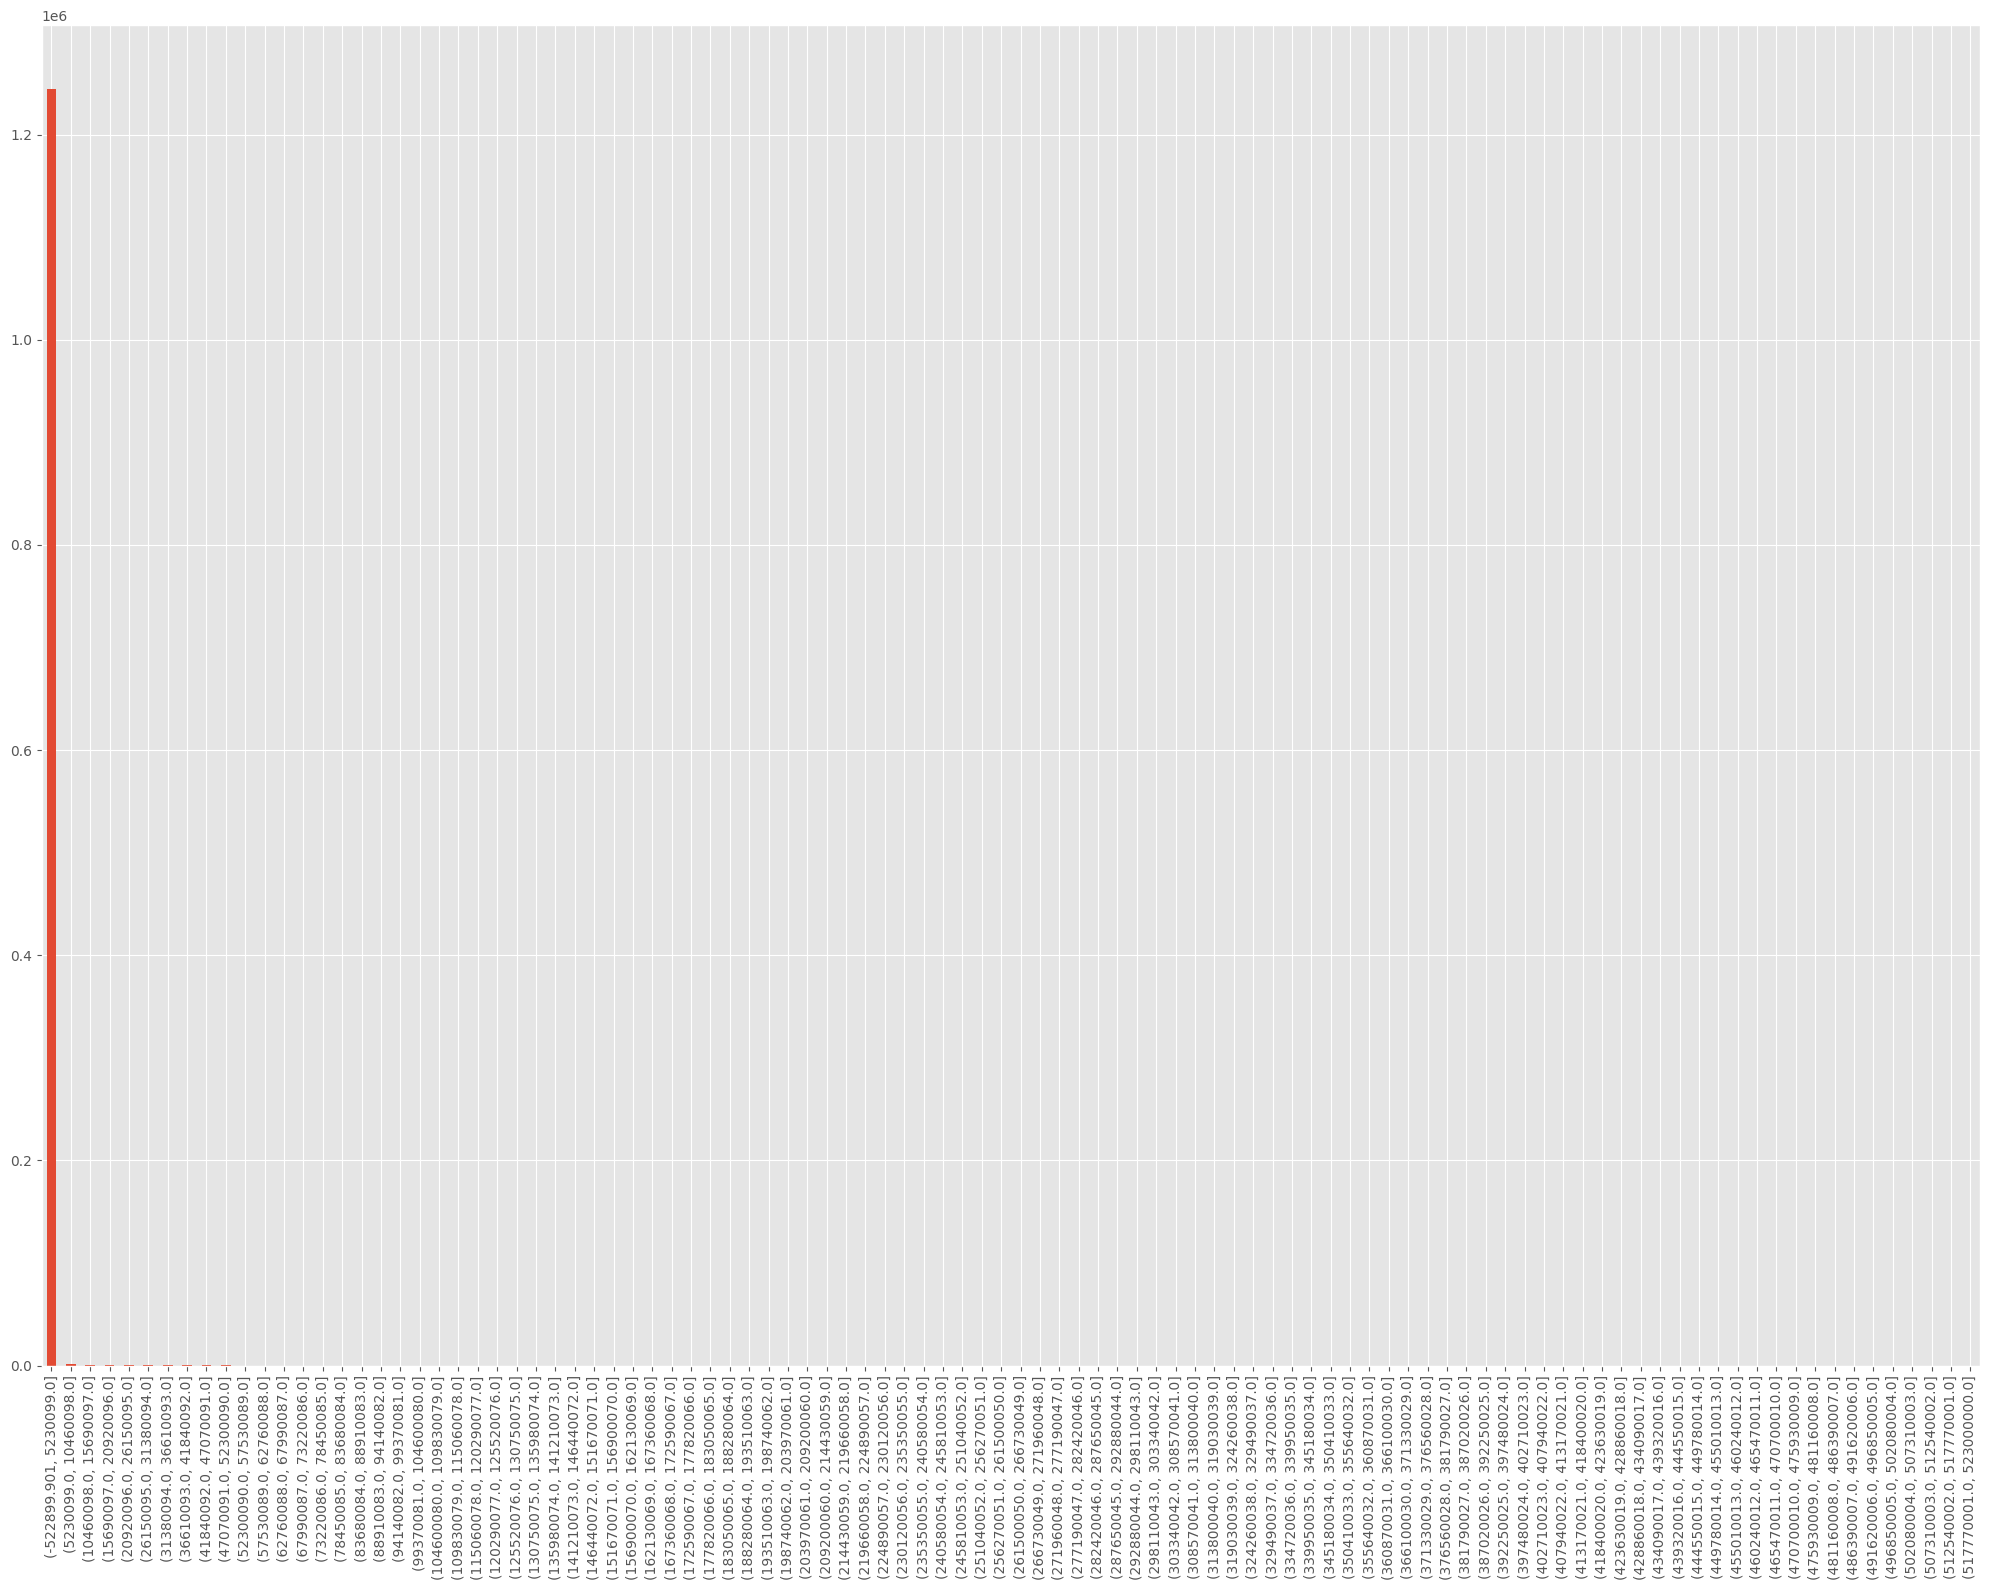

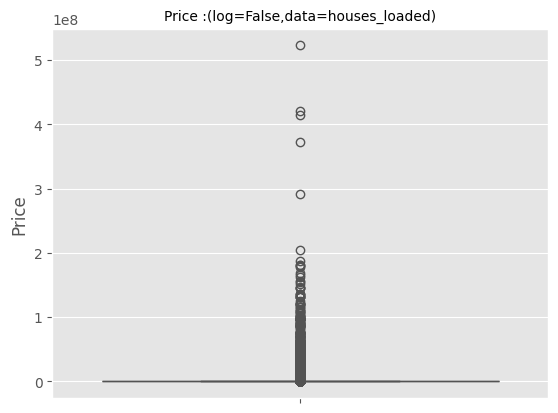

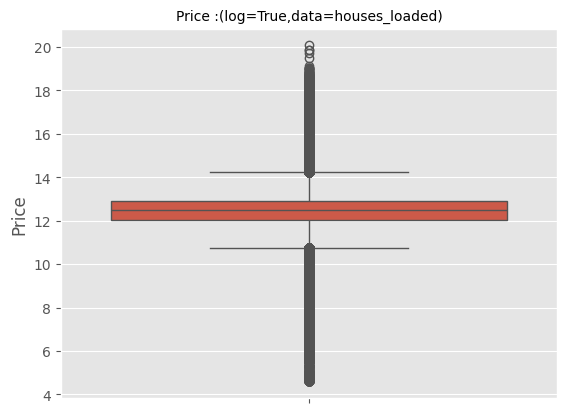

###################################################### PropertyType ######################################################


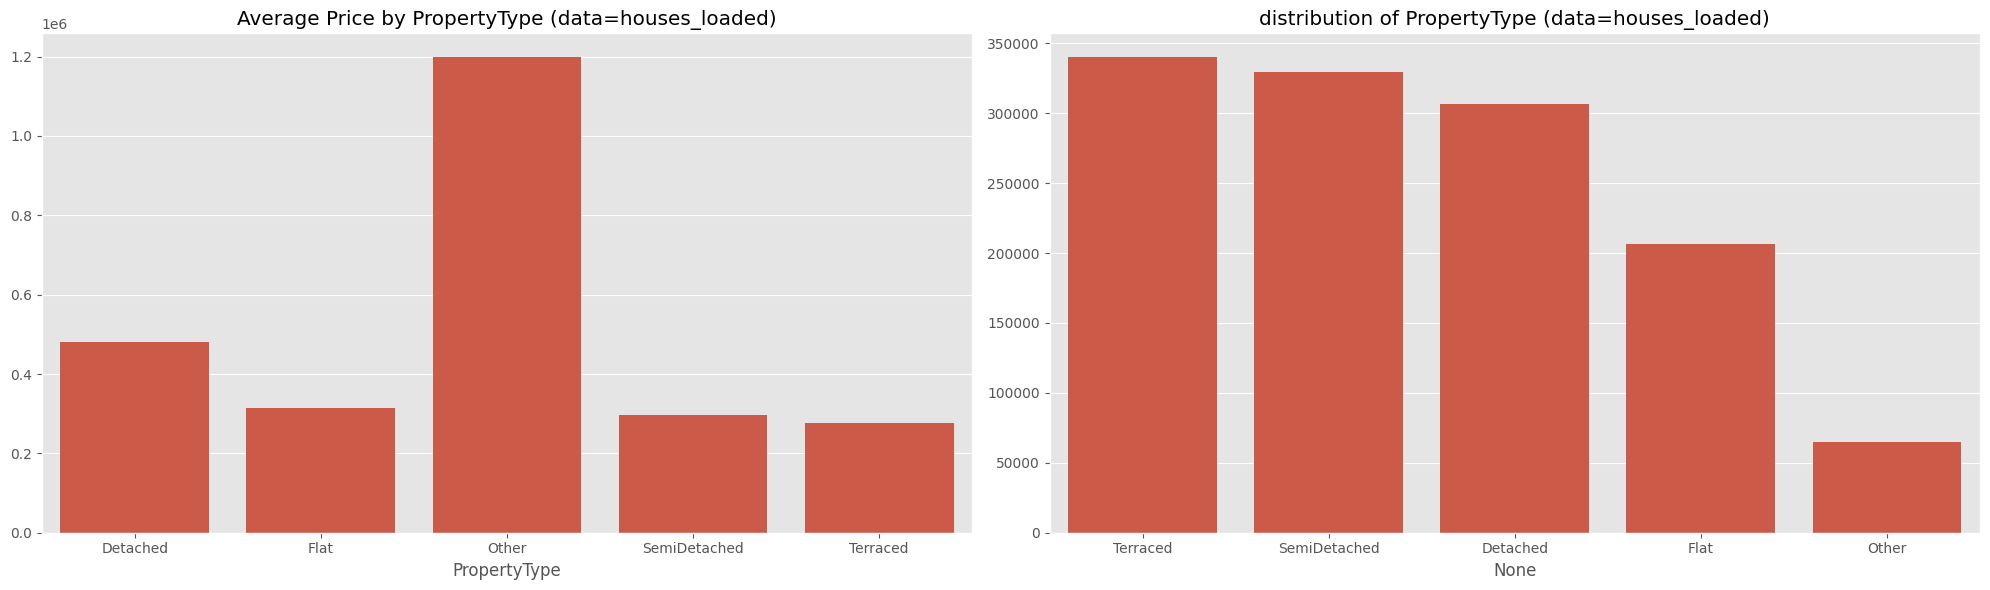

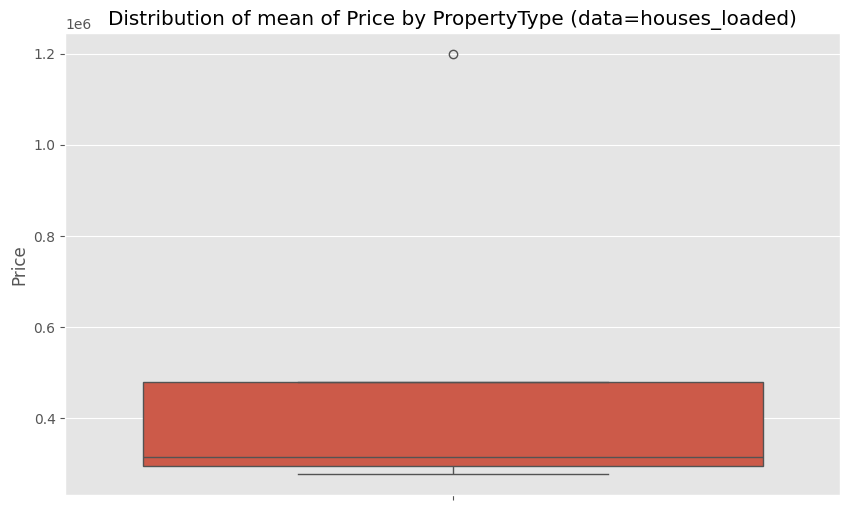

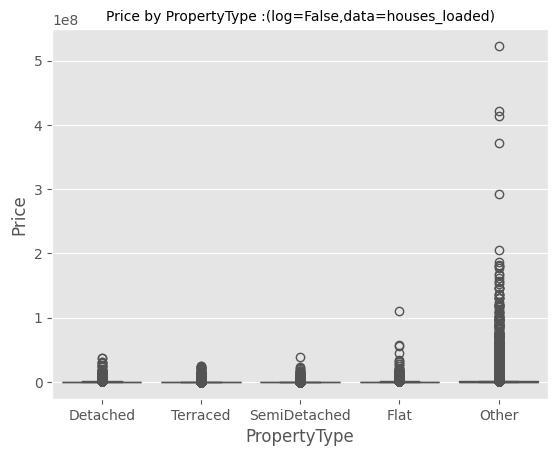

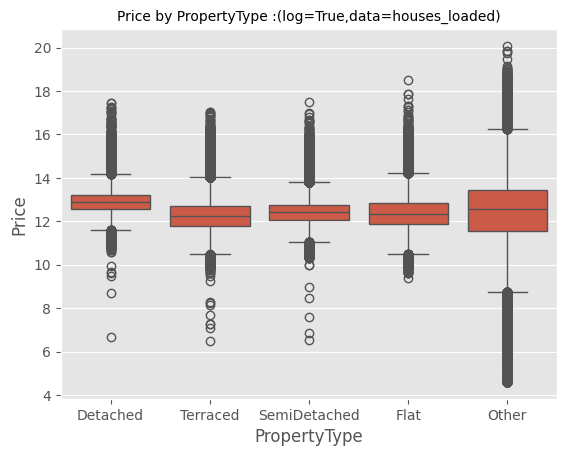

Terraced : (0,0)
SemiDetached : (0,1)
Detached : (1,0)
Flat : (1,1)
Other : (2,0)


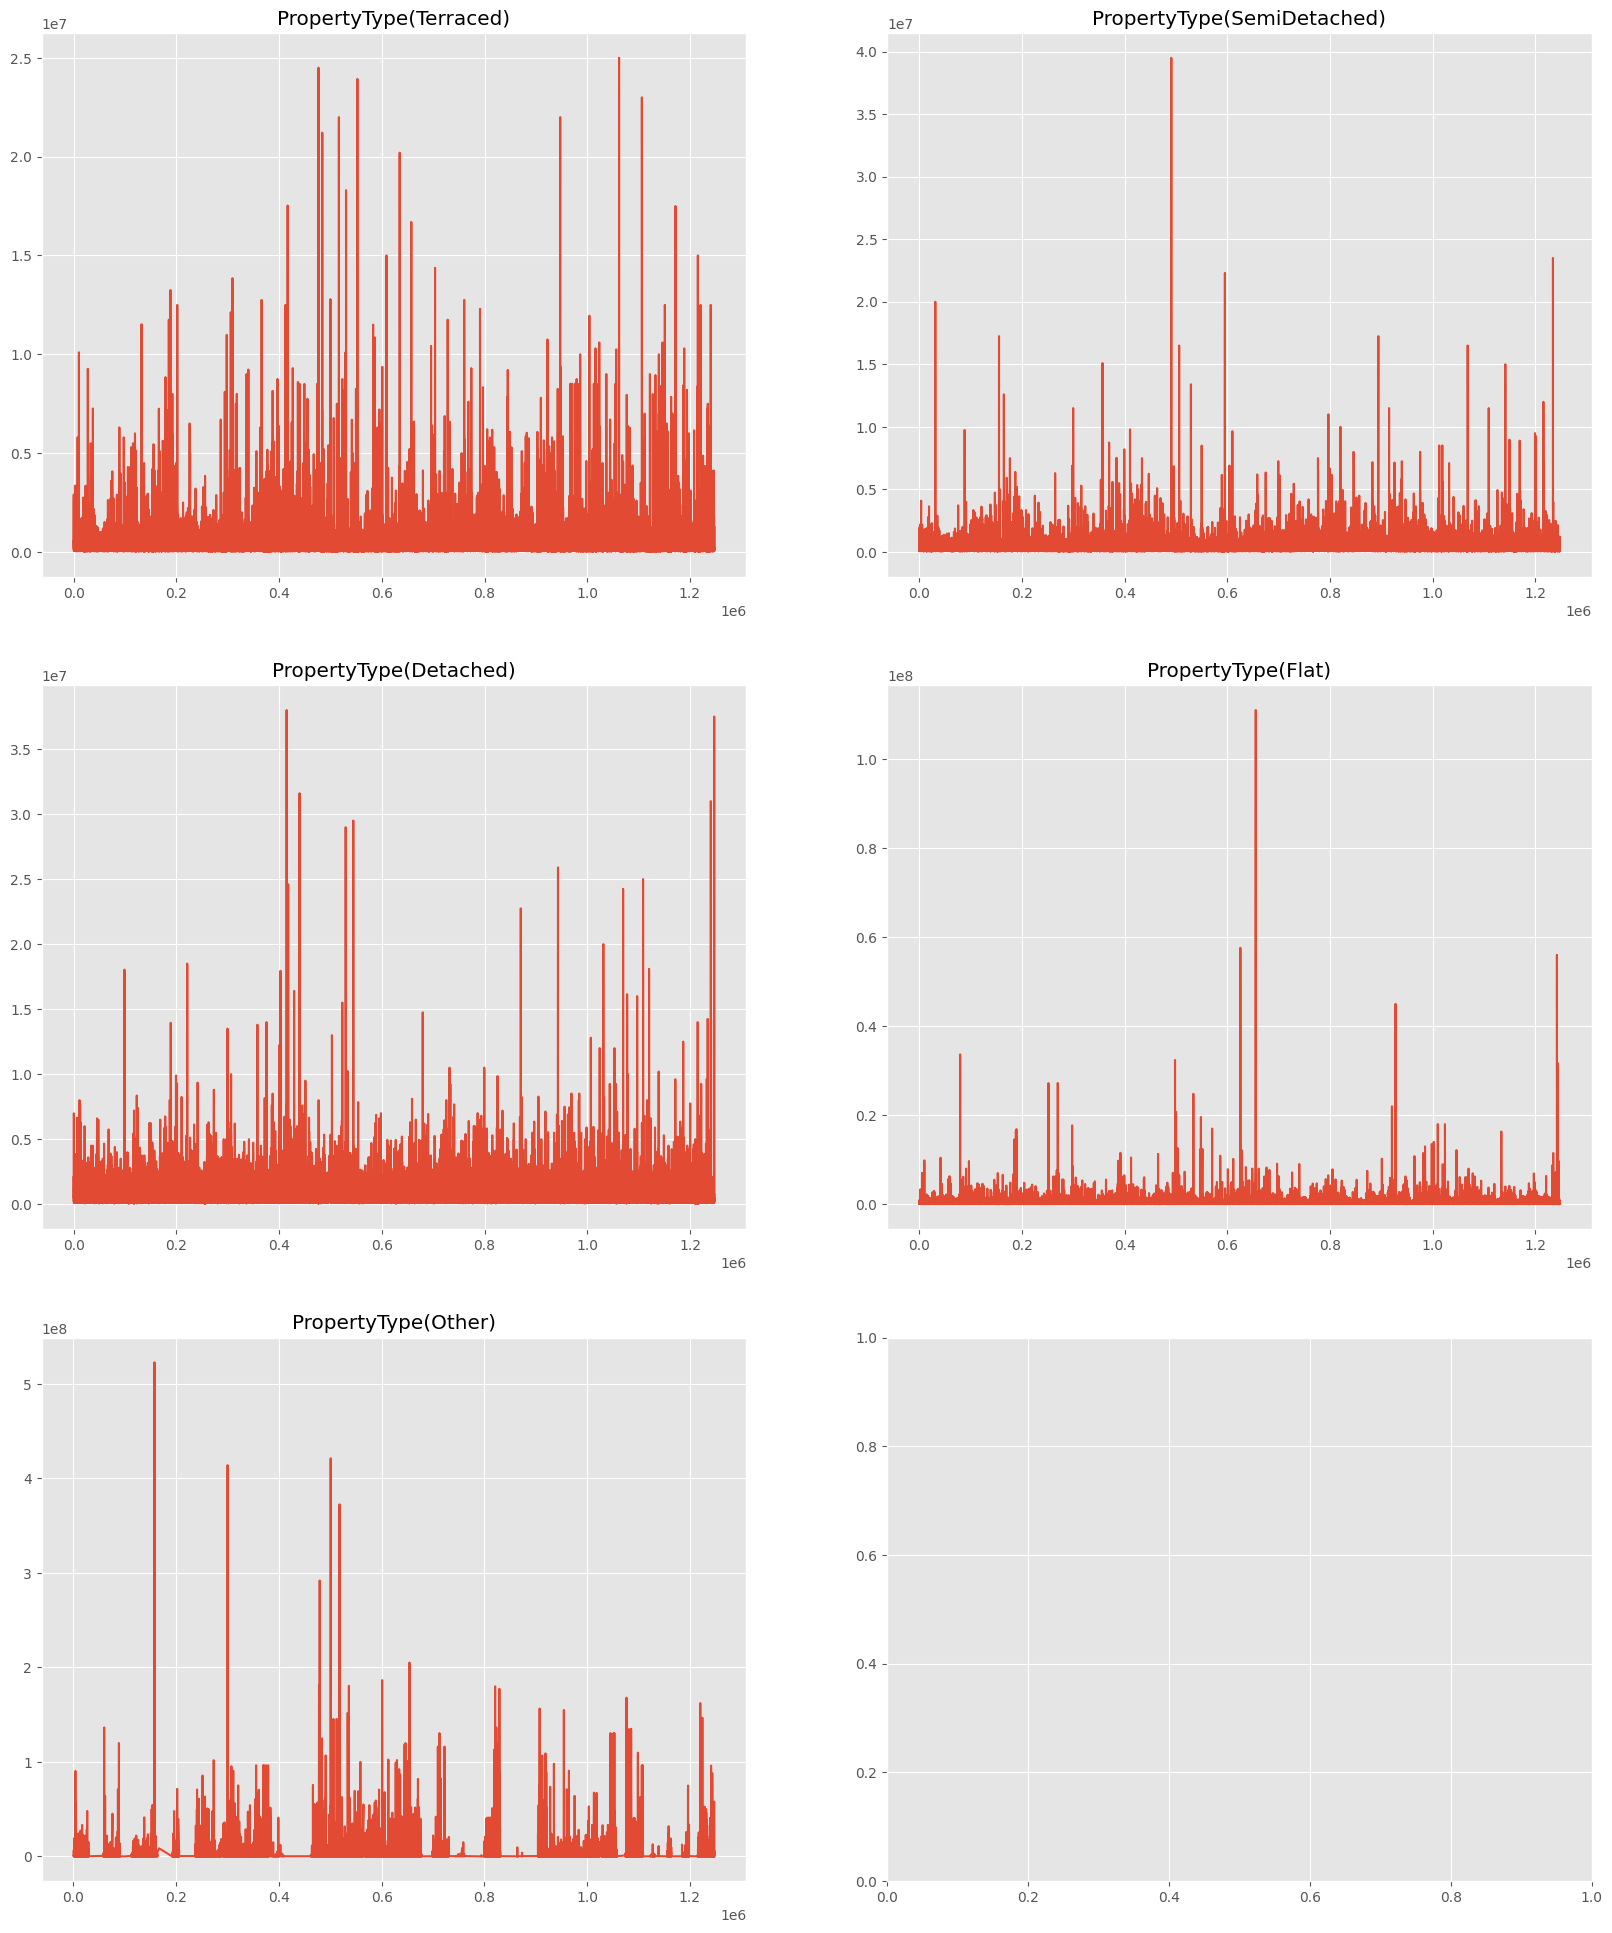

###################################################### Duration ######################################################


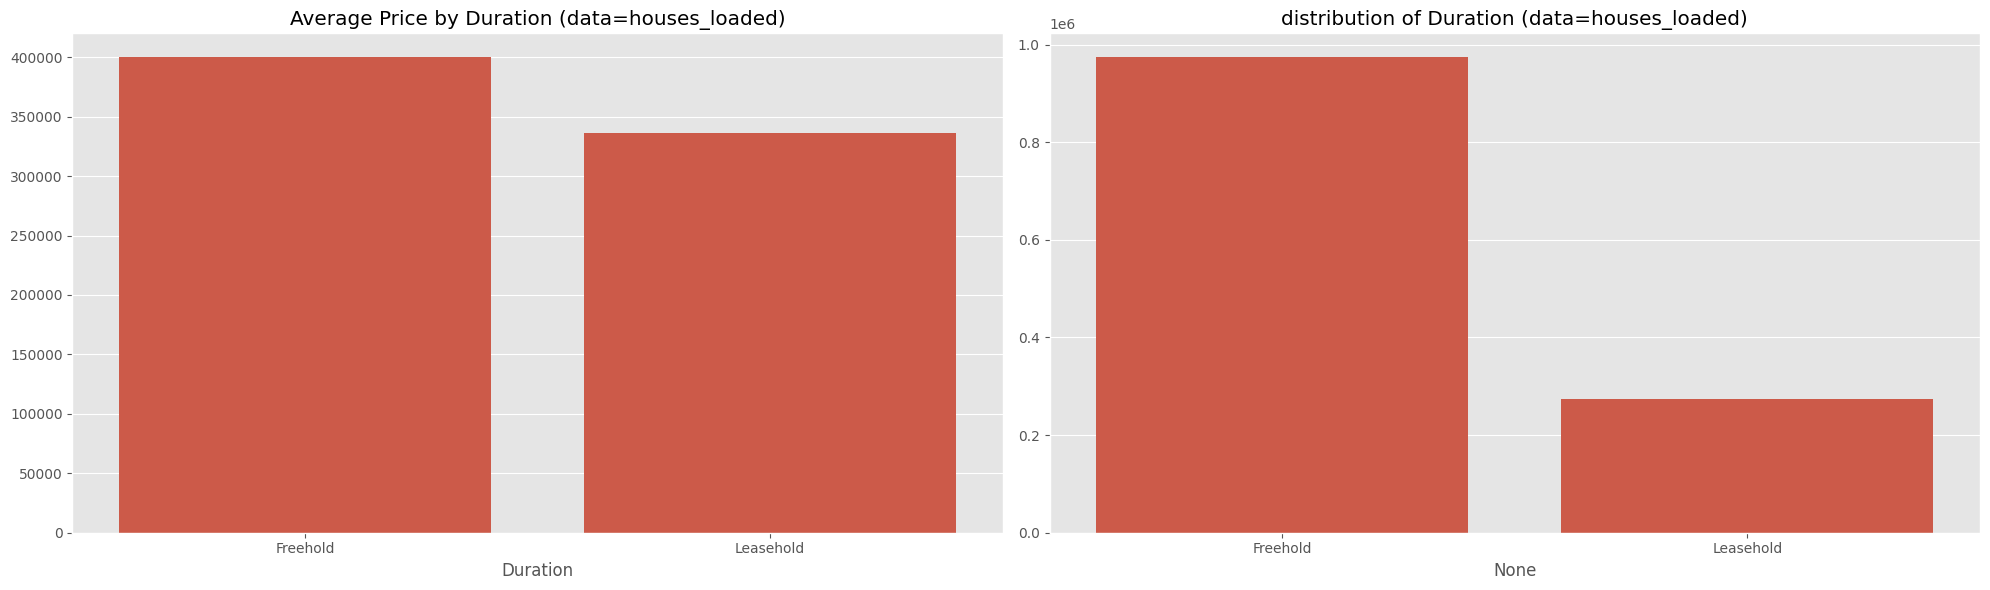

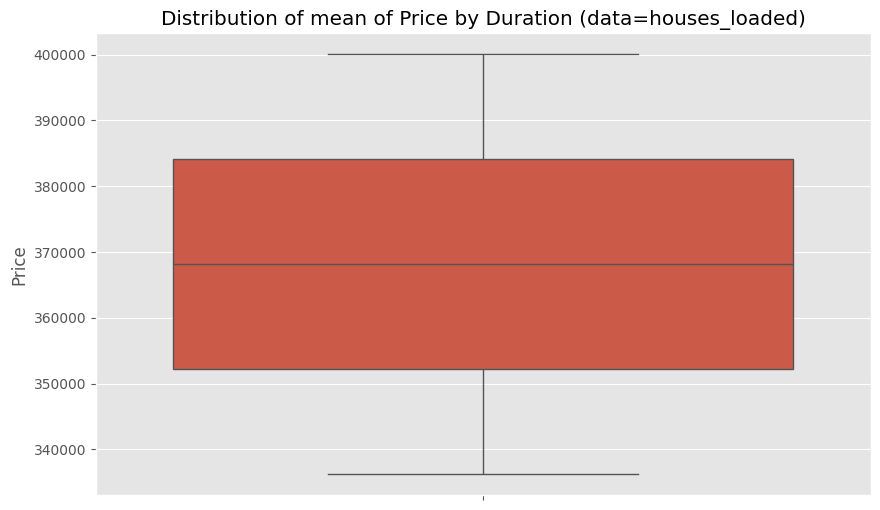

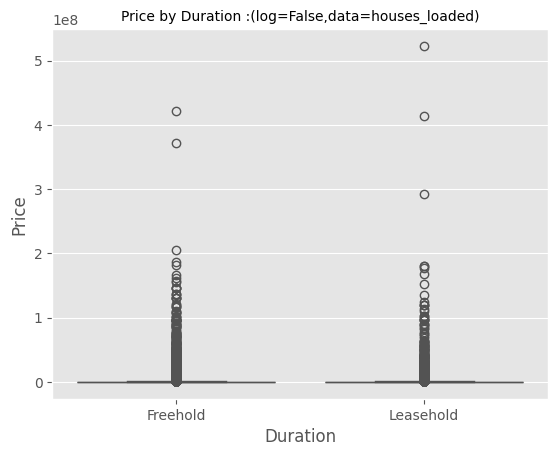

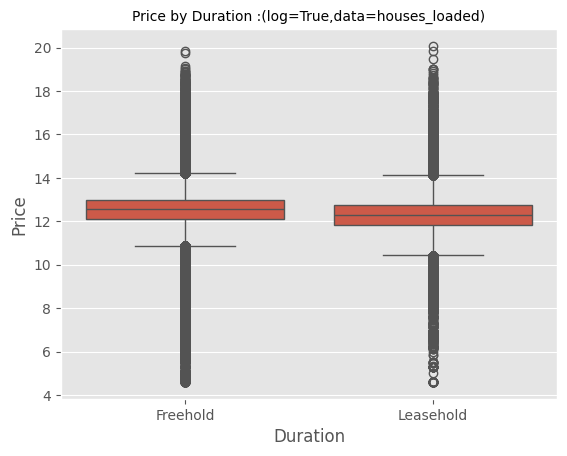

Freehold : (0,0)
Leasehold : (0,1)


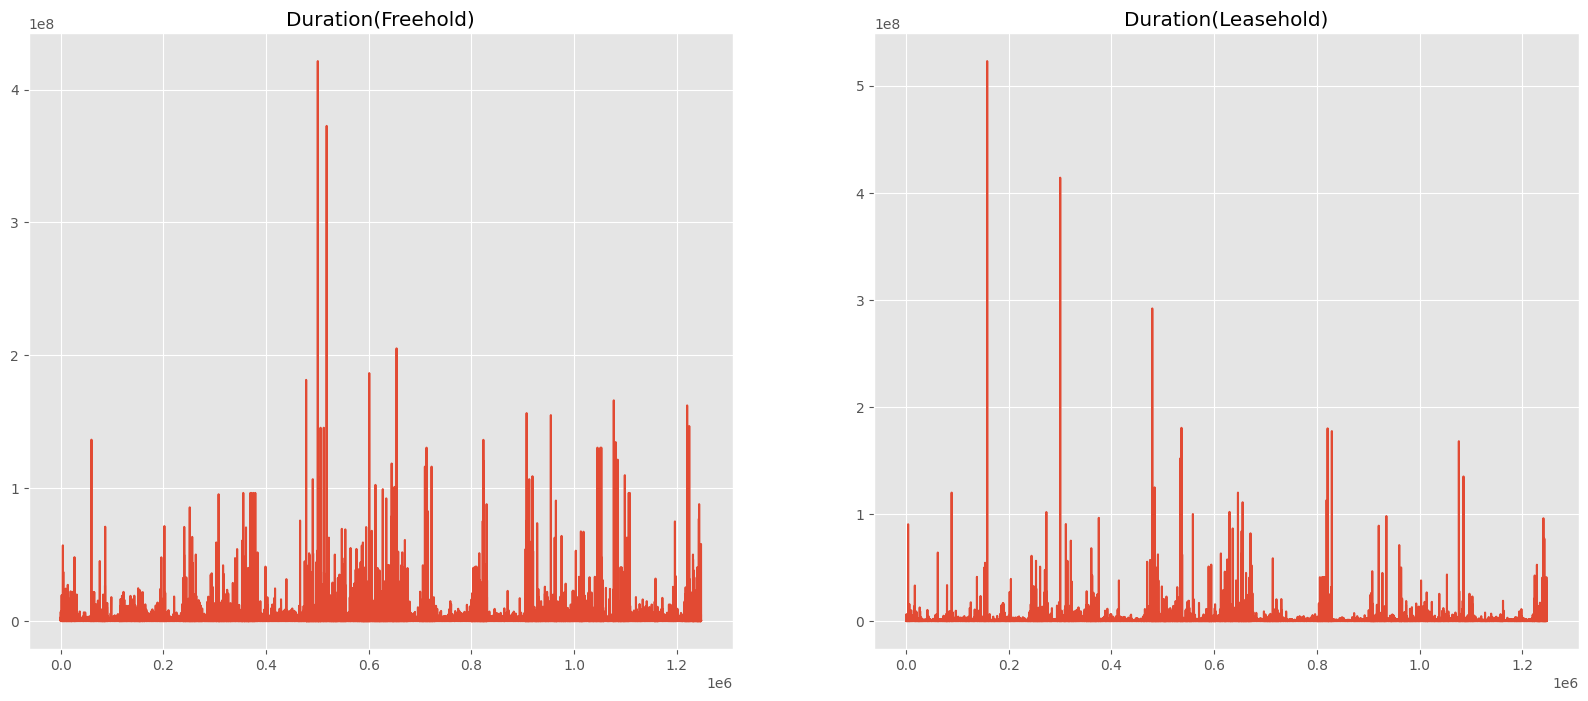

###################################################### OldNew ######################################################


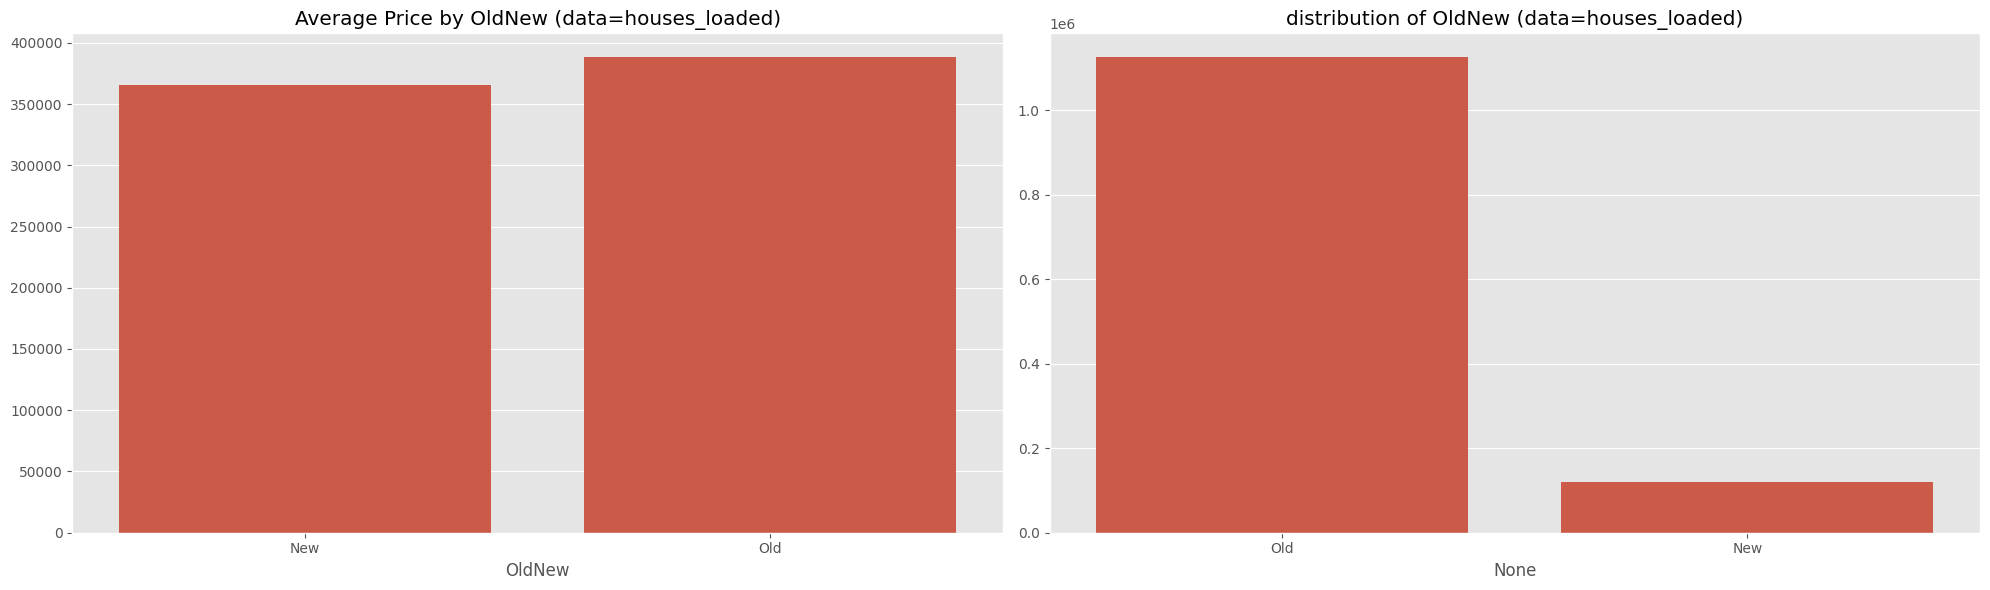

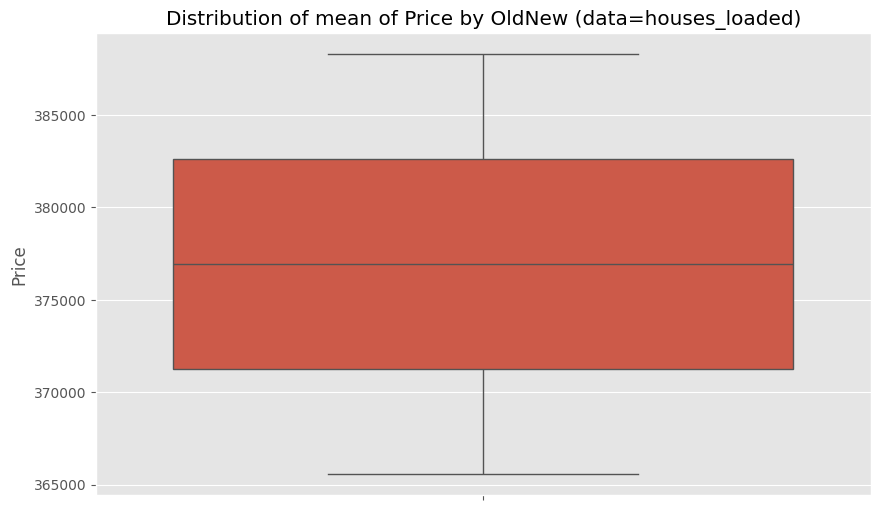

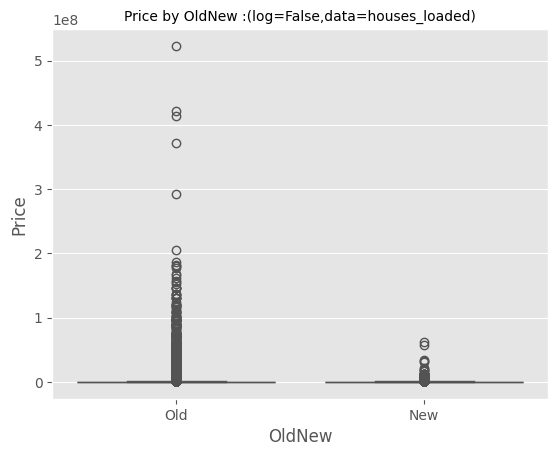

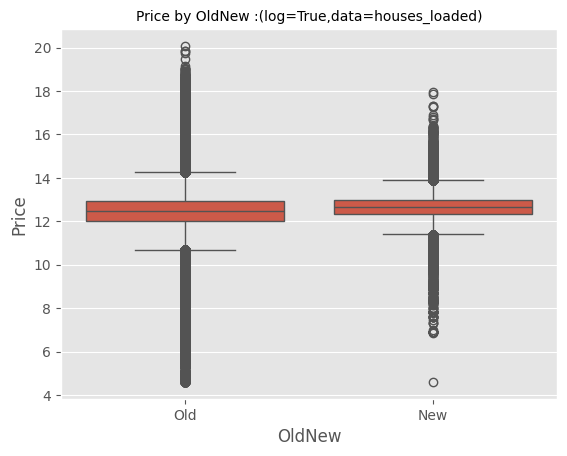

Old : (0,0)
New : (0,1)


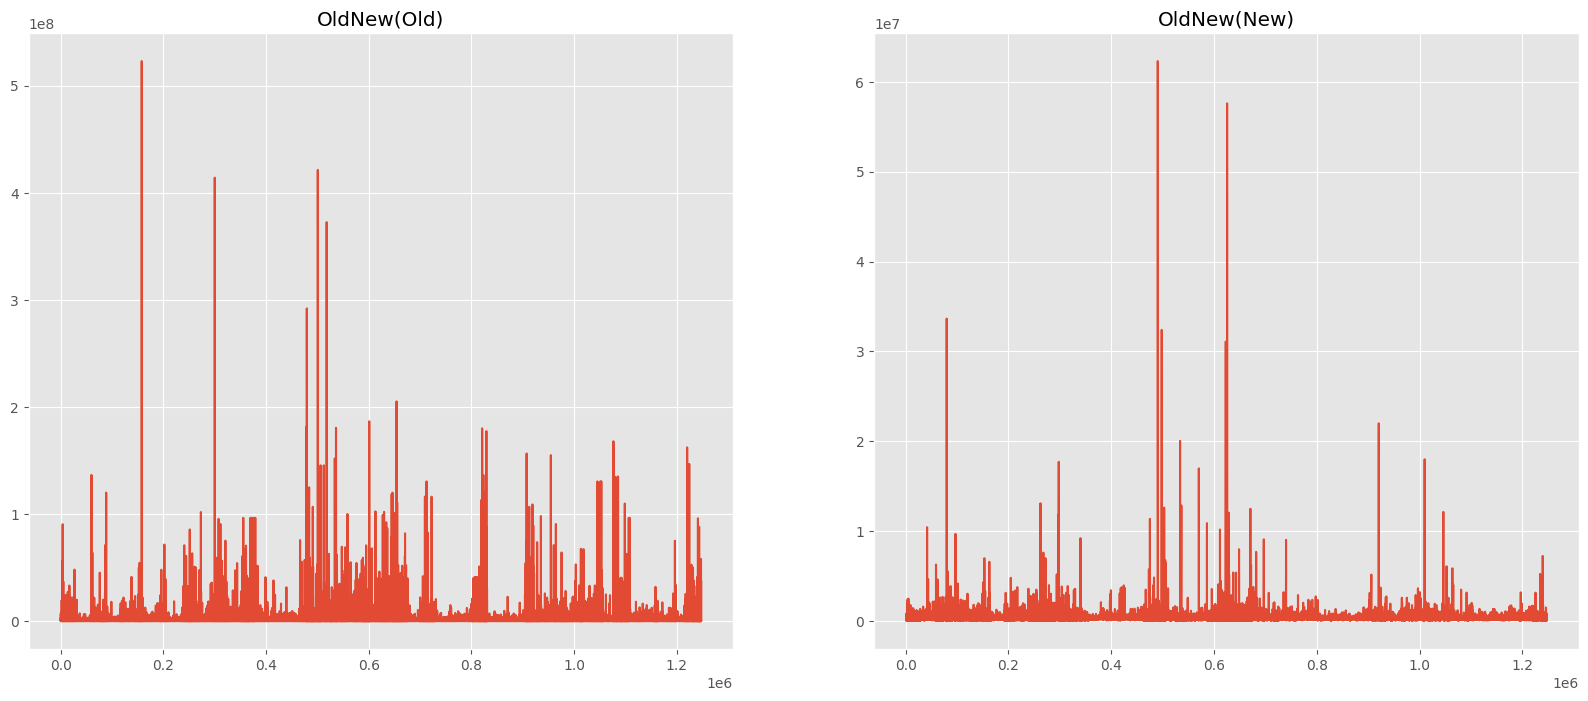

###################################################### County ######################################################


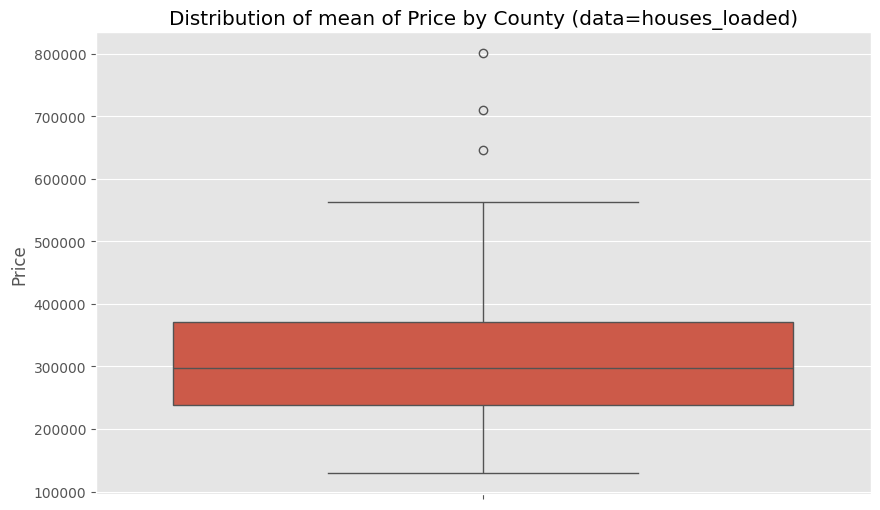

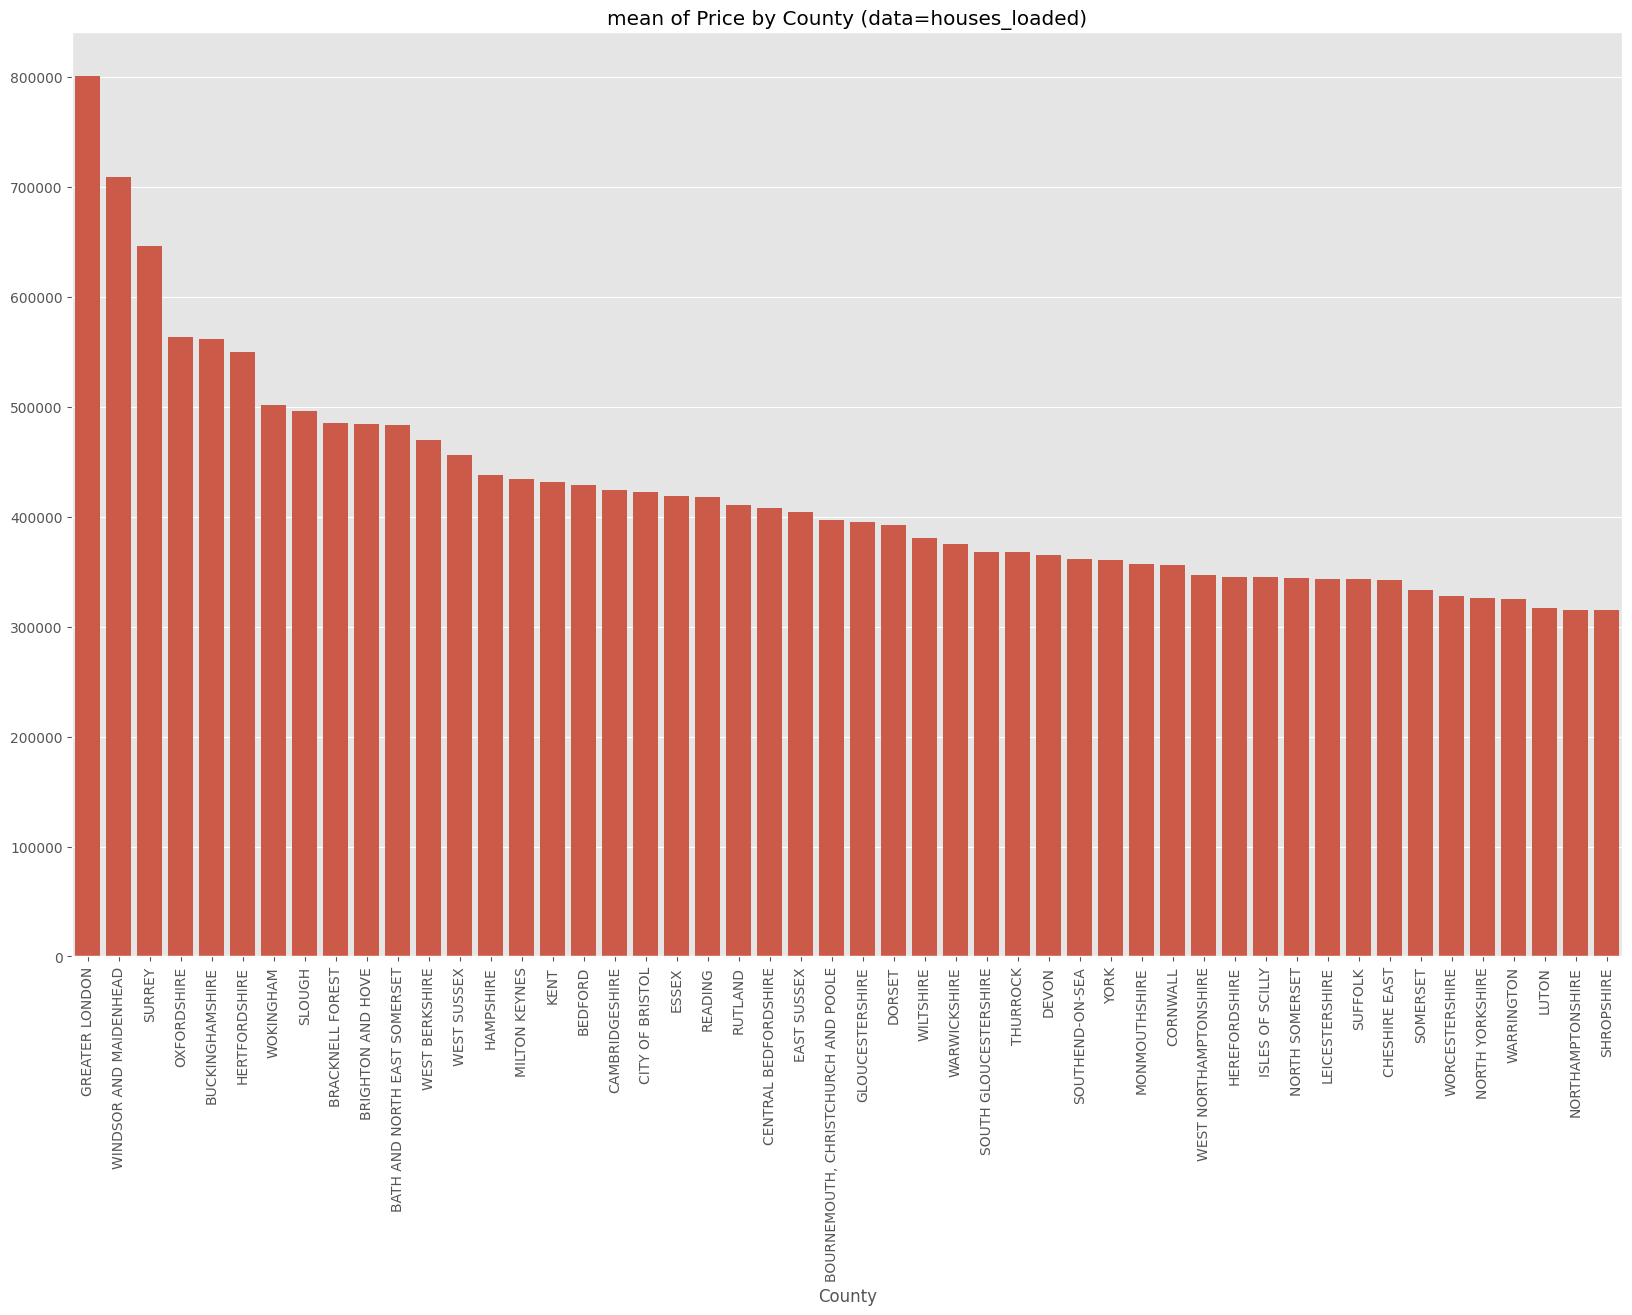

###################################################### District ######################################################


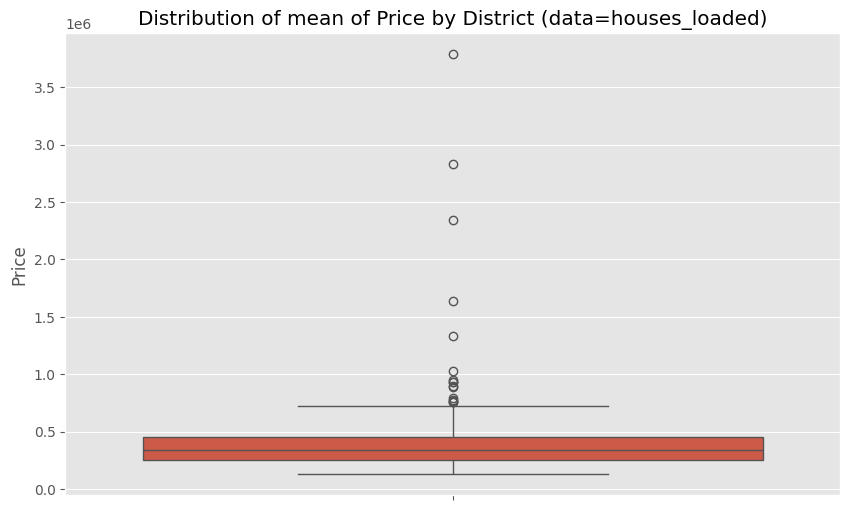

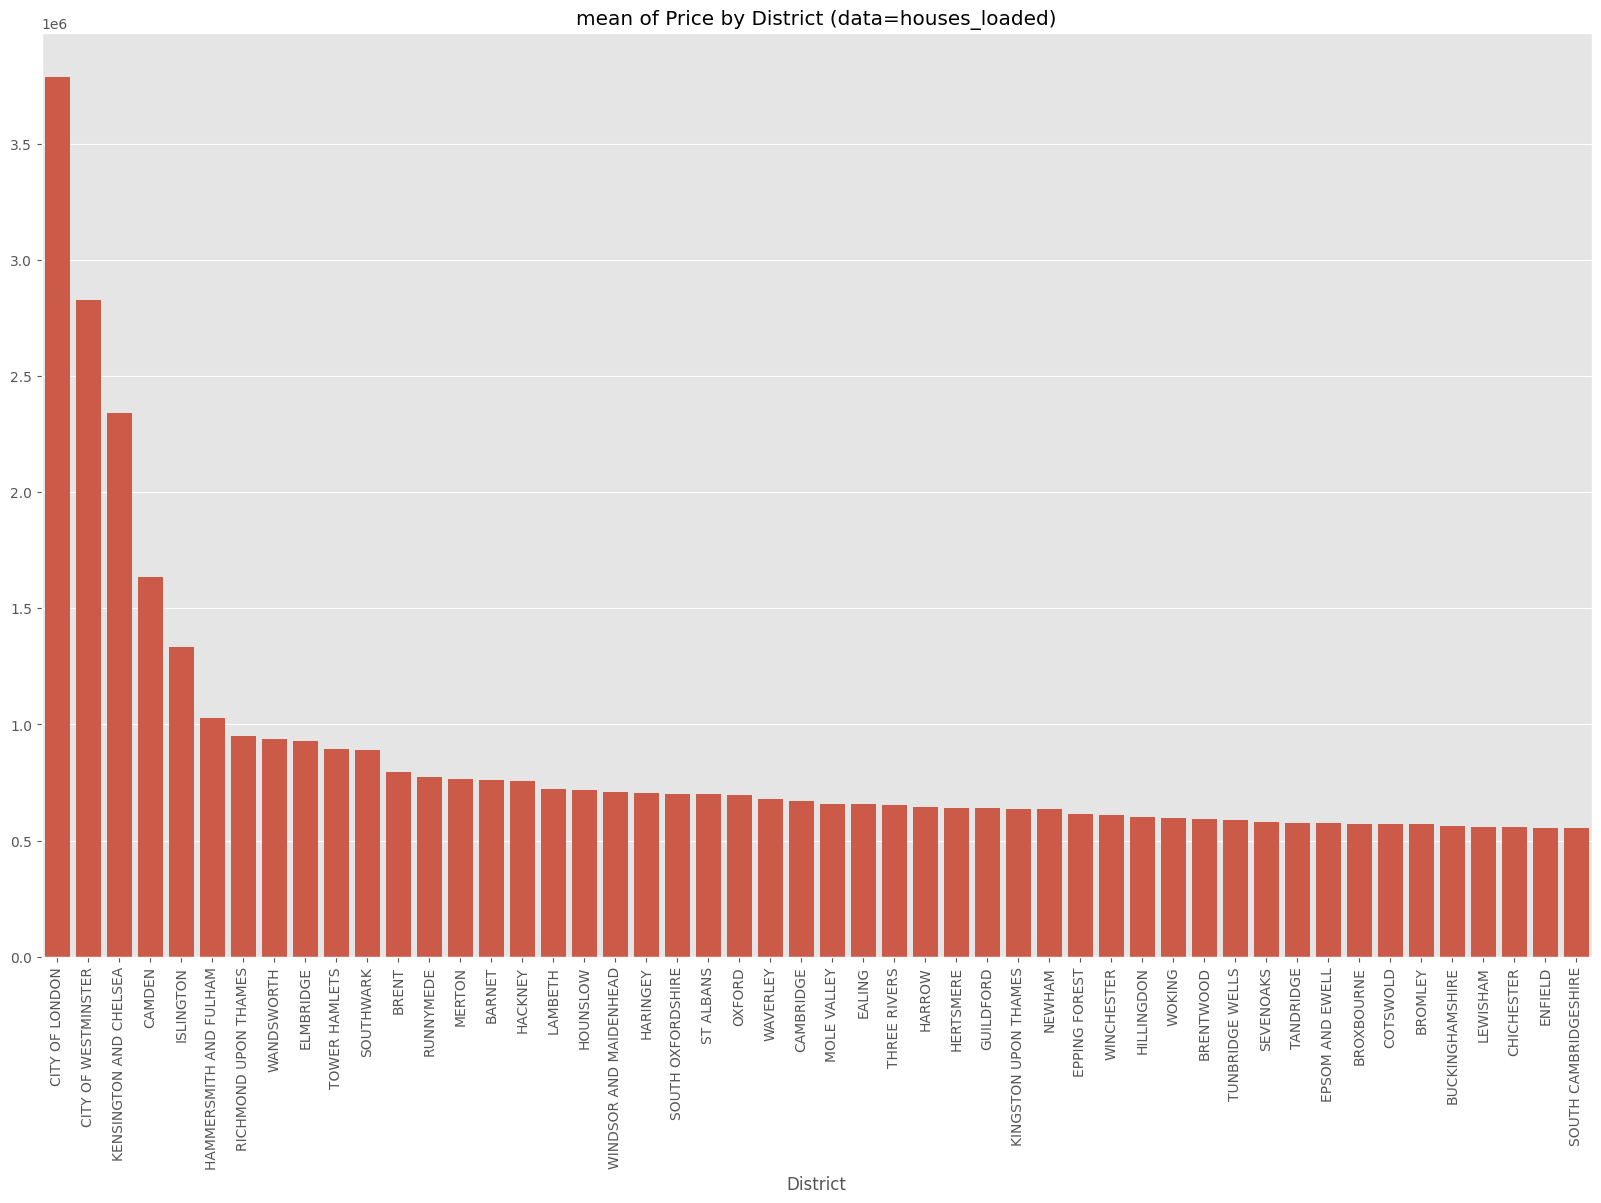

###################################################### TownCity ######################################################


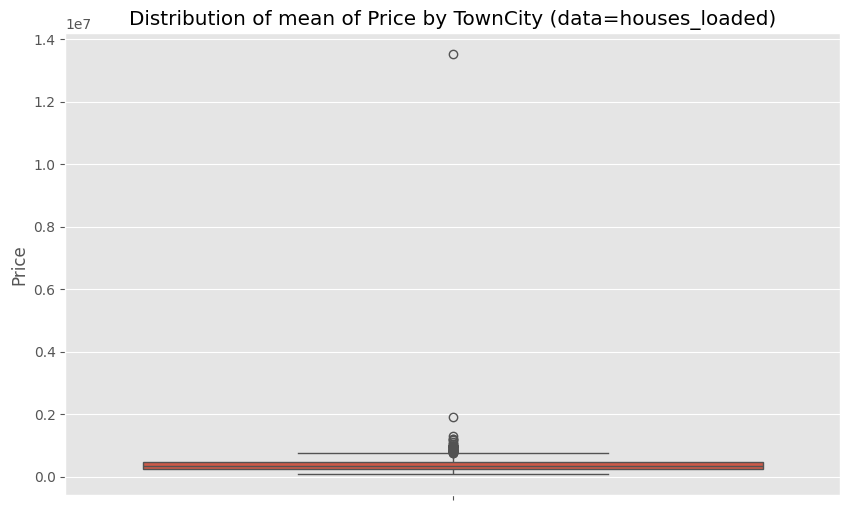

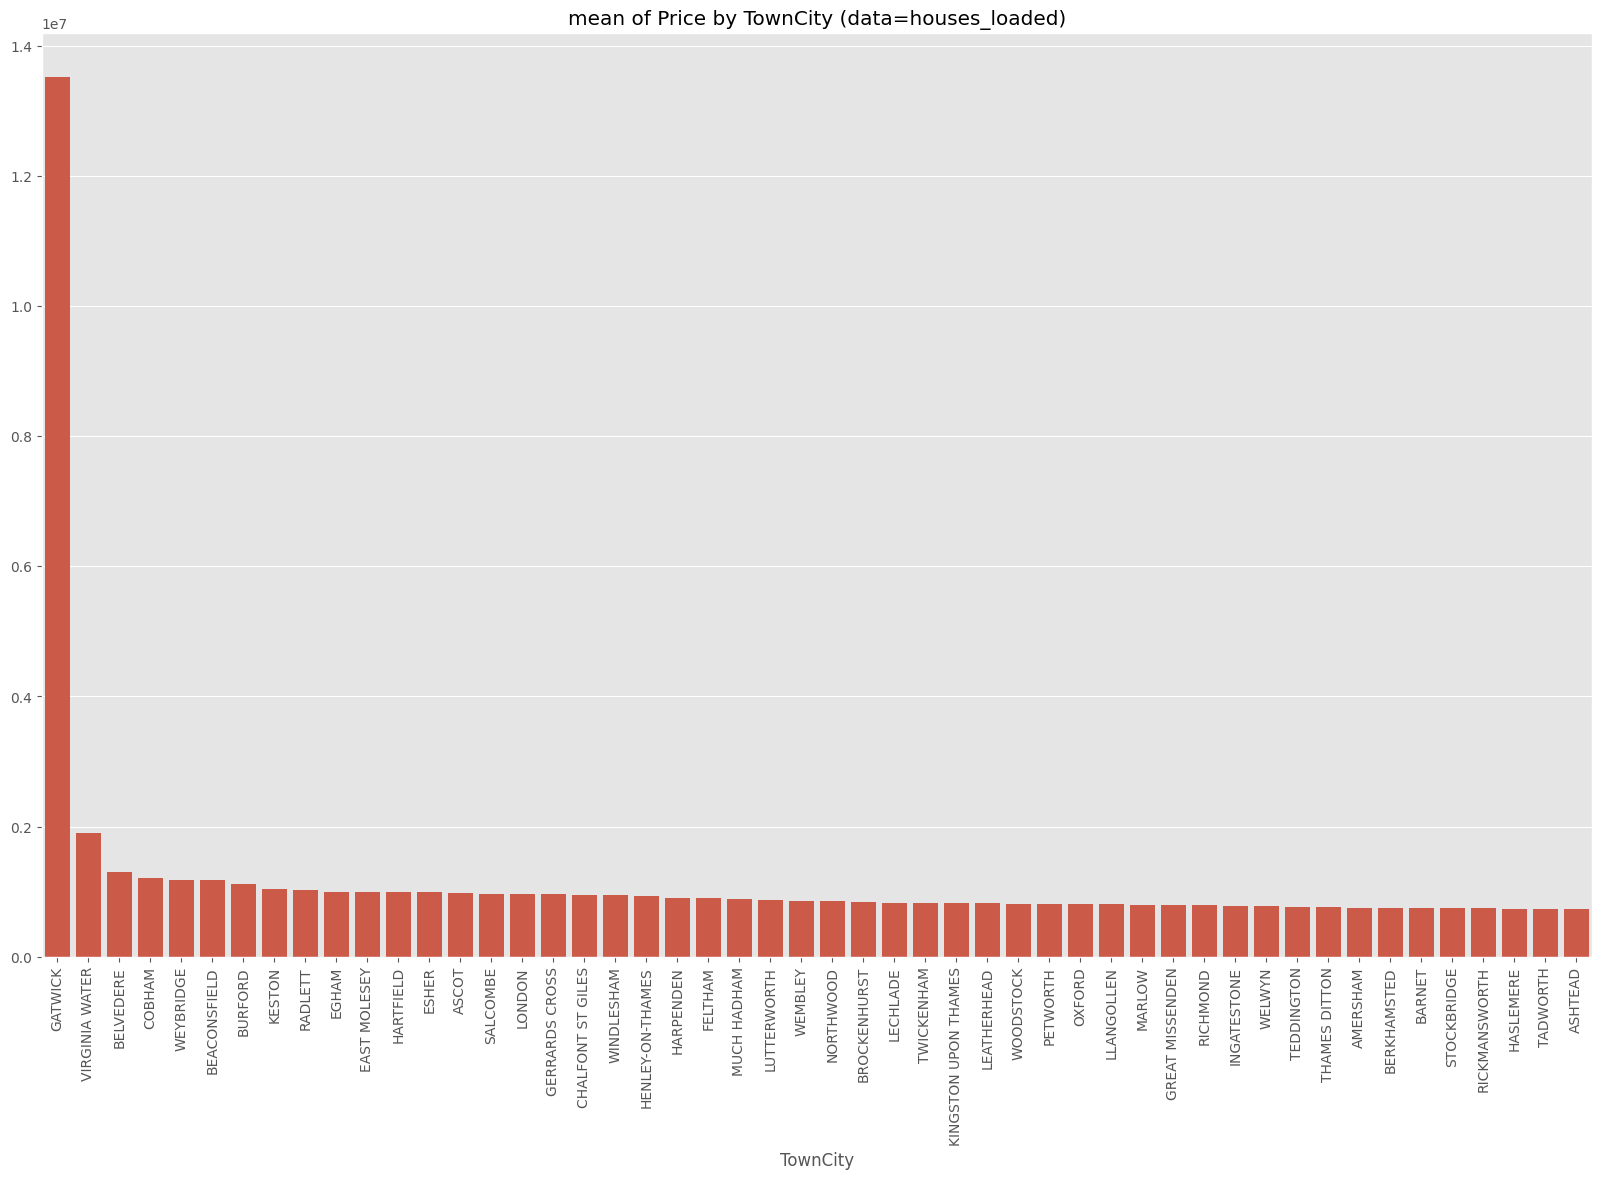

In [14]:
visualise_global(
    houses_loaded,
    grp_columns = ["PropertyType","Duration","OldNew"],
    geo_col = ["County","District","TownCity"]
)

# Preprocessing

### PostcodeArea

In [15]:
regex_postcode = r'(\S+)'     #r'([a-z]+)'
houses_loaded['PostcodeArea'] = houses_loaded.Postcode.str.extract(regex_postcode,flags=re.I)

In [16]:
mask_pc = houses_loaded.PostcodeArea.isna()
town_city_PostCodesArea = houses_loaded.groupby('TownCity')["PostcodeArea"].apply(lambda x:pd.Series(list(set(x))).dropna().tolist()[0])
houses_loaded.loc[mask_pc,'PostcodeArea']= houses_loaded.loc[(mask_pc),['PostcodeArea',"TownCity"]].apply(lambda x:town_city_PostCodesArea[x["TownCity"]],axis=1)

In [17]:
houses_loaded.PostcodeArea.value_counts(dropna=True)

E14     3007
CR0     2579
BN3     2084
BN1     1971
SW11    1968
        ... 
NP9        1
LL1        1
PE17       1
SN38       1
EC2V       1
Name: PostcodeArea, Length: 2303, dtype: int64

### normal_PriceWise_houses && expensive_PriceWise_houses

- 'logoutlierfence' is declared in "introduction" section

#### Outlier Treatement

In [18]:
houses_loaded.Price.describe()

count    1.247338e+06
mean     3.860864e+05
std      1.558737e+06
min      1.000000e+02
25%      1.720000e+05
50%      2.690000e+05
75%      4.125000e+05
max      5.230000e+08
Name: Price, dtype: float64

In [22]:
normal_PriceWise_houses = houses_loaded.copy()
for i in range(classify_outliers_cycle):
    classified_houses = classify_outliers(
        df_data=normal_PriceWise_houses,
        colname='Price',
        by_log = logoutlierfence
    )
    expensive_PriceWise_houses = classified_houses["expensive_PriceWise_df"]
    normal_PriceWise_houses = classified_houses["normal_PriceWise_df"]
    logoutlierfence = not logoutlierfence

#### Visualization

###################################################### Price ######################################################


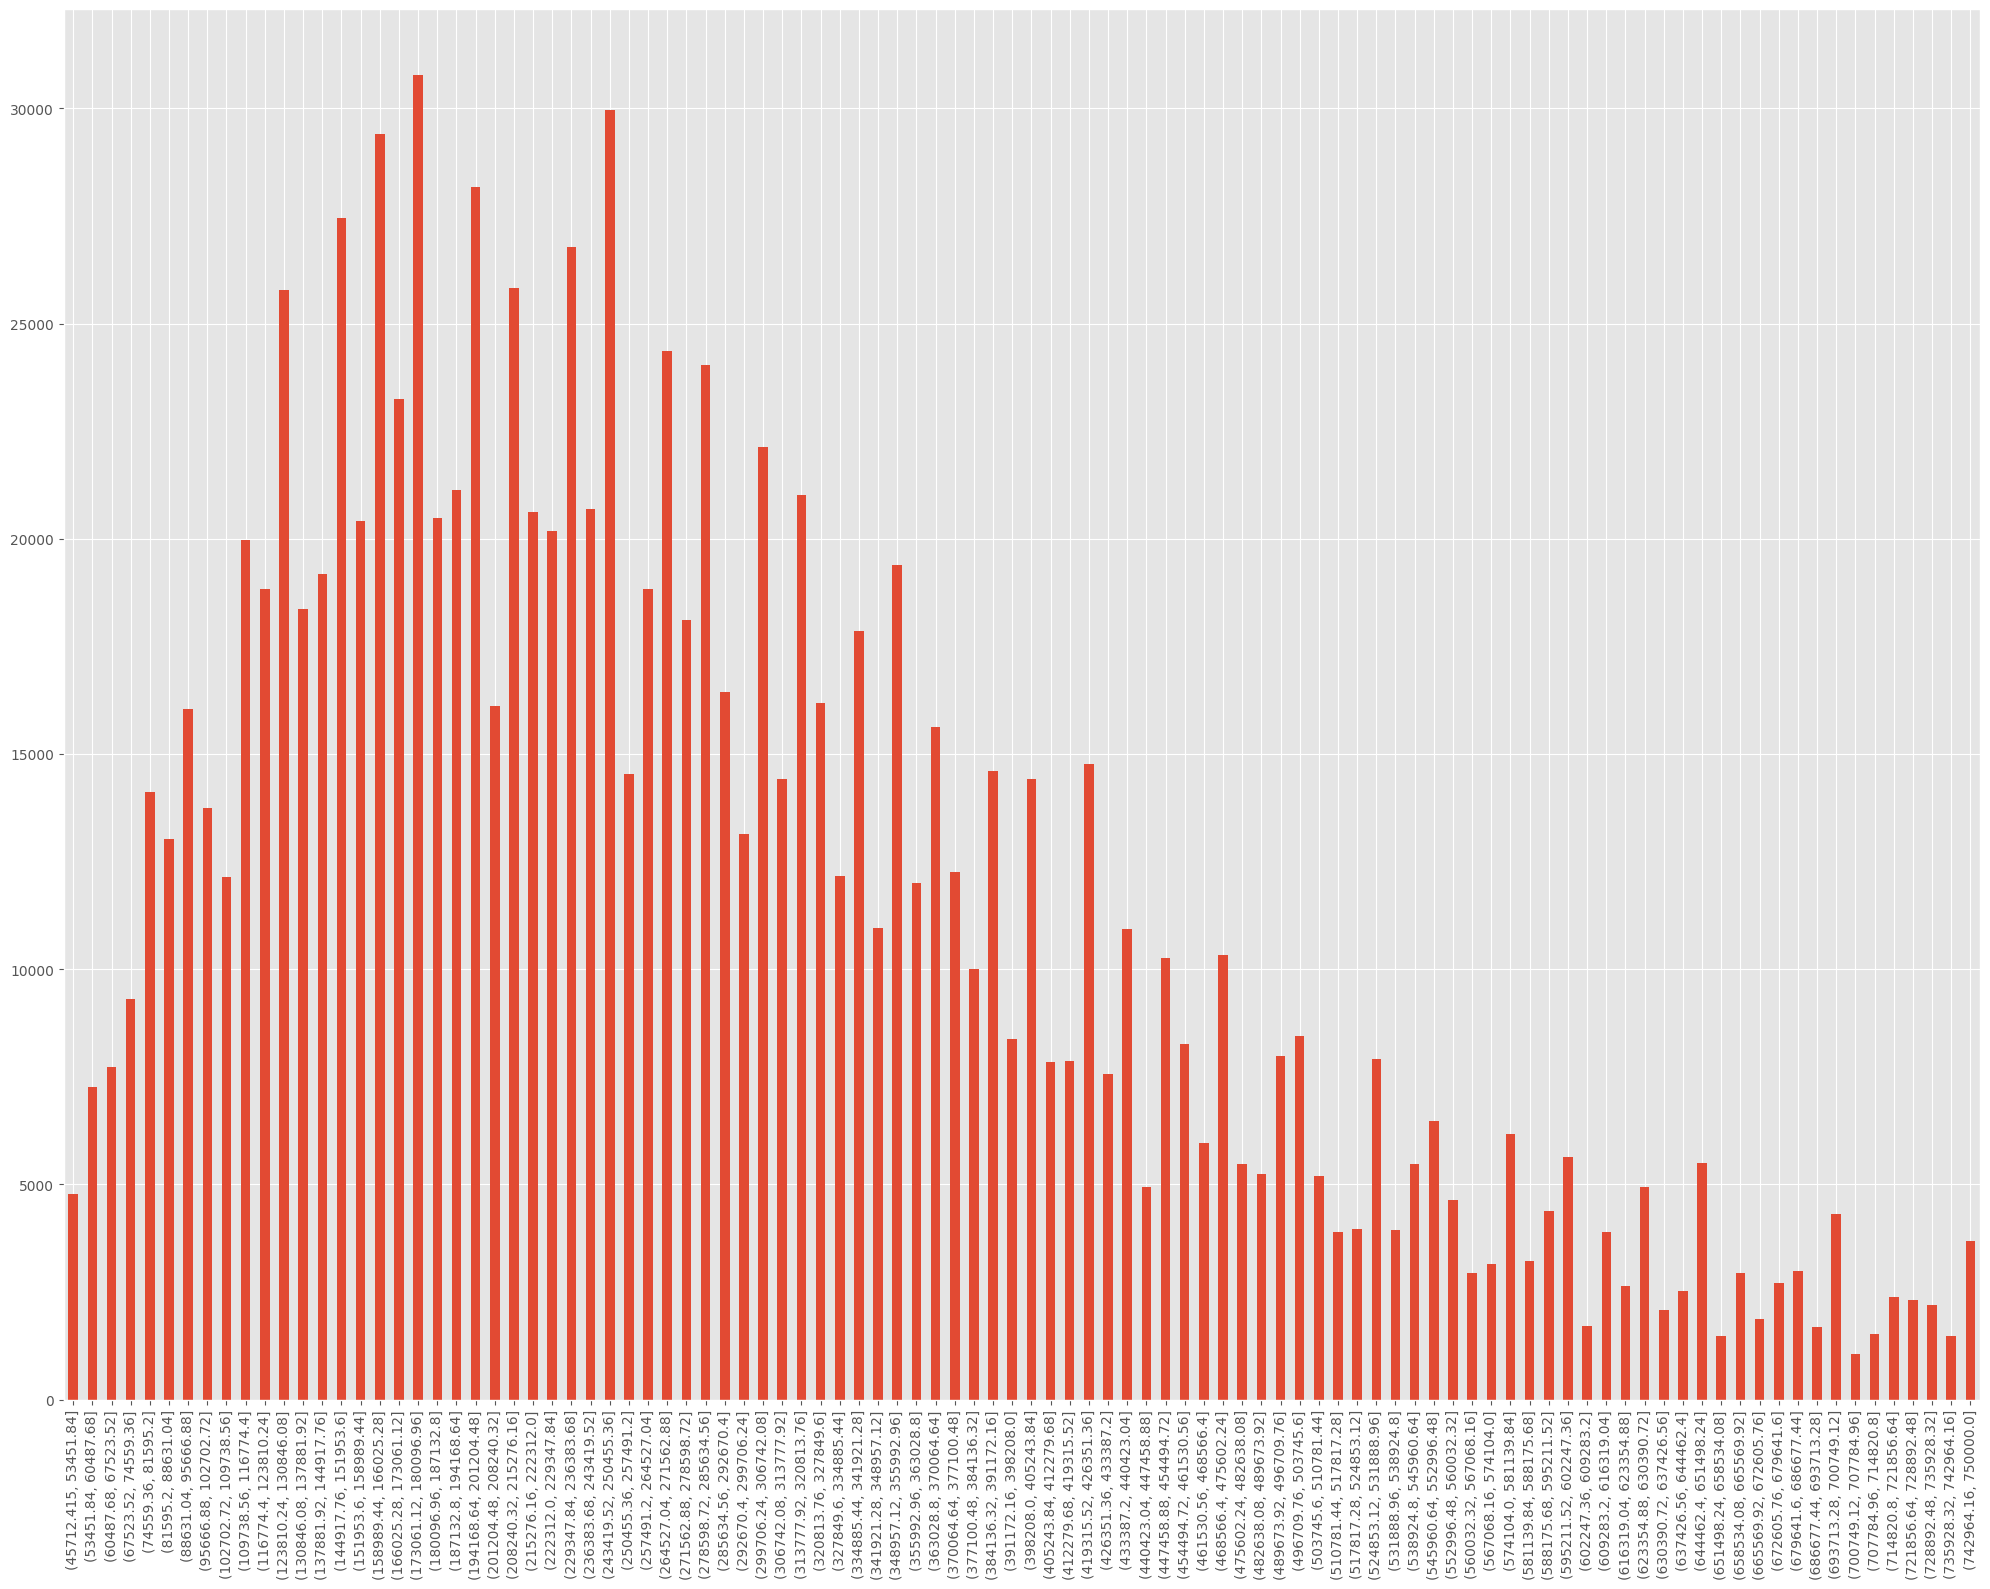

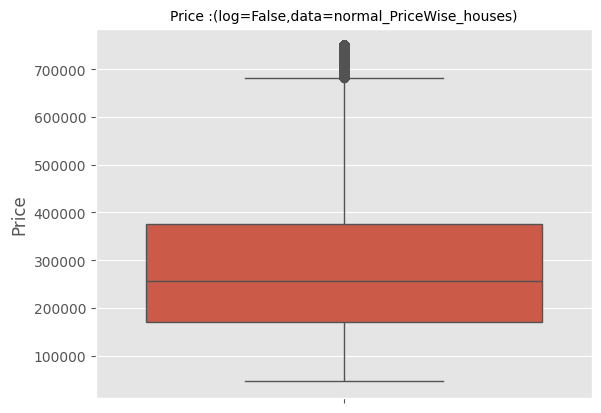

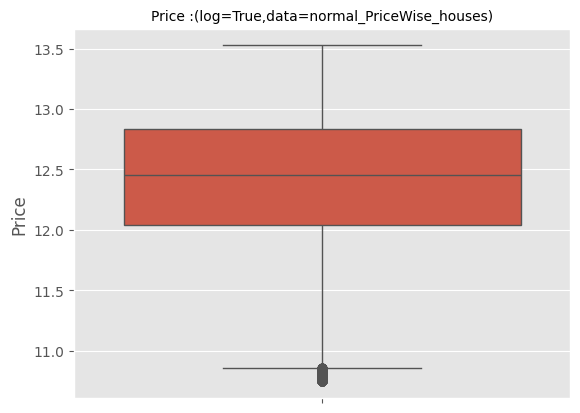

###################################################### PropertyType ######################################################


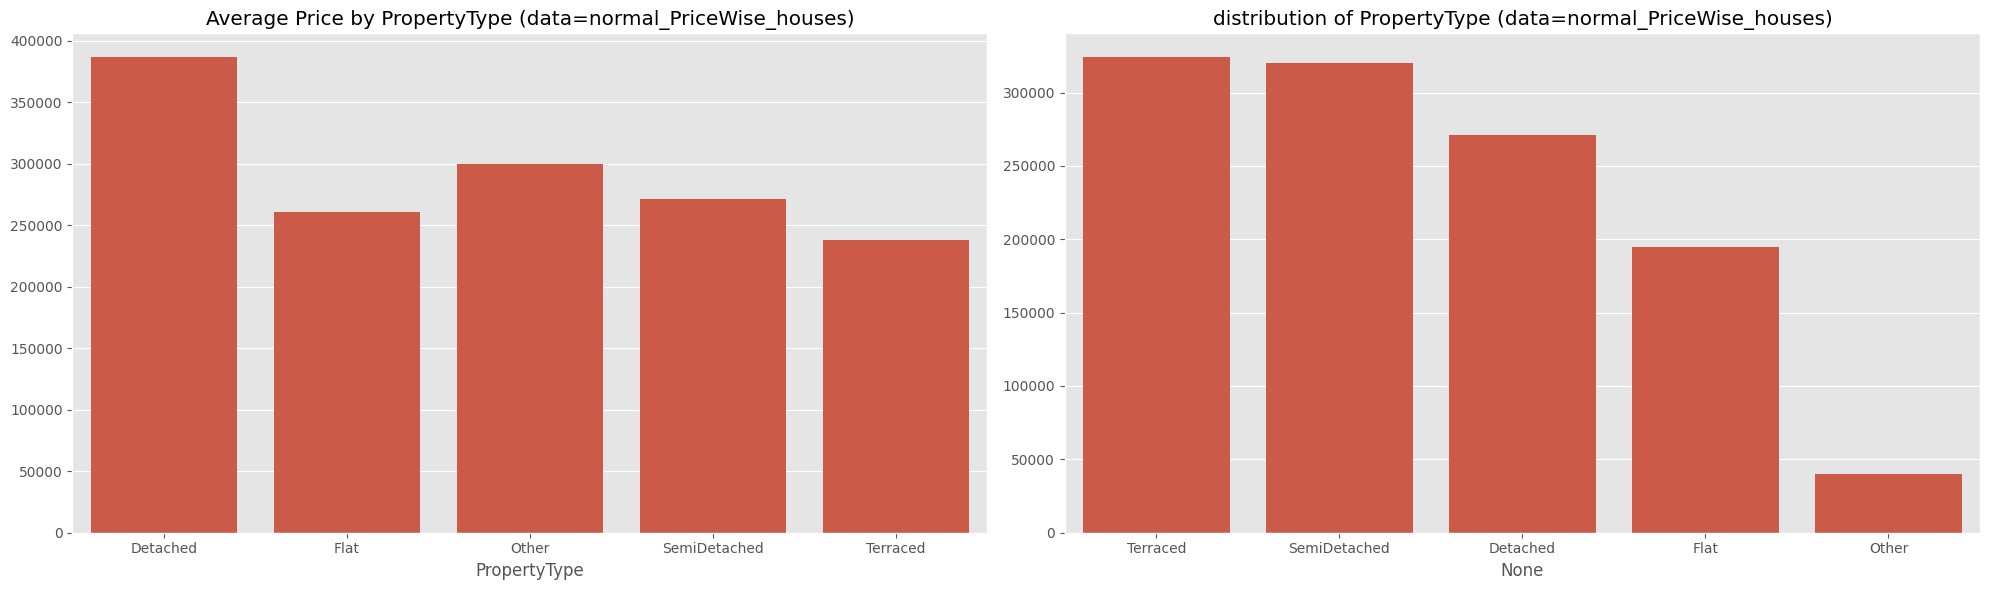

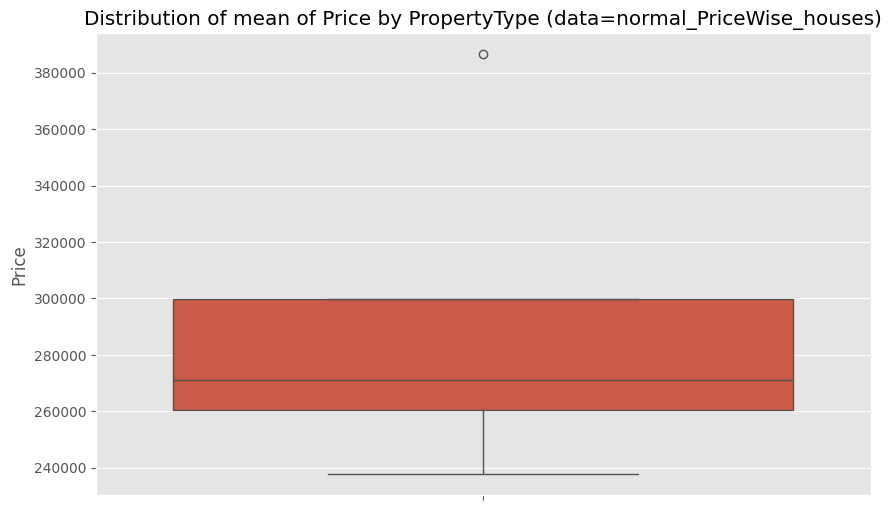

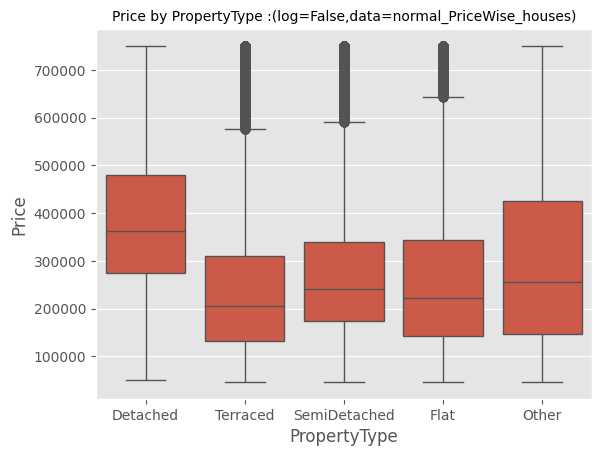

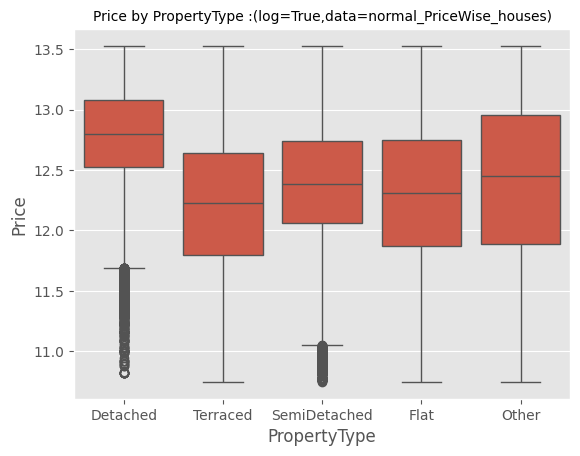

Terraced : (0,0)
SemiDetached : (0,1)
Detached : (1,0)
Flat : (1,1)
Other : (2,0)


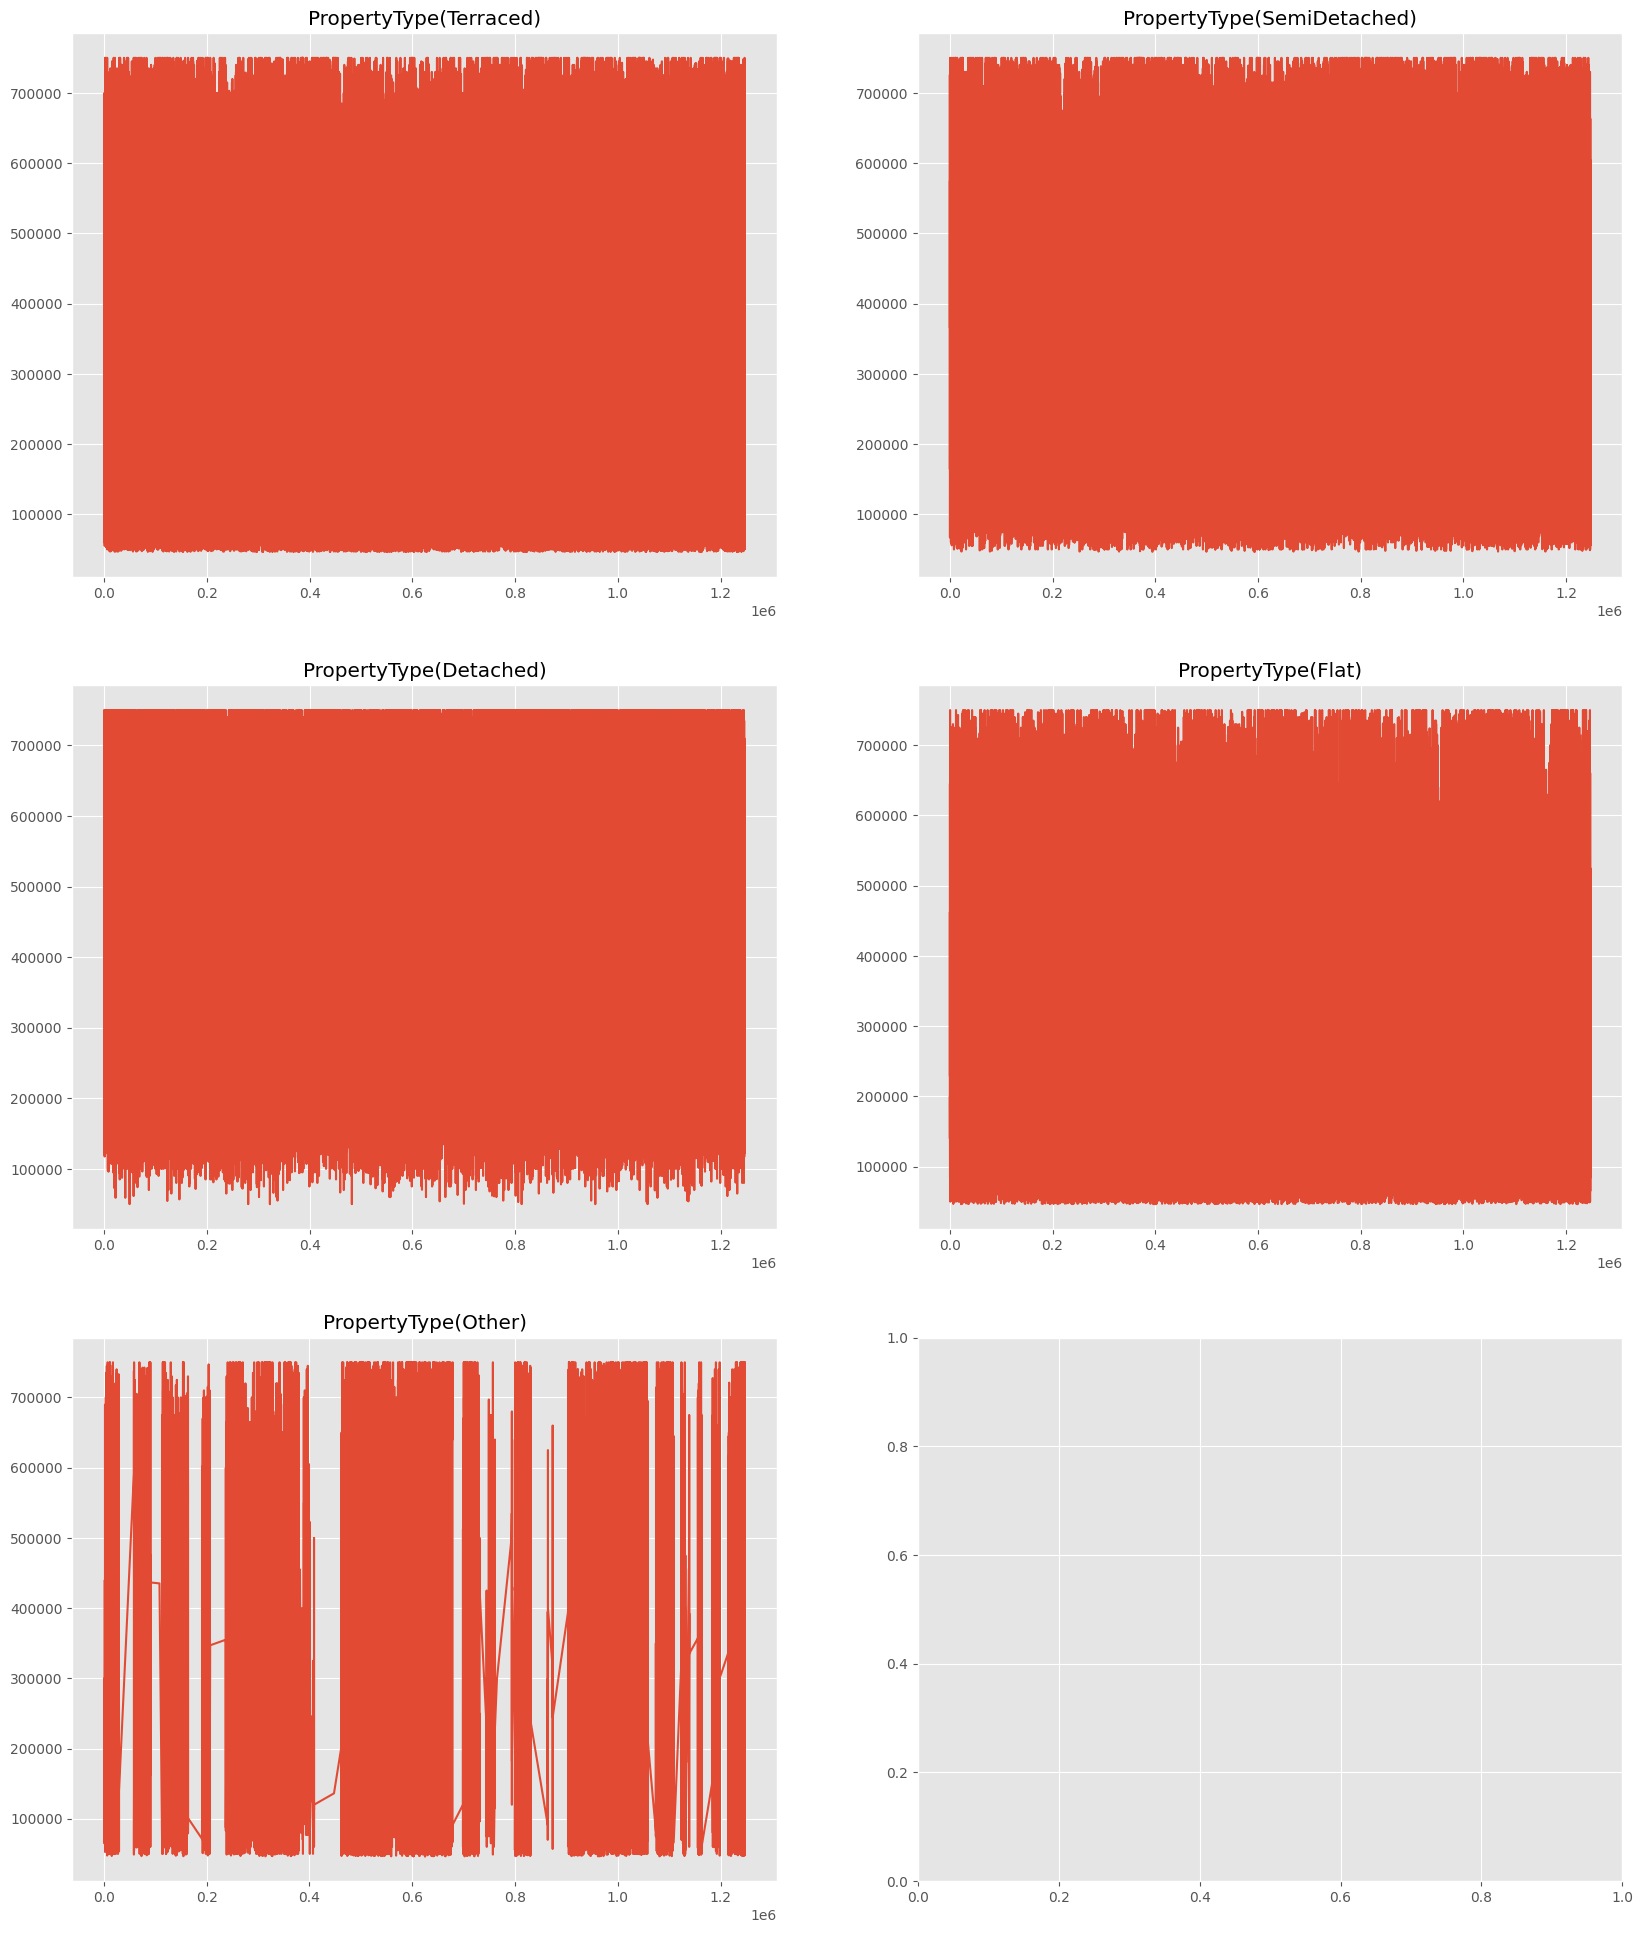

###################################################### Duration ######################################################


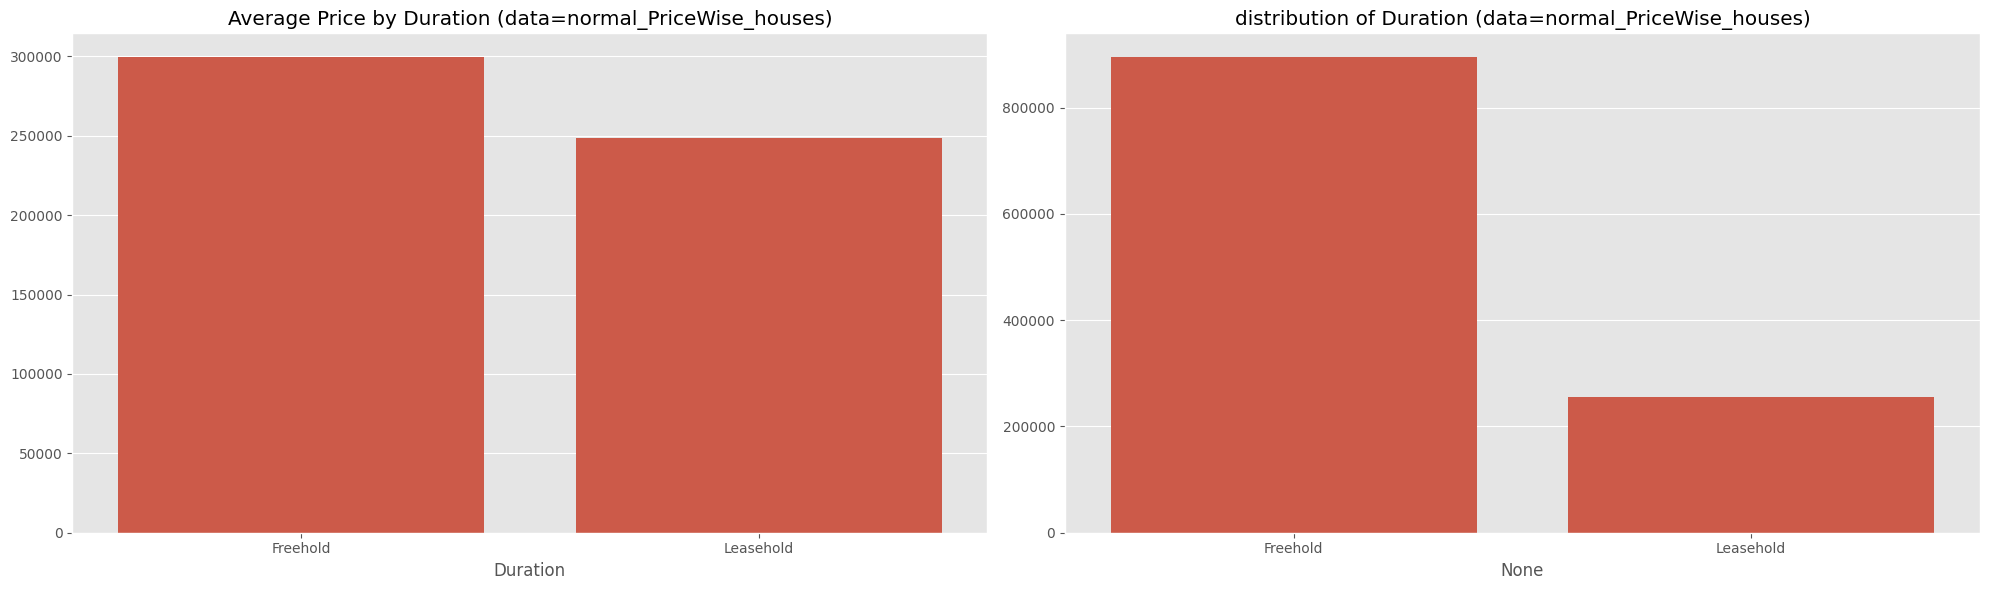

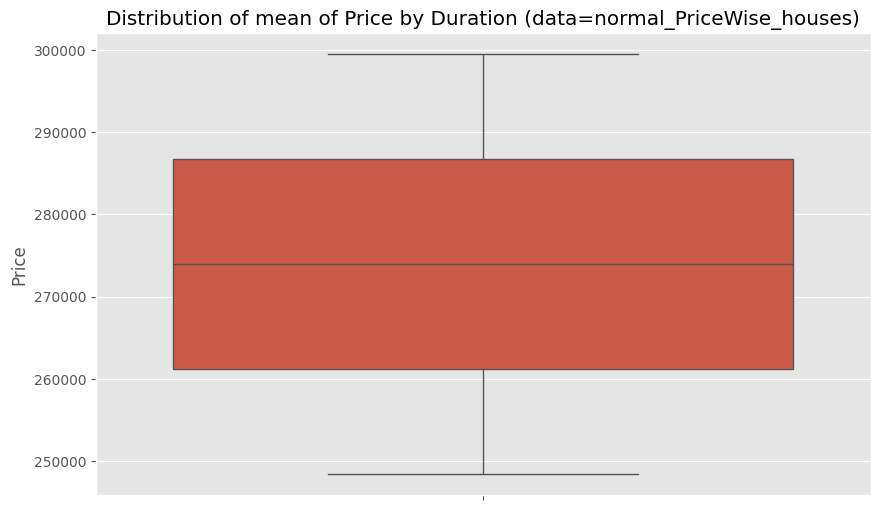

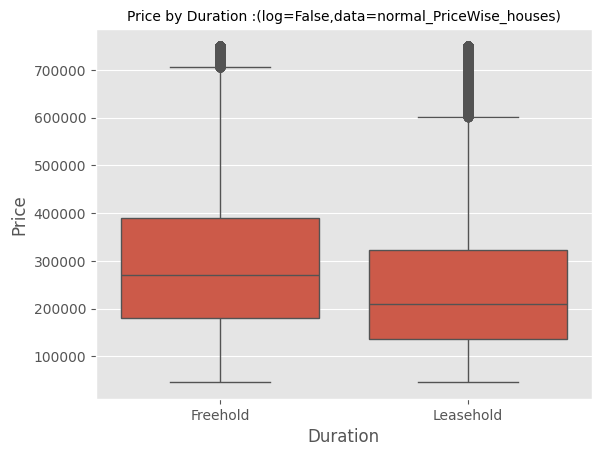

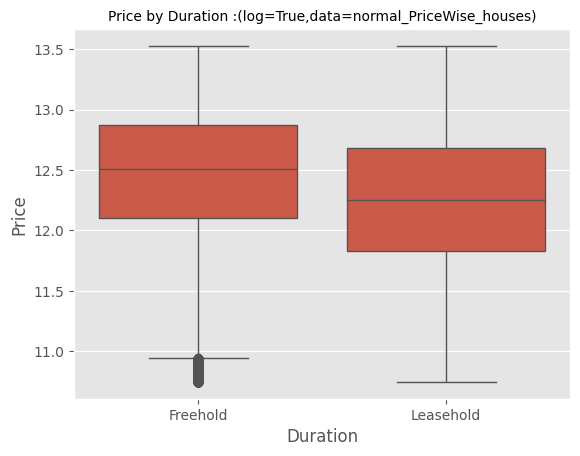

Freehold : (0,0)
Leasehold : (0,1)


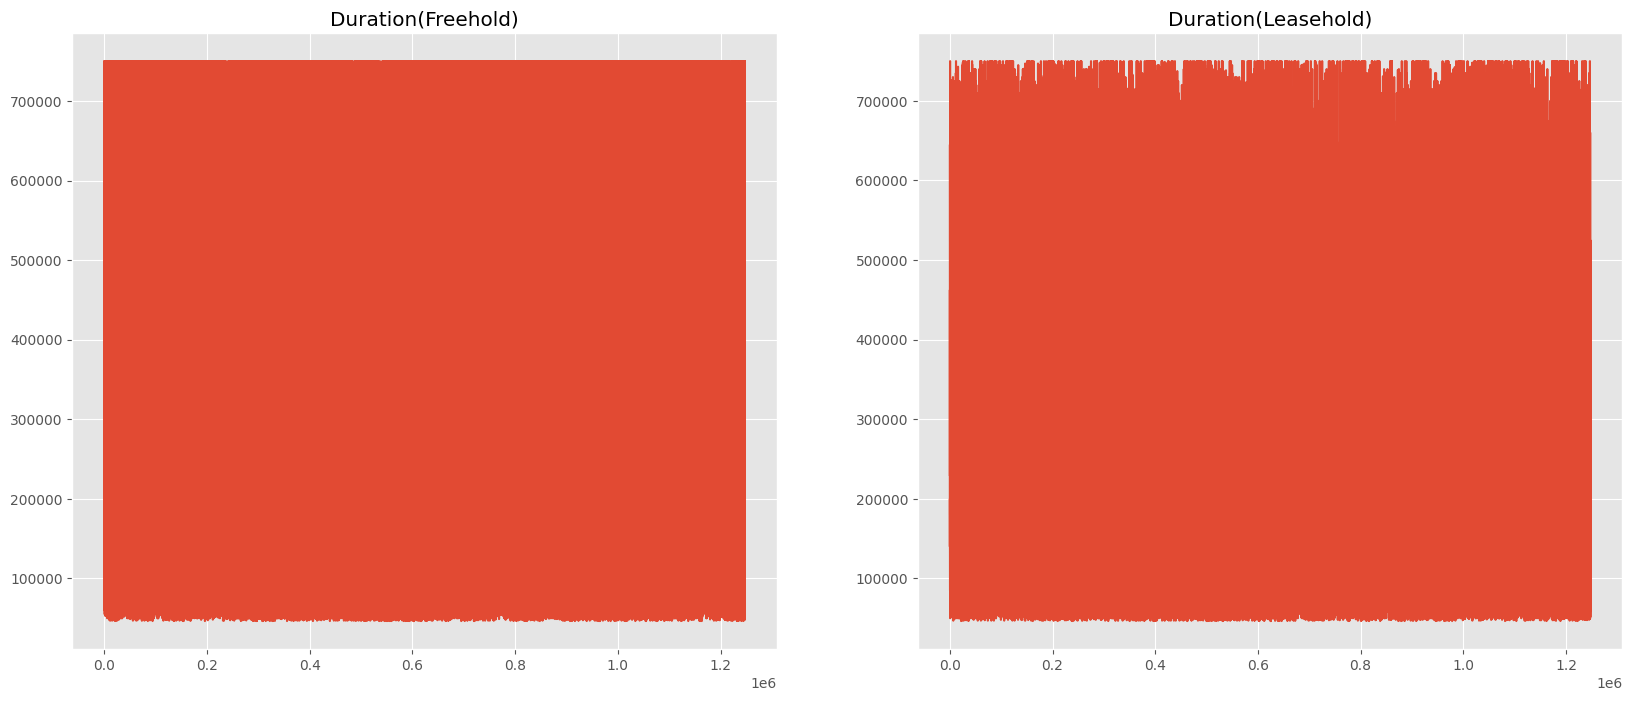

###################################################### OldNew ######################################################


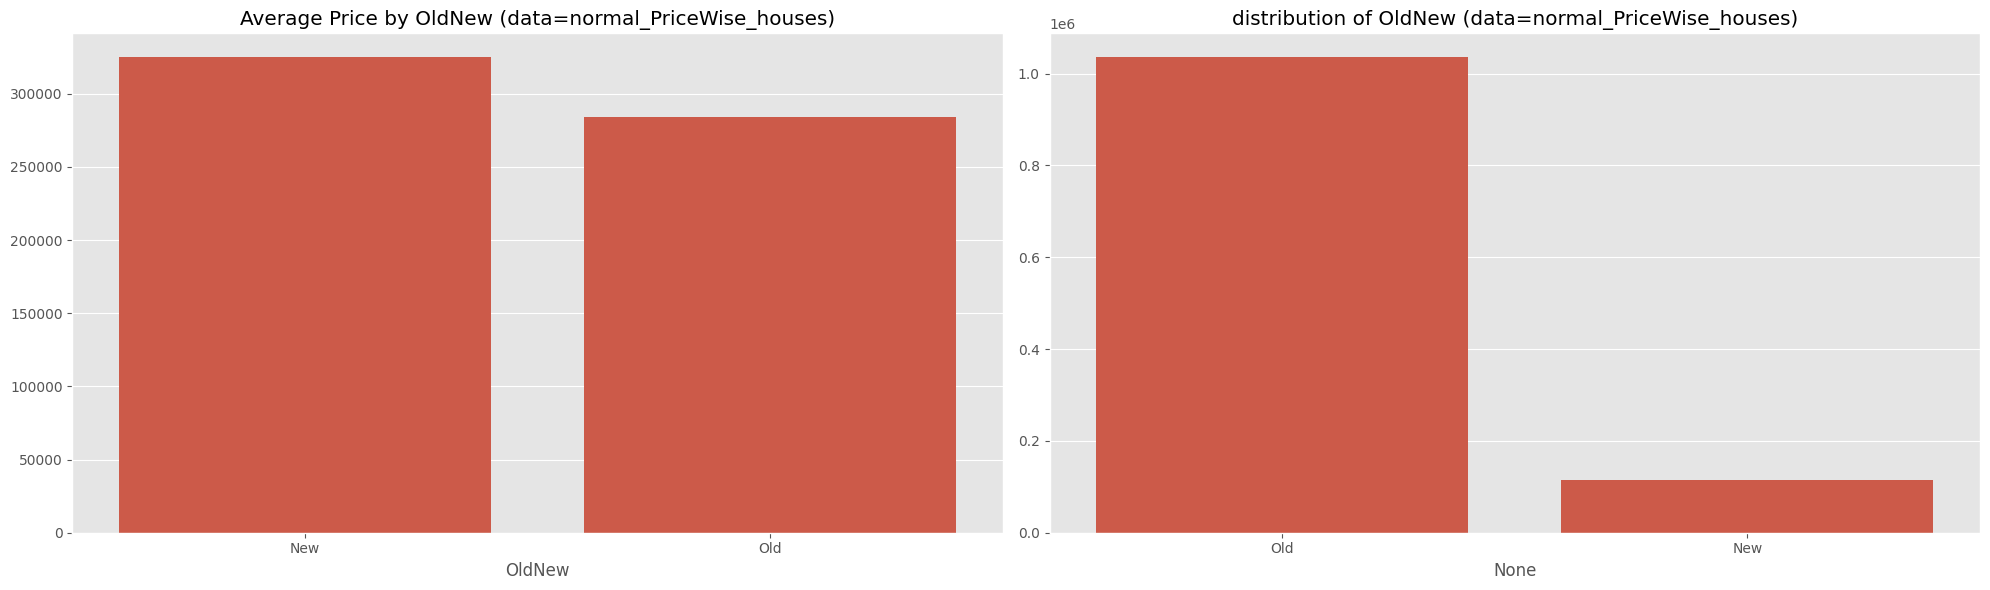

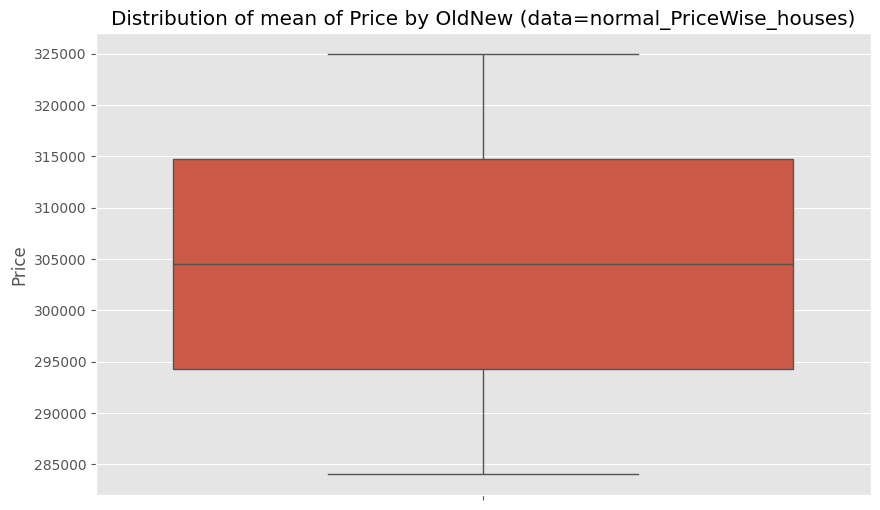

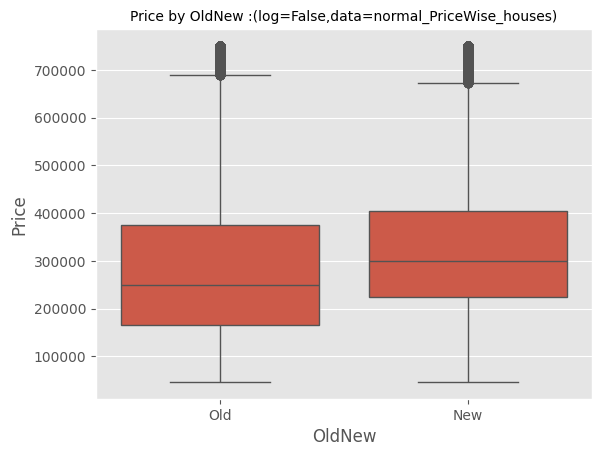

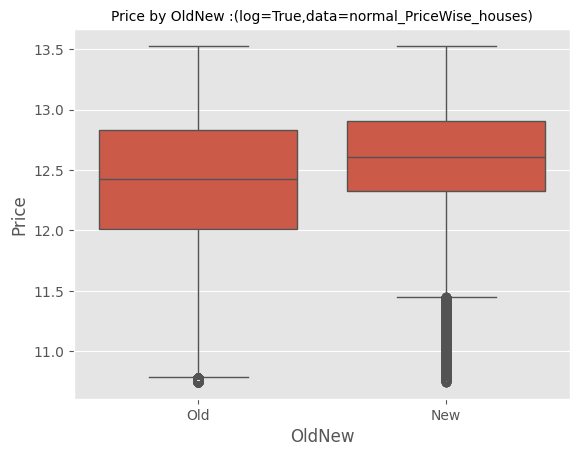

Old : (0,0)
New : (0,1)


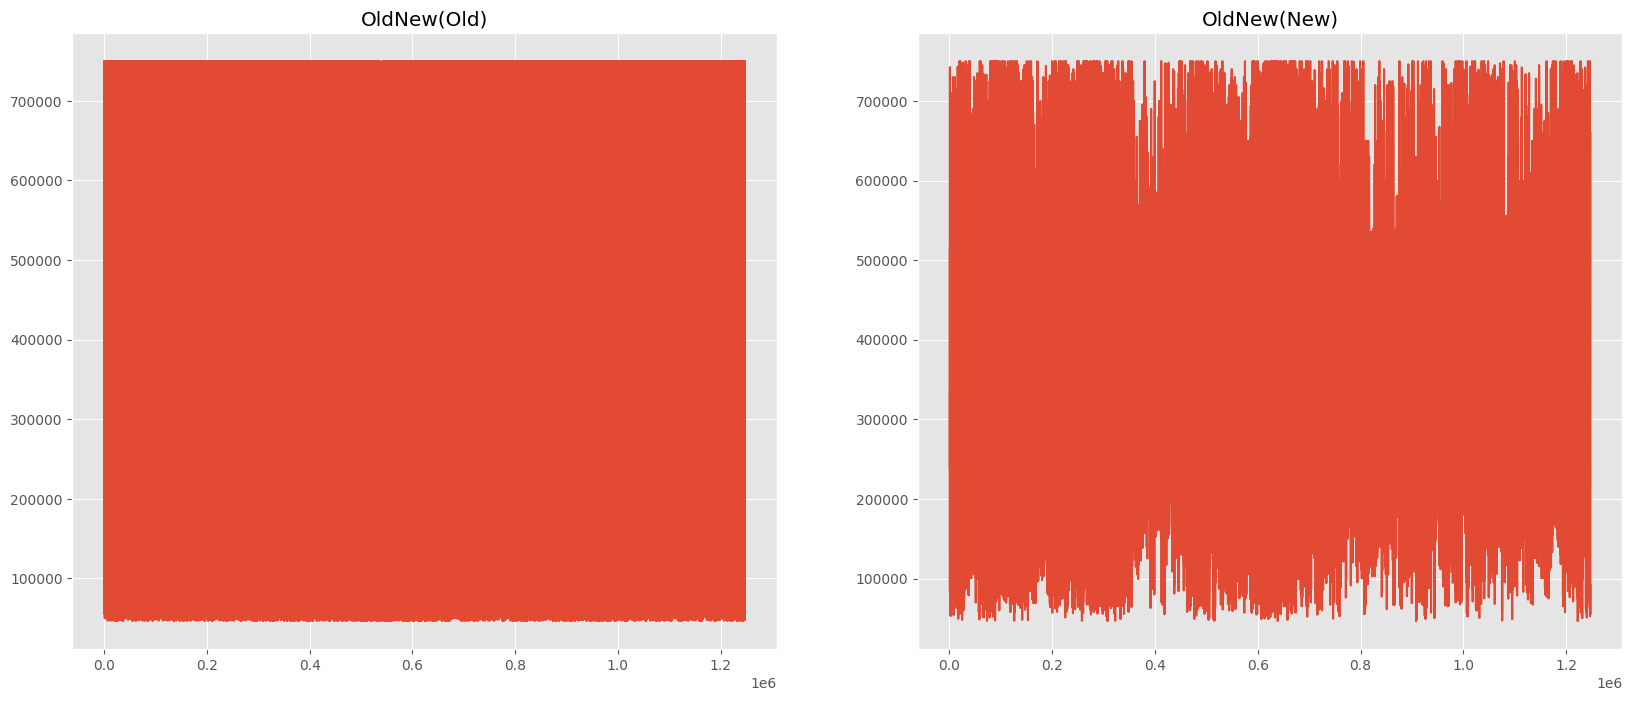

###################################################### County ######################################################


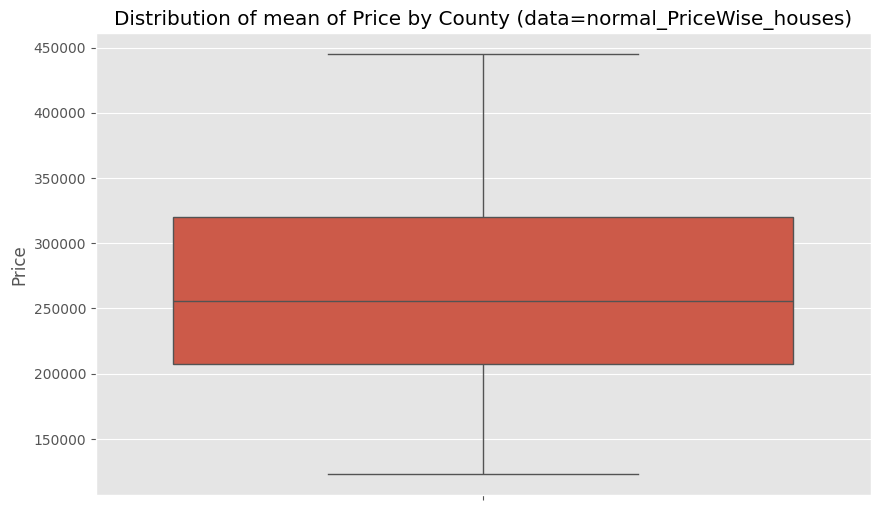

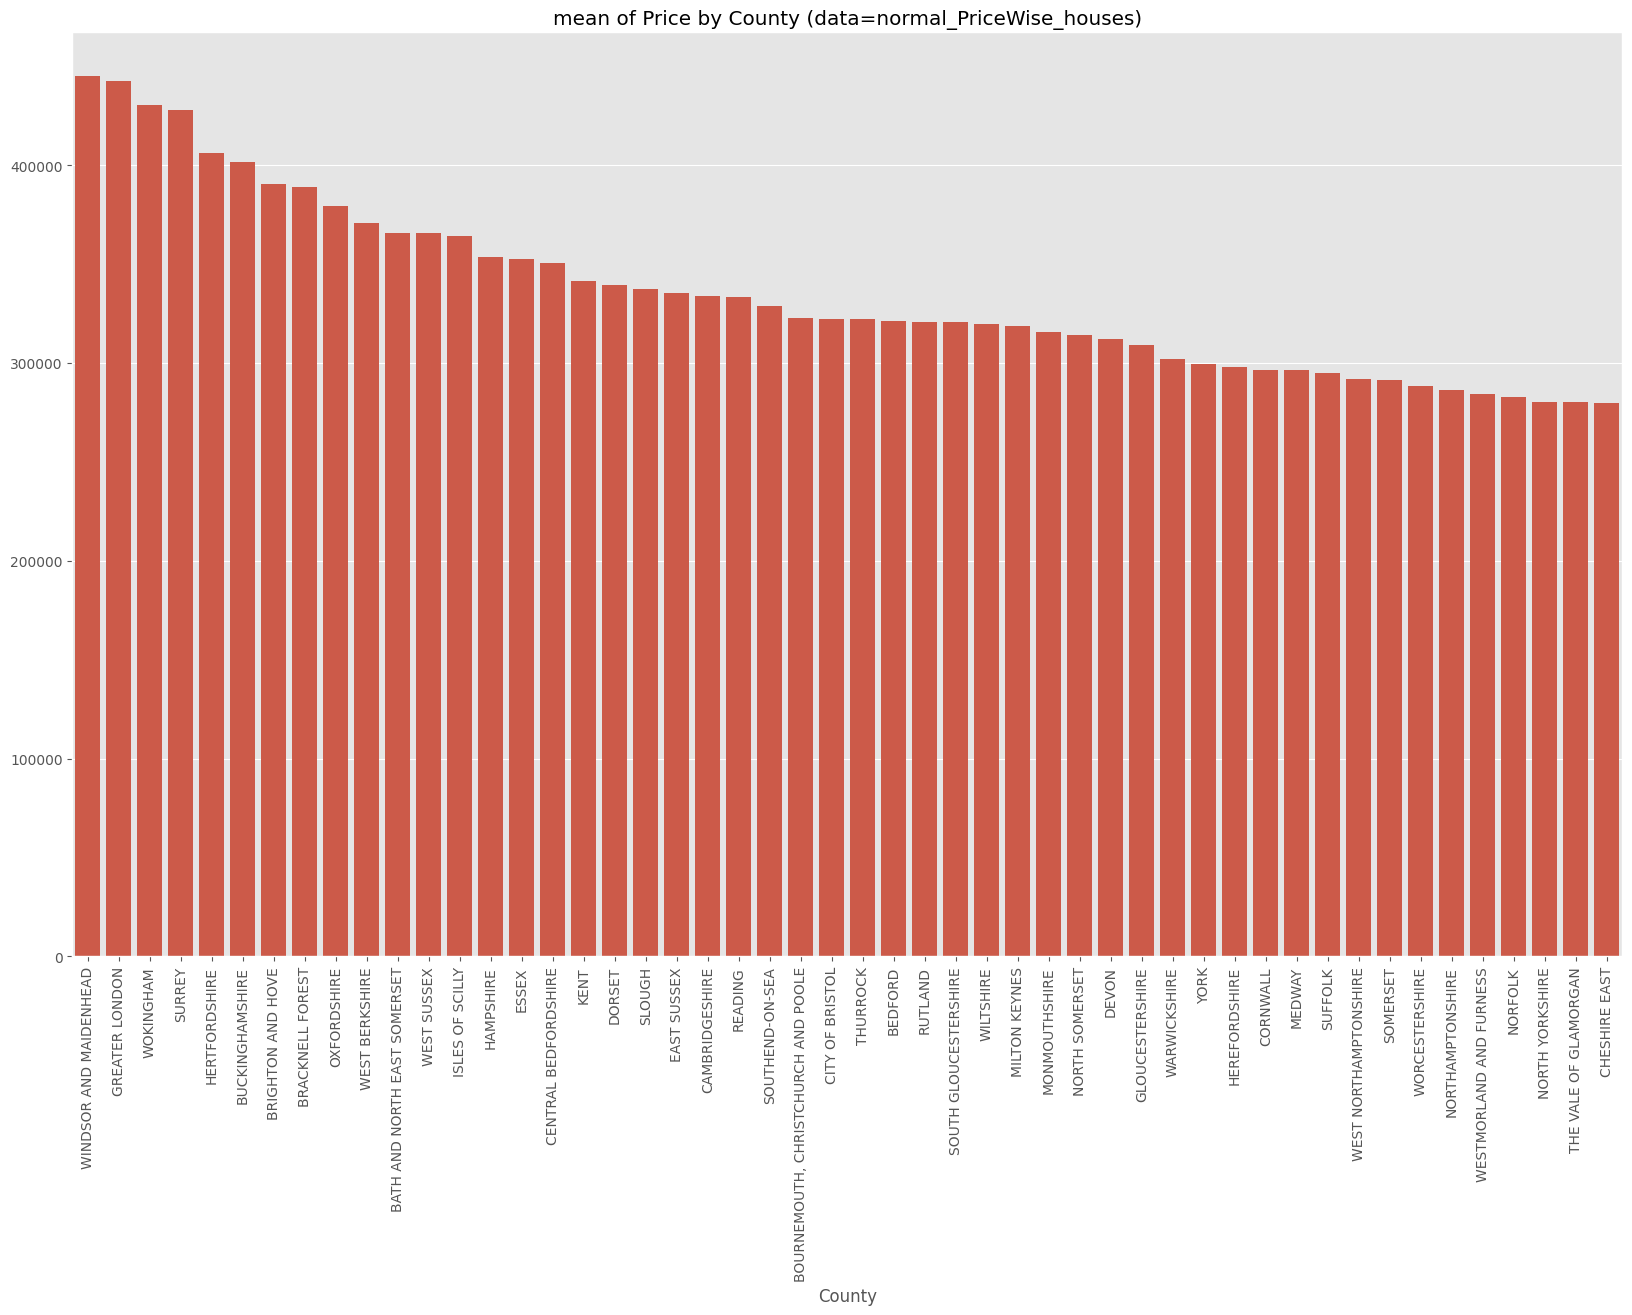

###################################################### District ######################################################


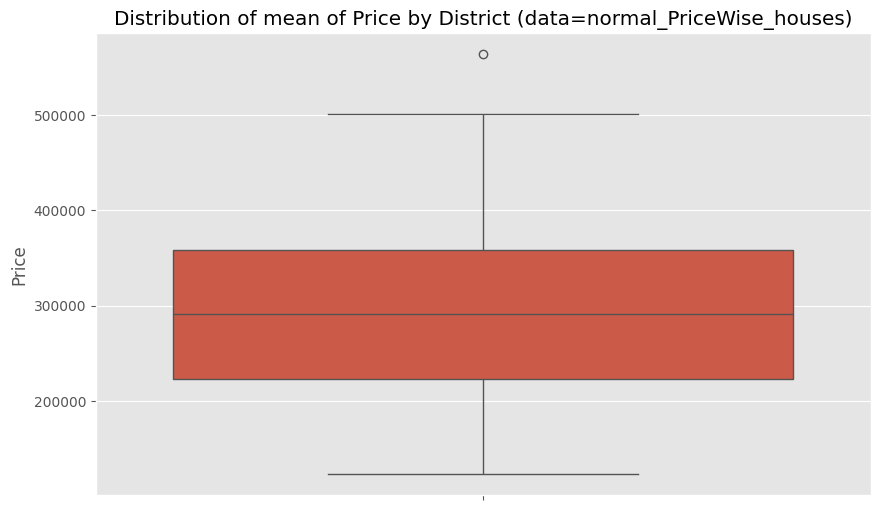

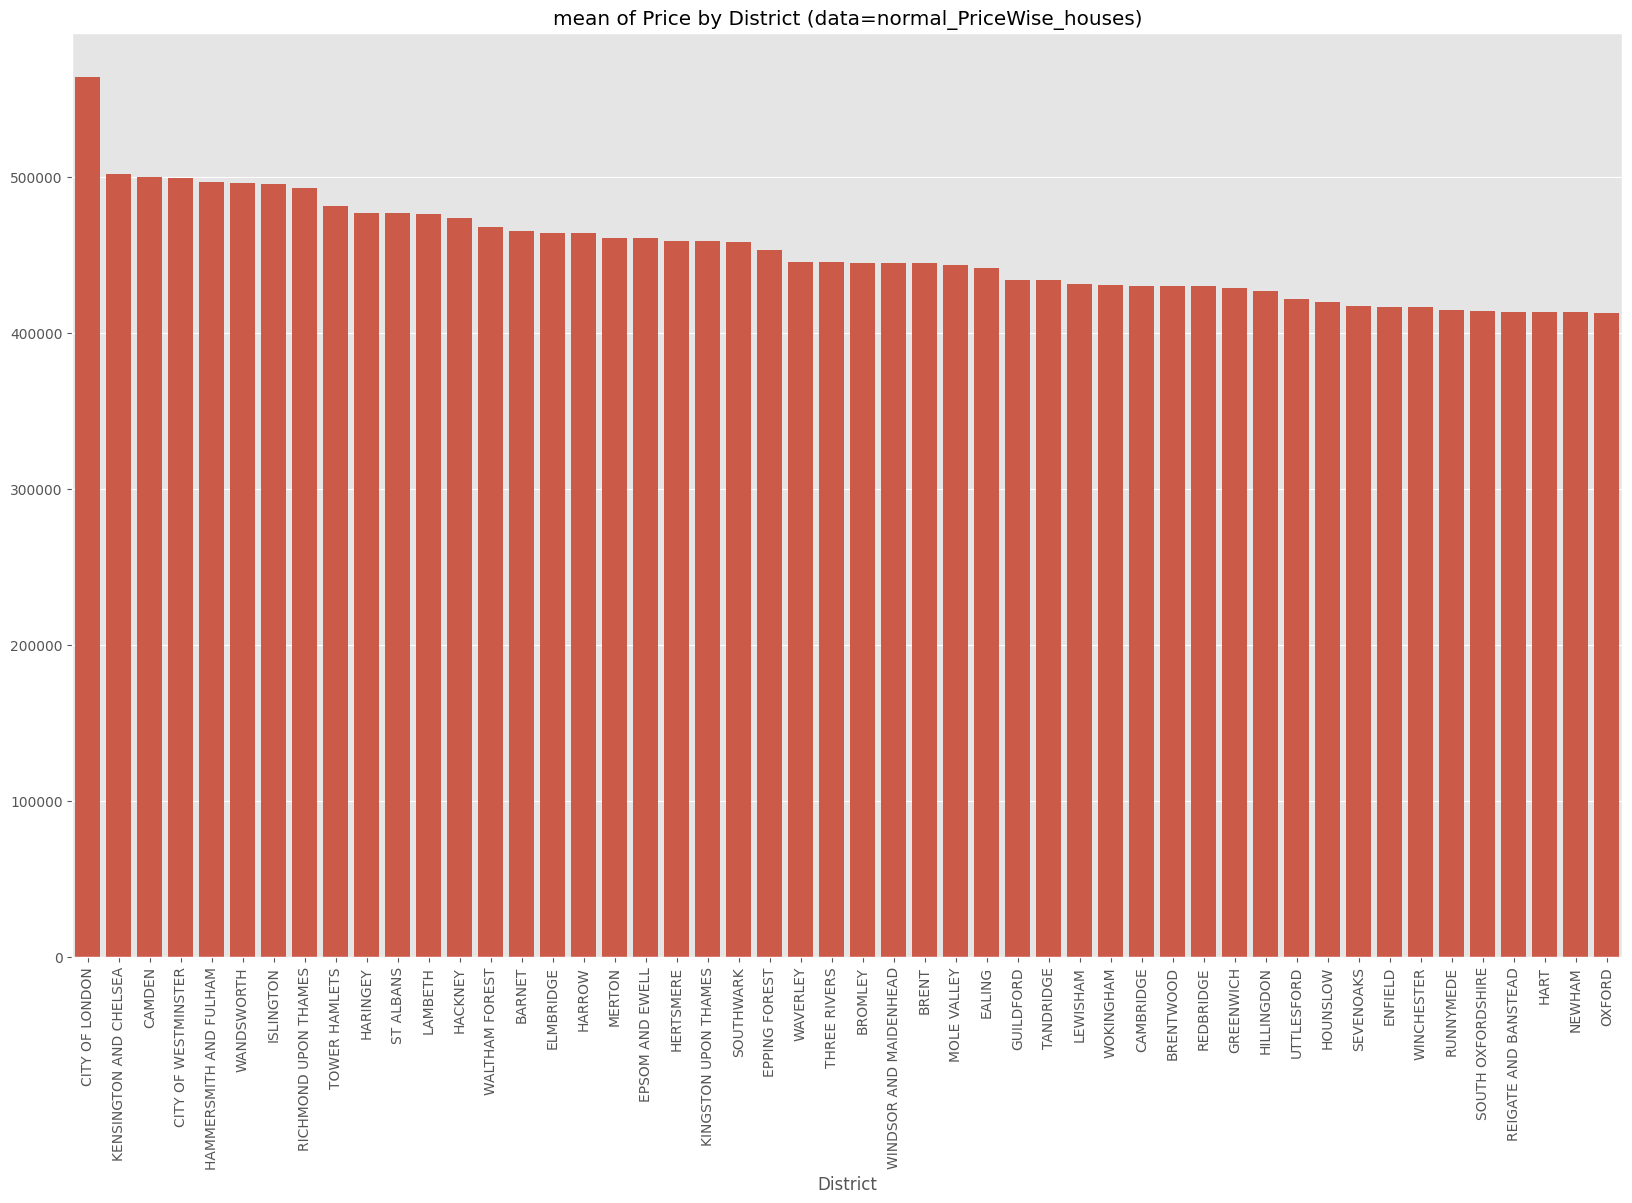

###################################################### TownCity ######################################################


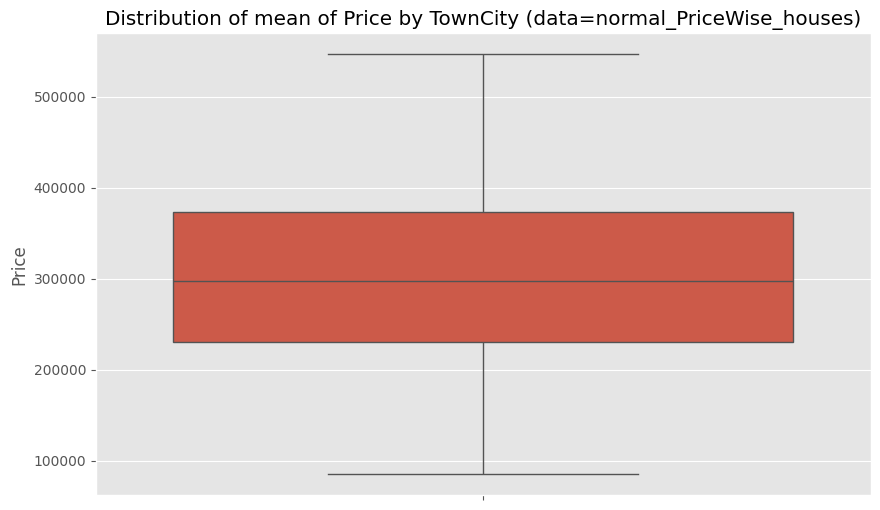

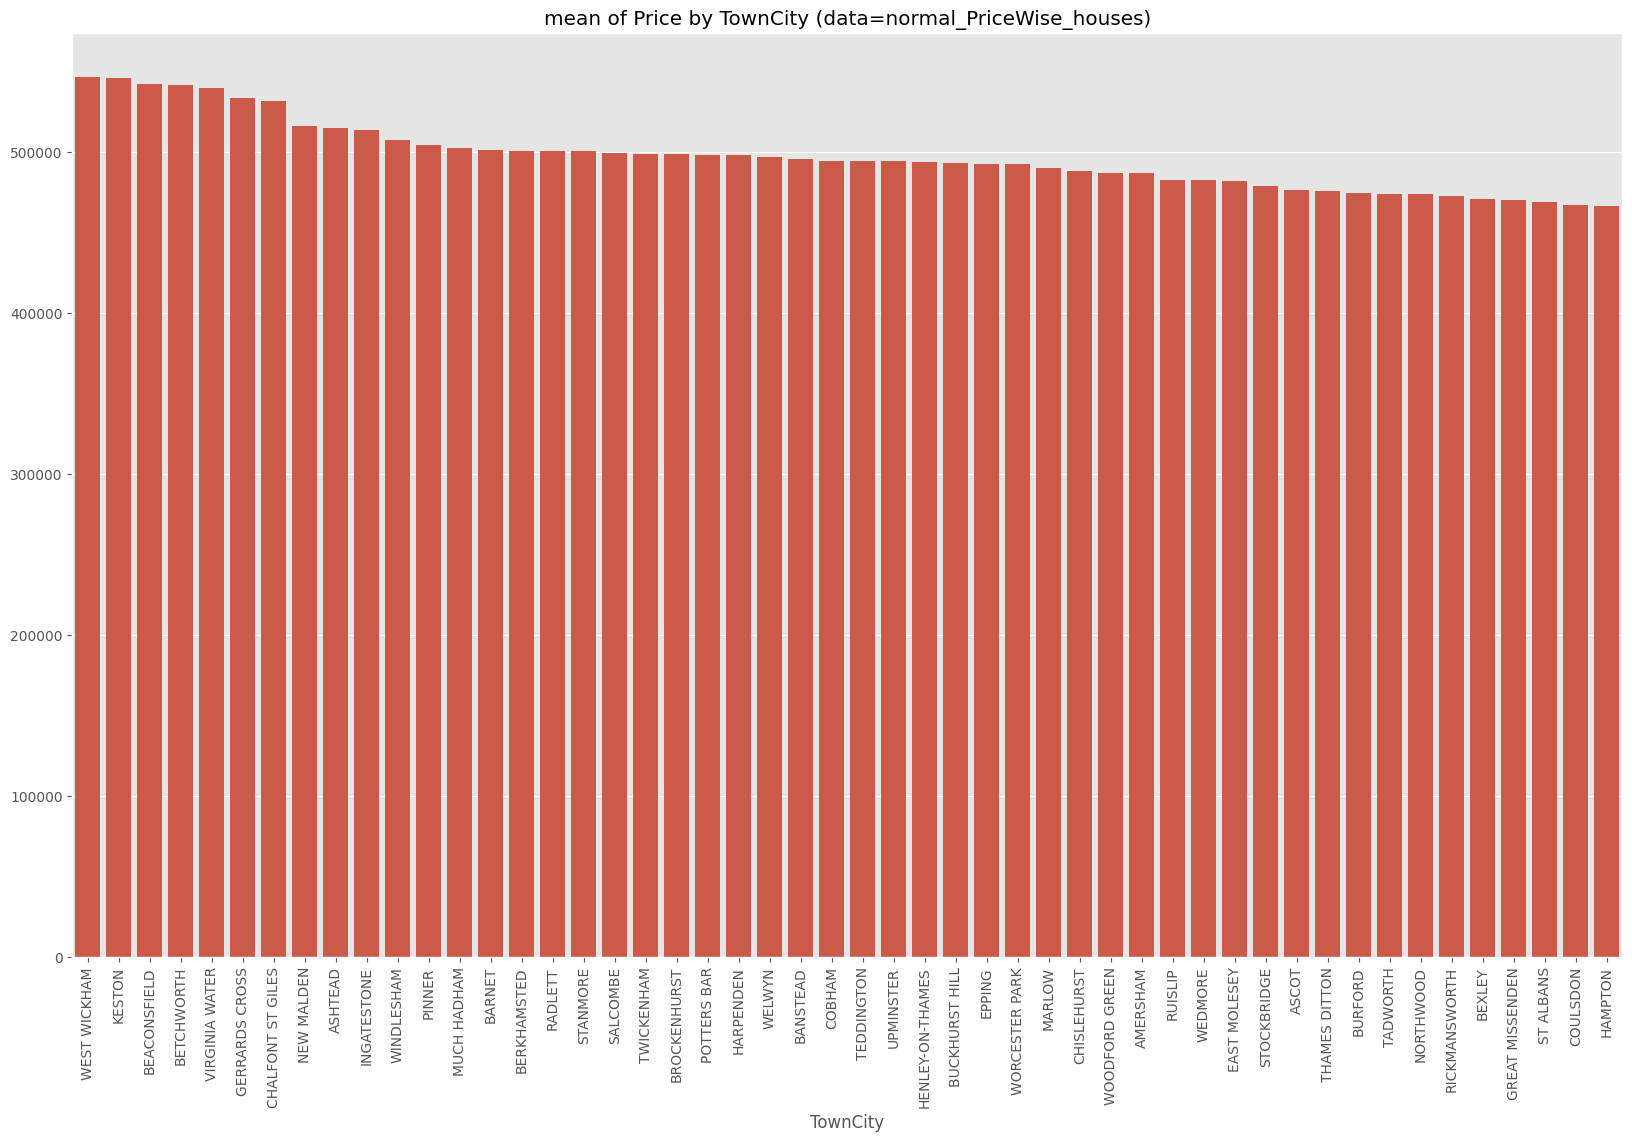

###################################################### PostcodeArea ######################################################


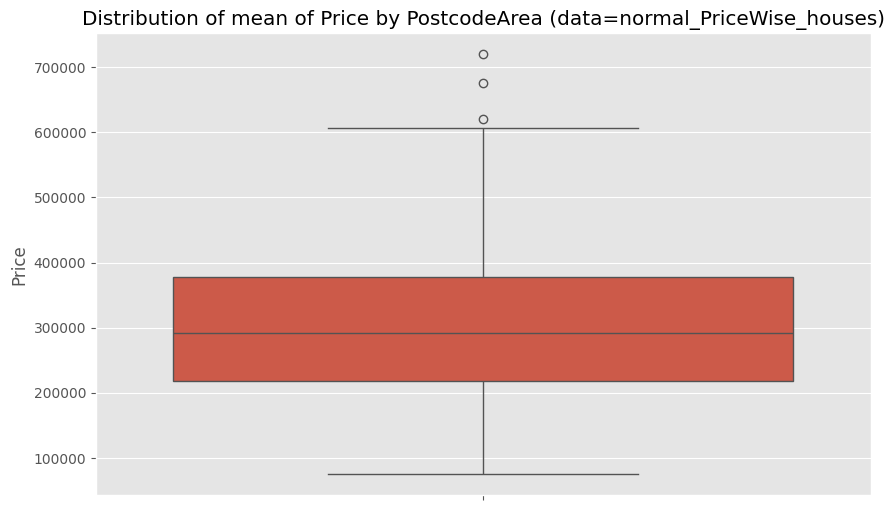

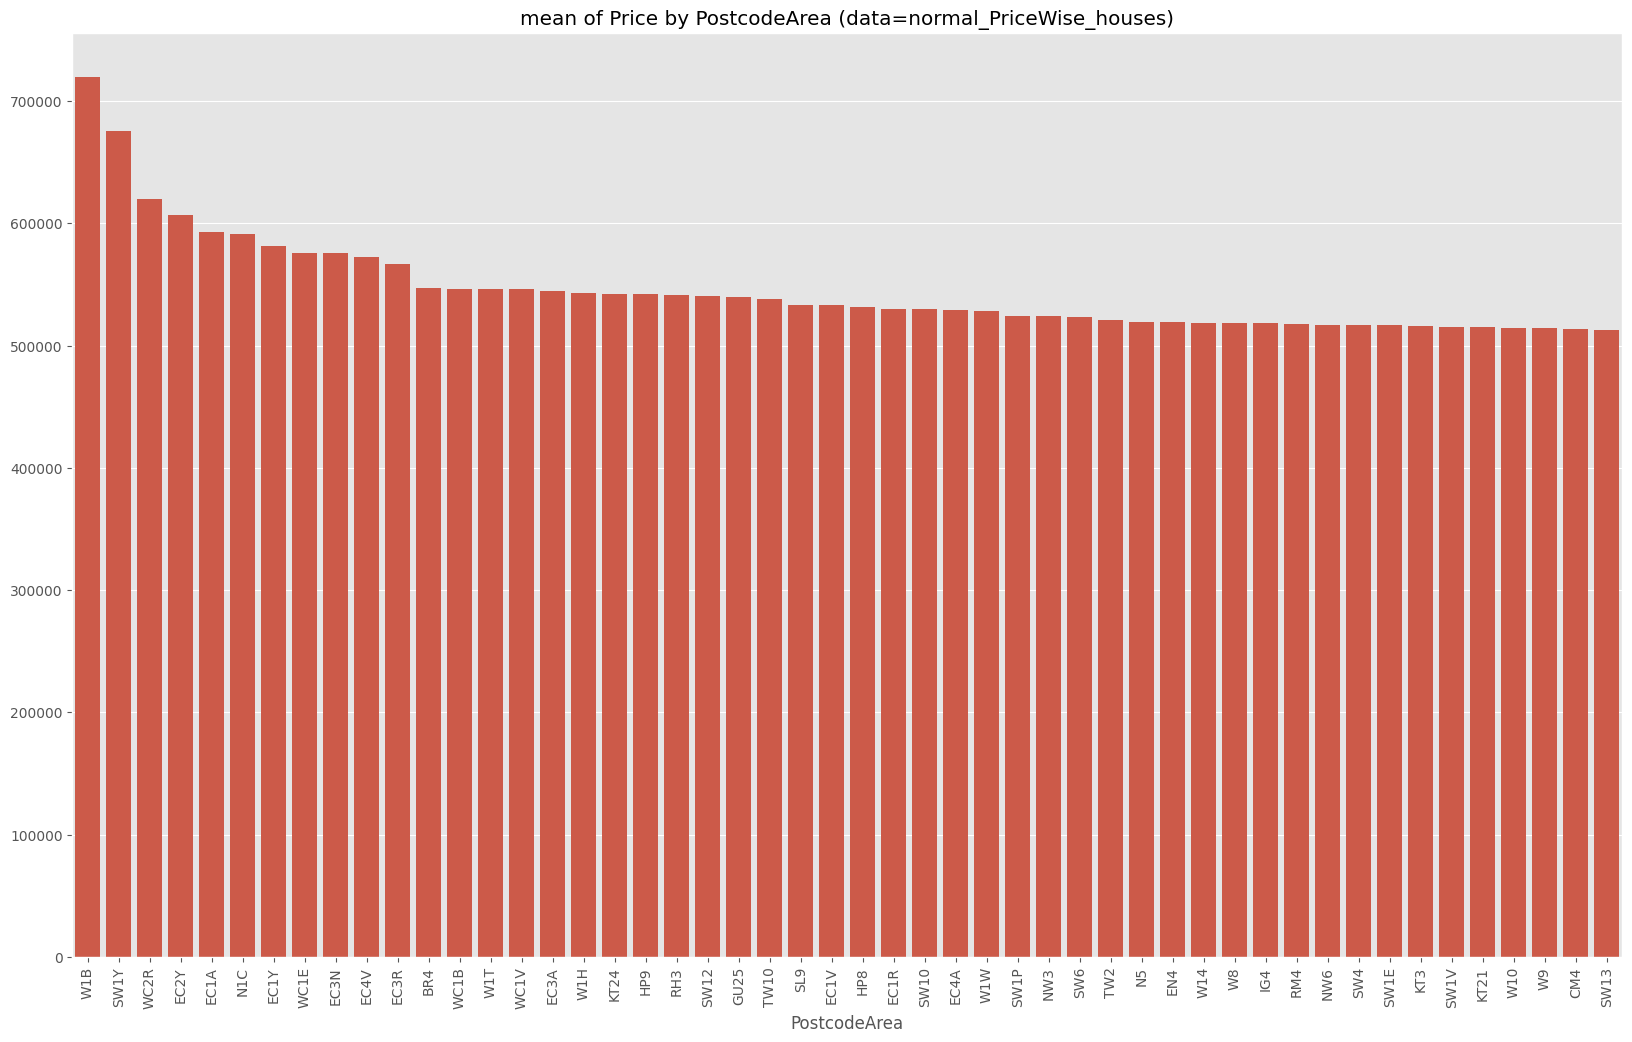

In [23]:
grp_columns = ["PropertyType","Duration","OldNew"]
geo_col = ["County","District","TownCity","PostcodeArea"]

visualise_global(
    normal_PriceWise_houses,
    bins=100,
    grp_columns=grp_columns,
    geo_col=geo_col
)

###################################################### Price ######################################################


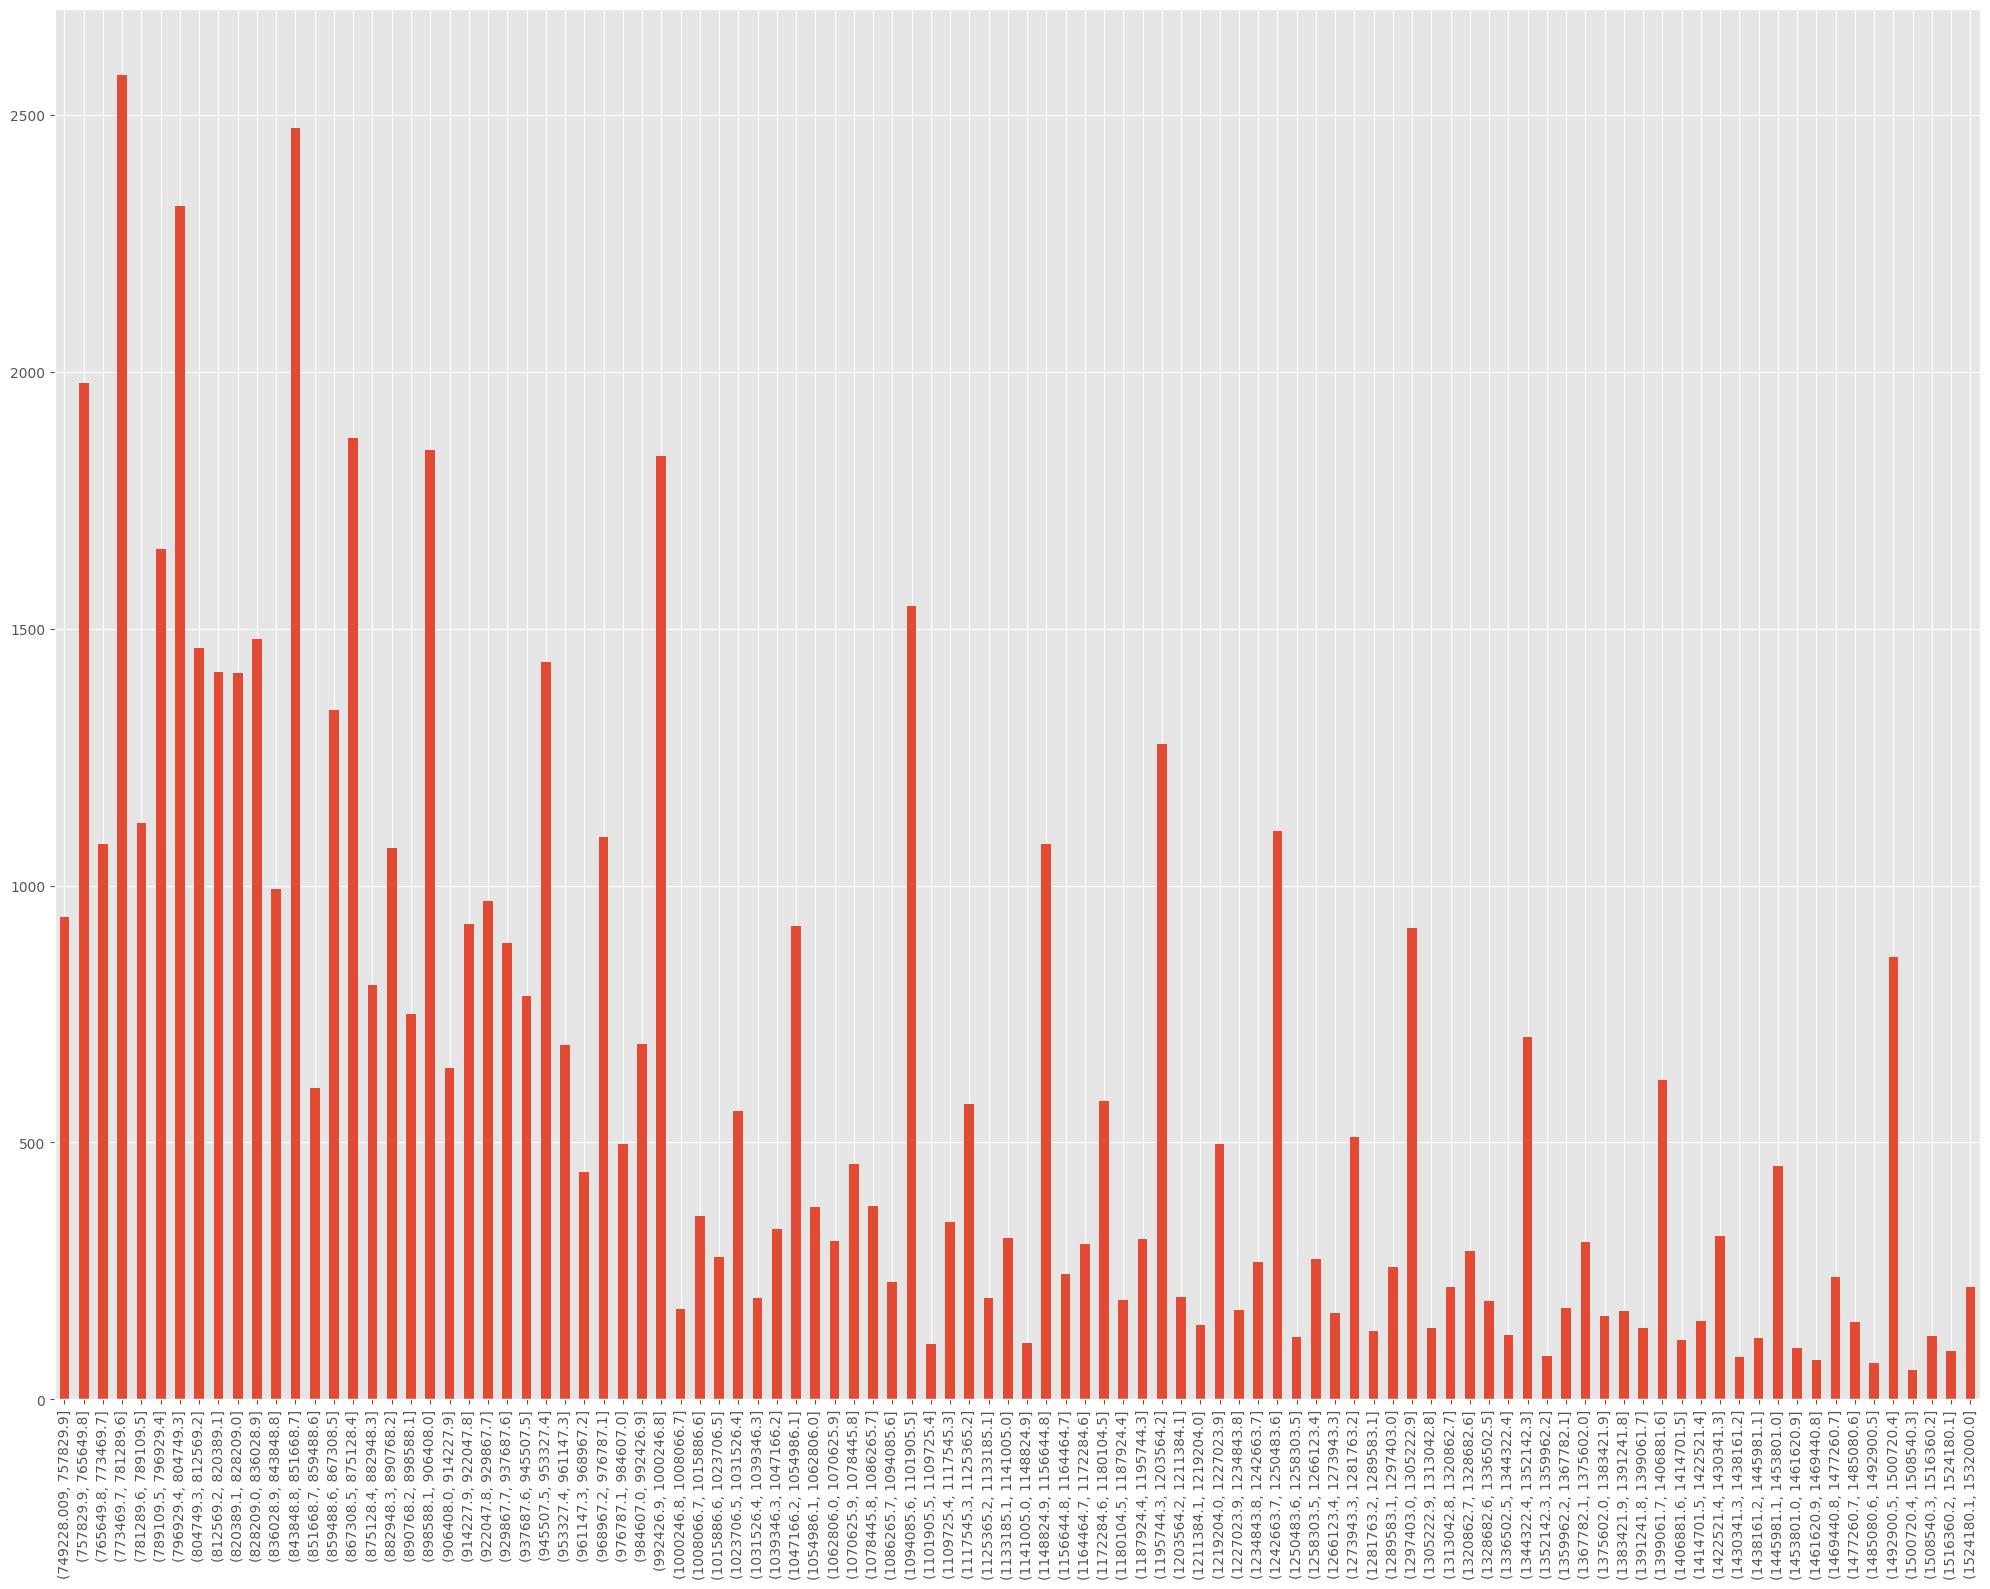

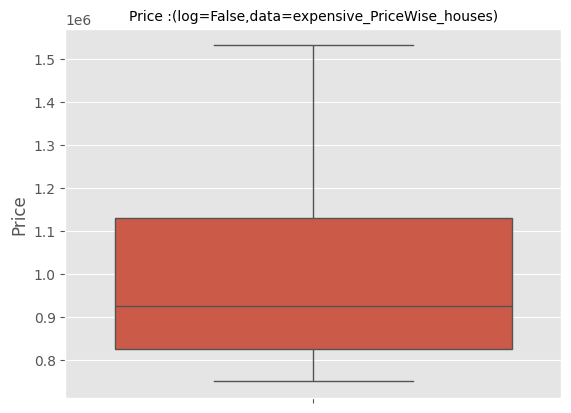

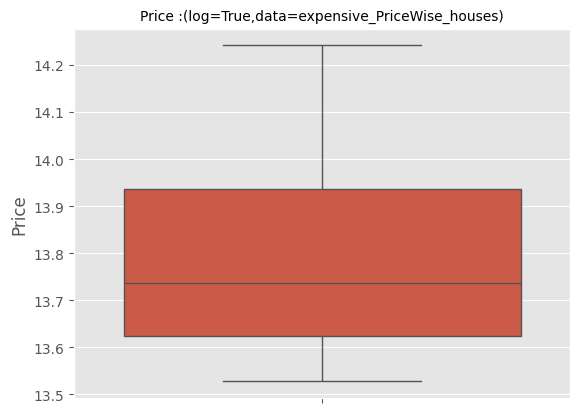

###################################################### PropertyType ######################################################


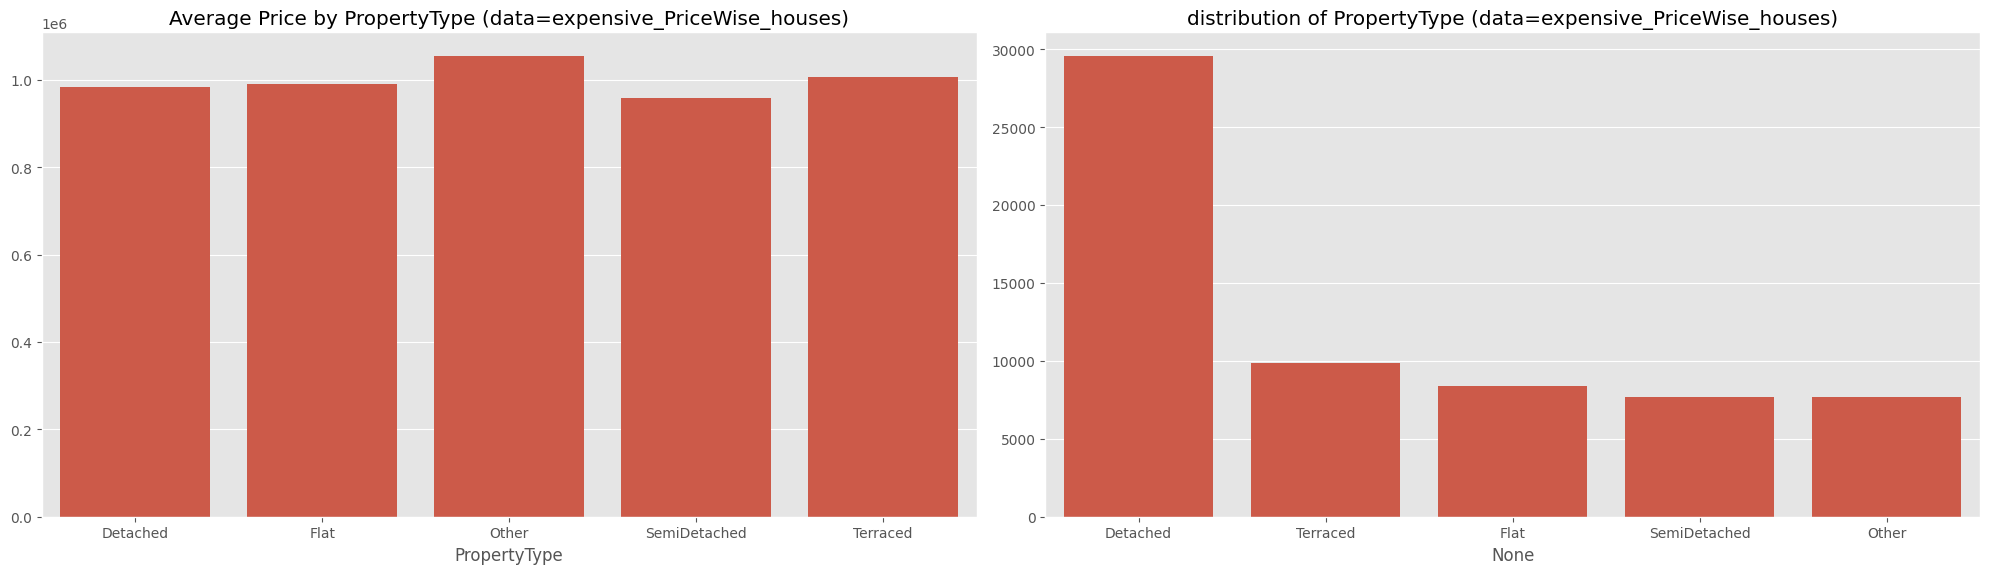

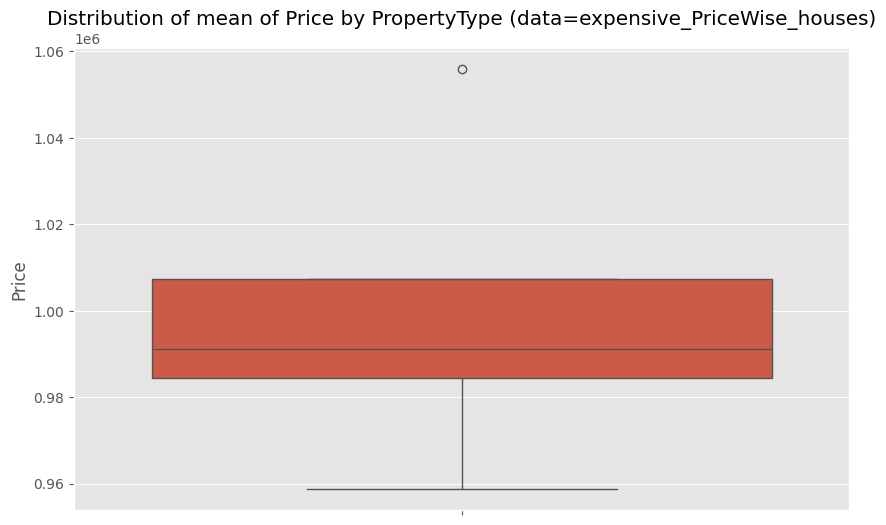

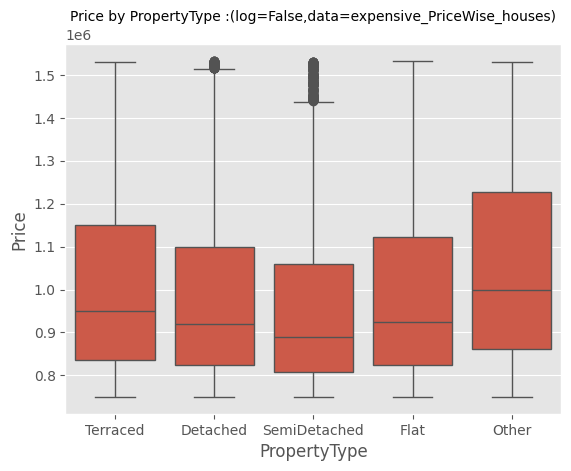

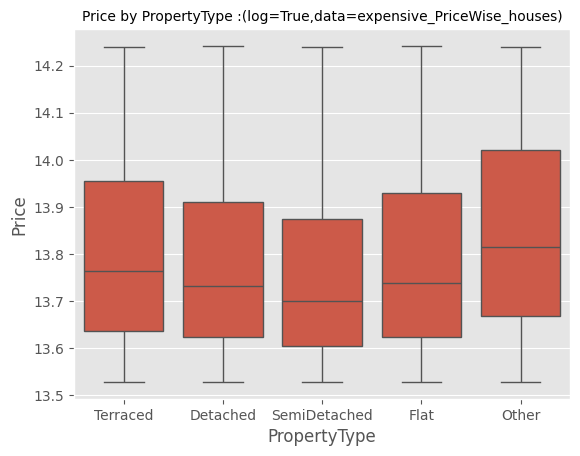

Detached : (0,0)
Terraced : (0,1)
Flat : (1,0)
SemiDetached : (1,1)
Other : (2,0)


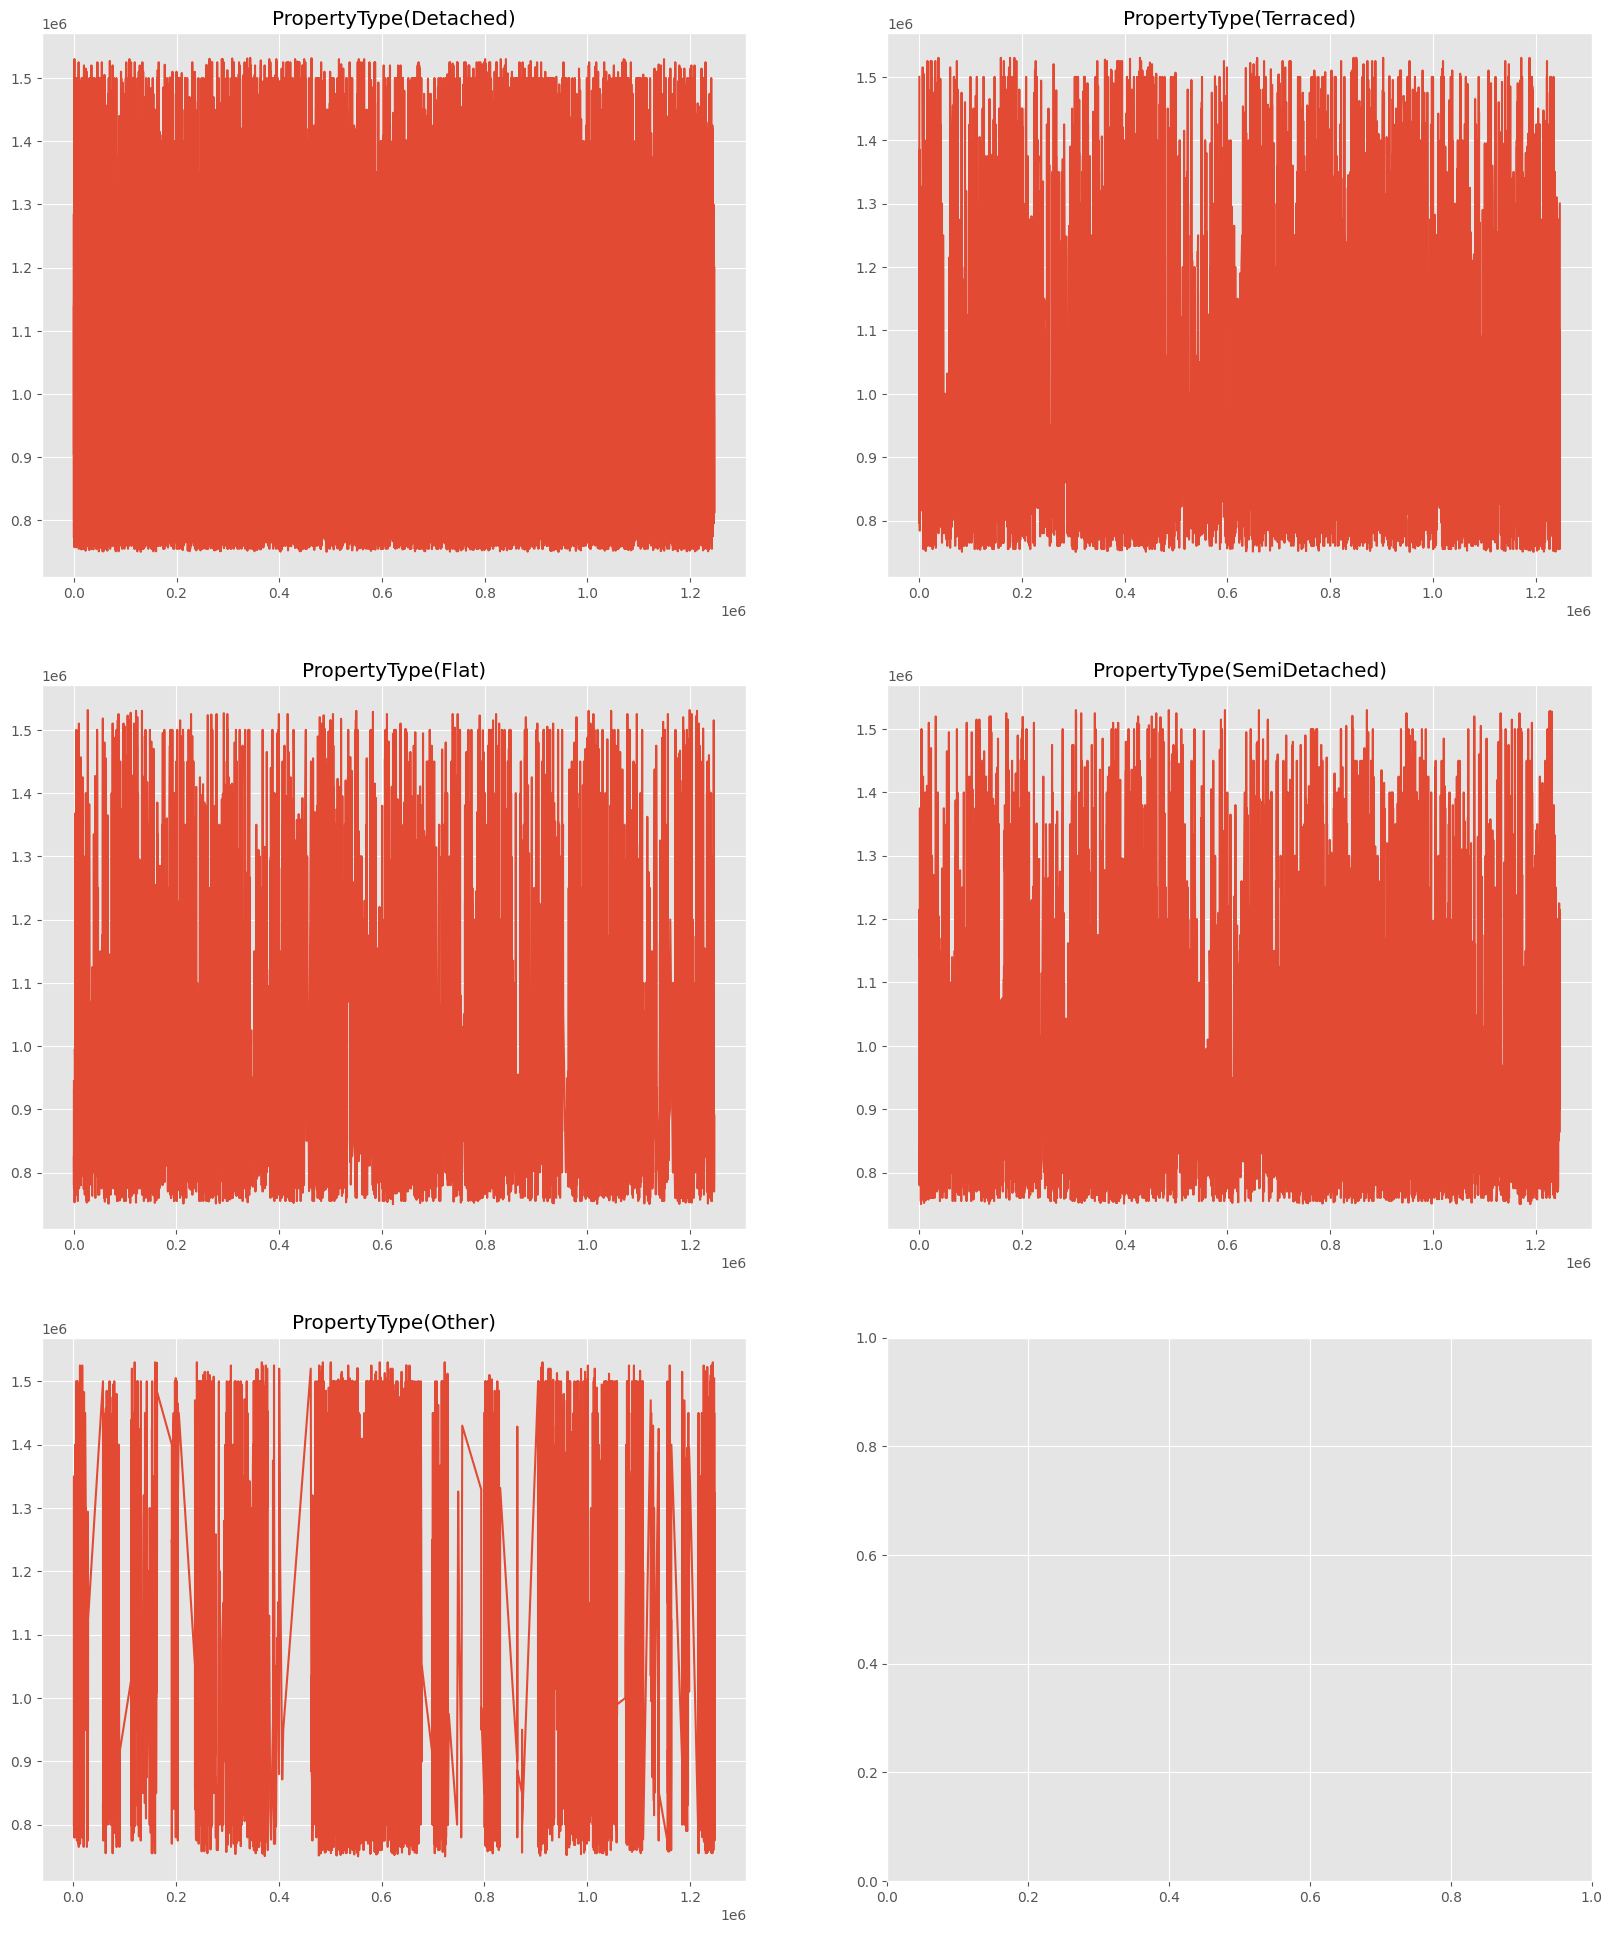

###################################################### Duration ######################################################


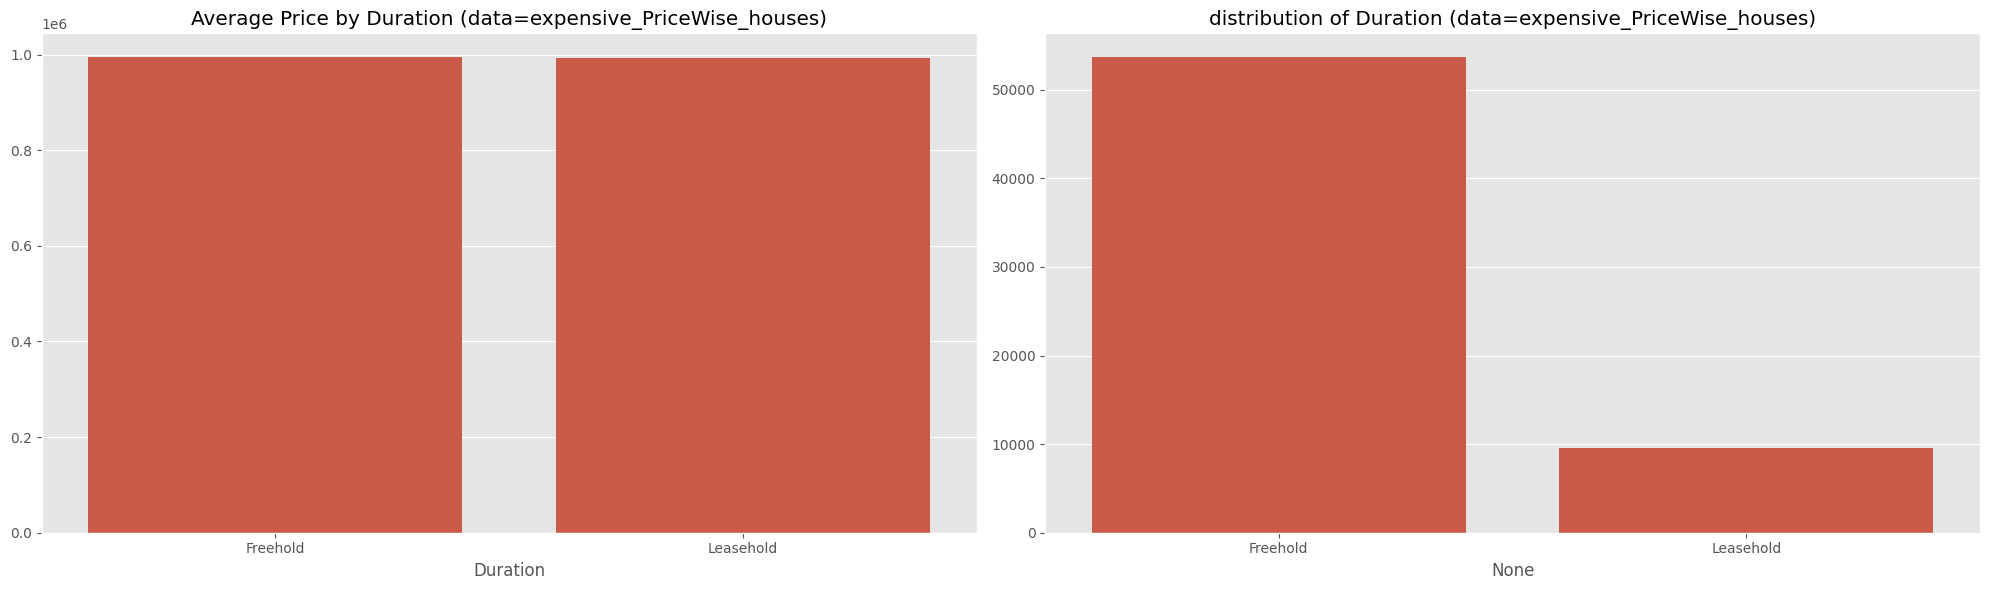

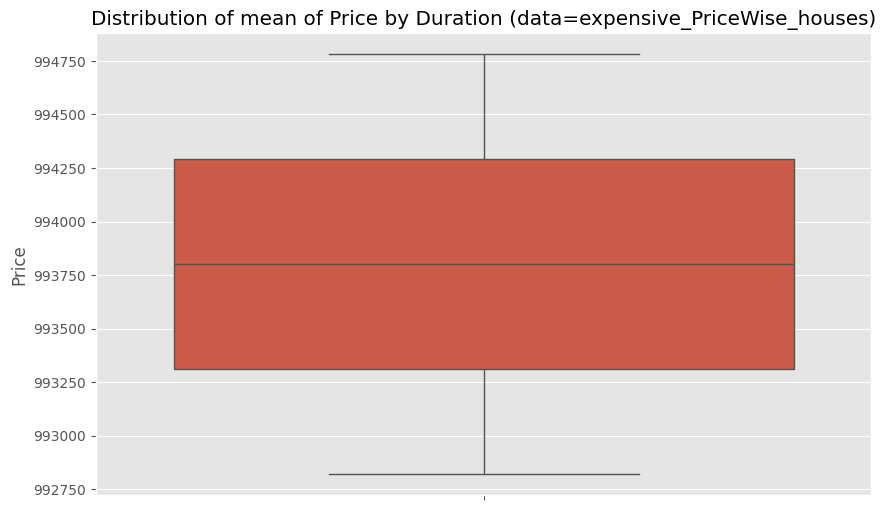

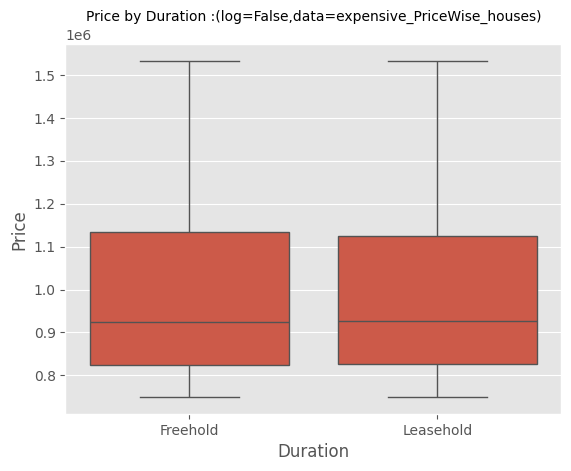

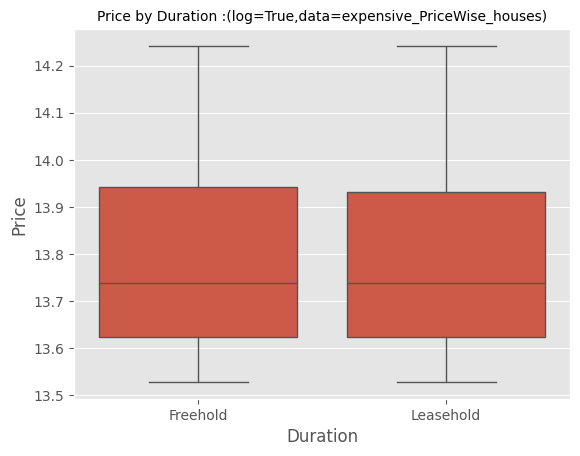

Freehold : (0,0)
Leasehold : (0,1)


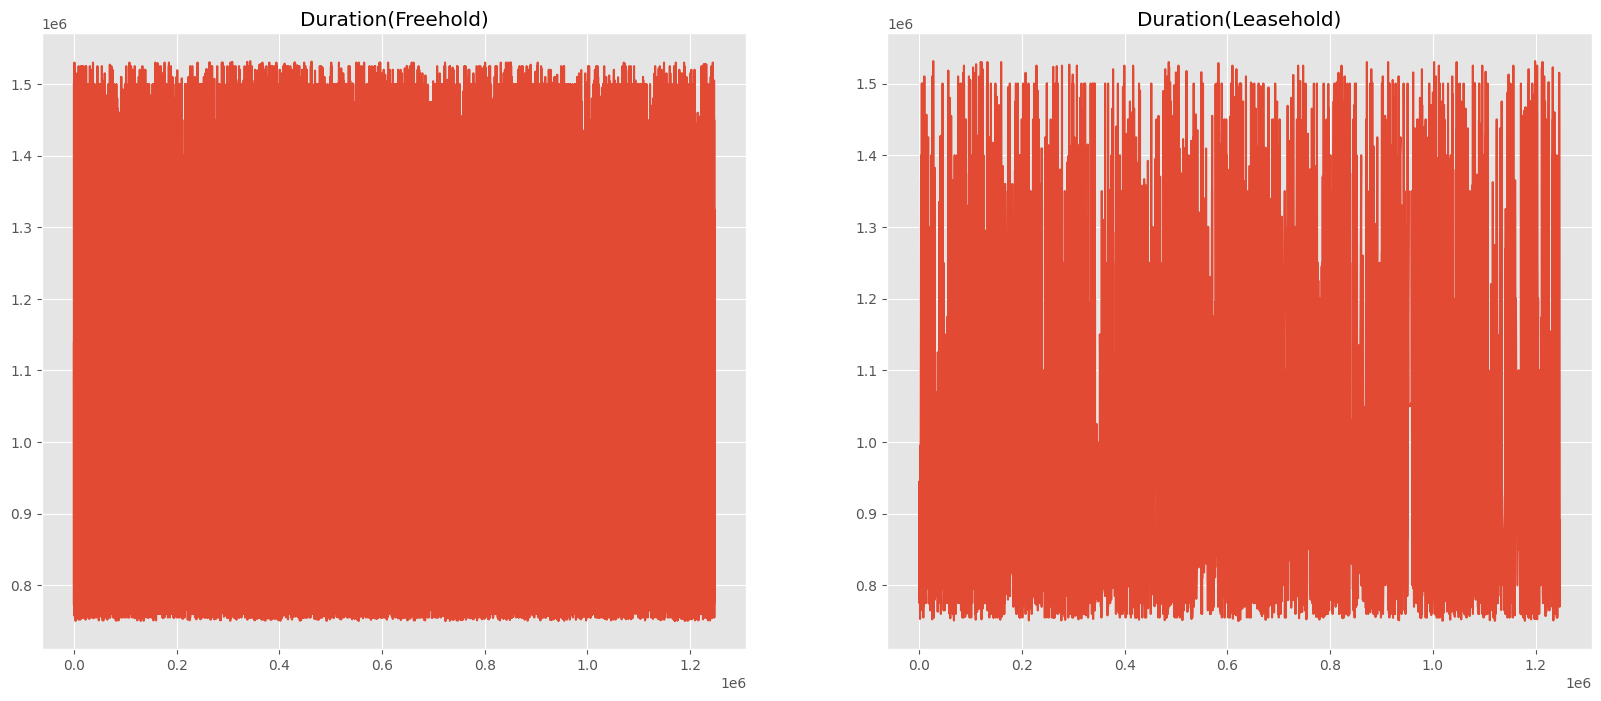

###################################################### OldNew ######################################################


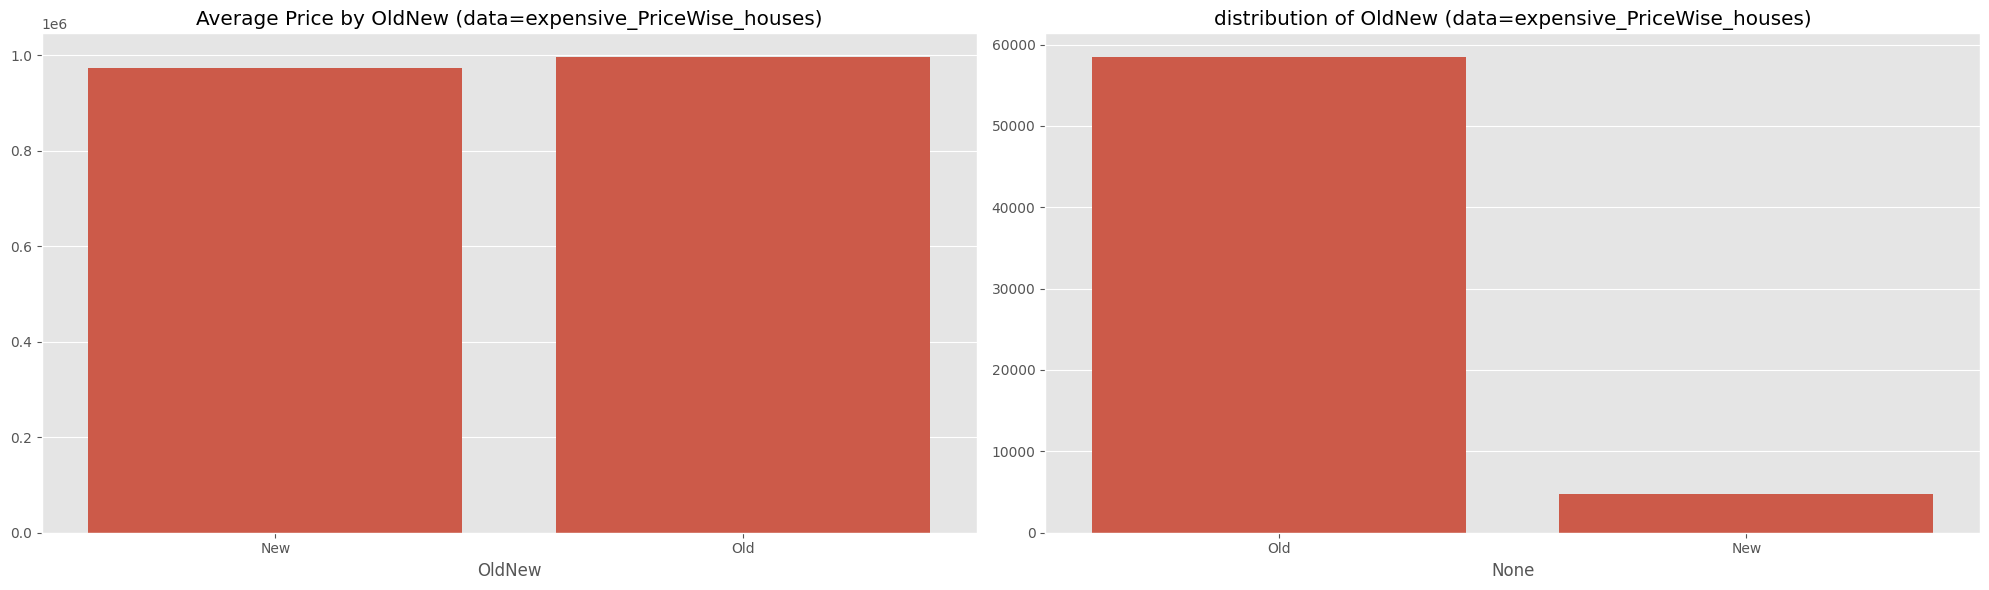

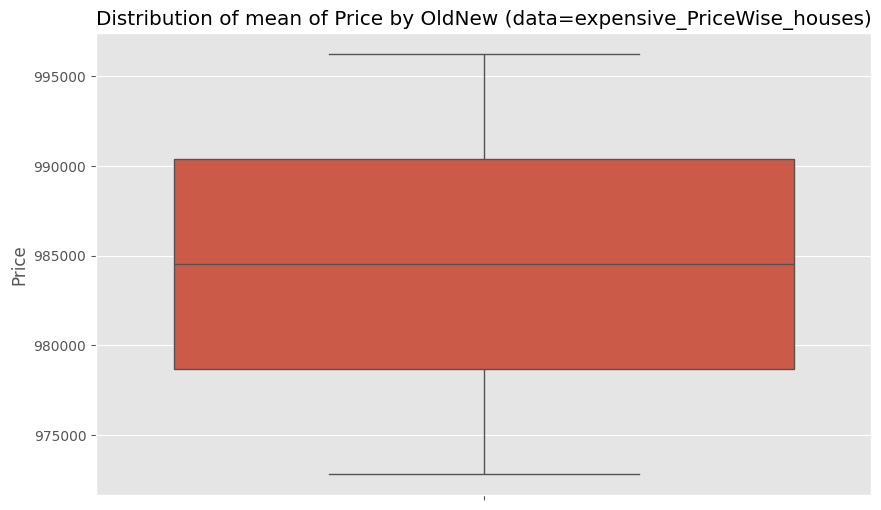

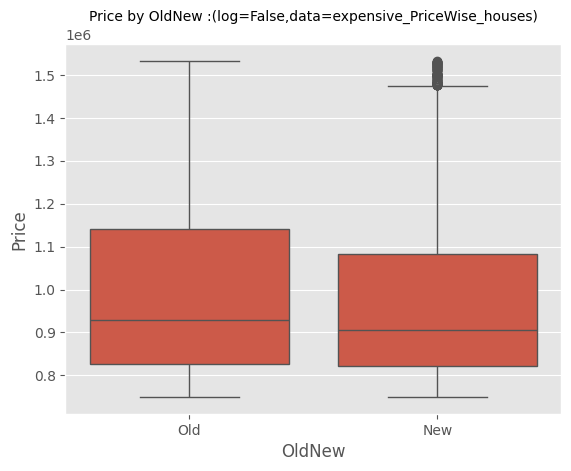

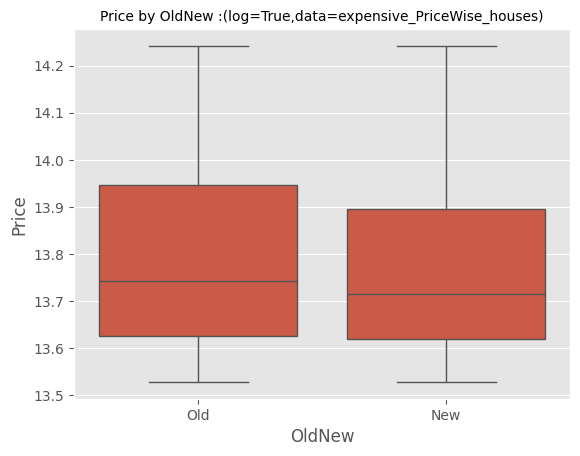

Old : (0,0)
New : (0,1)


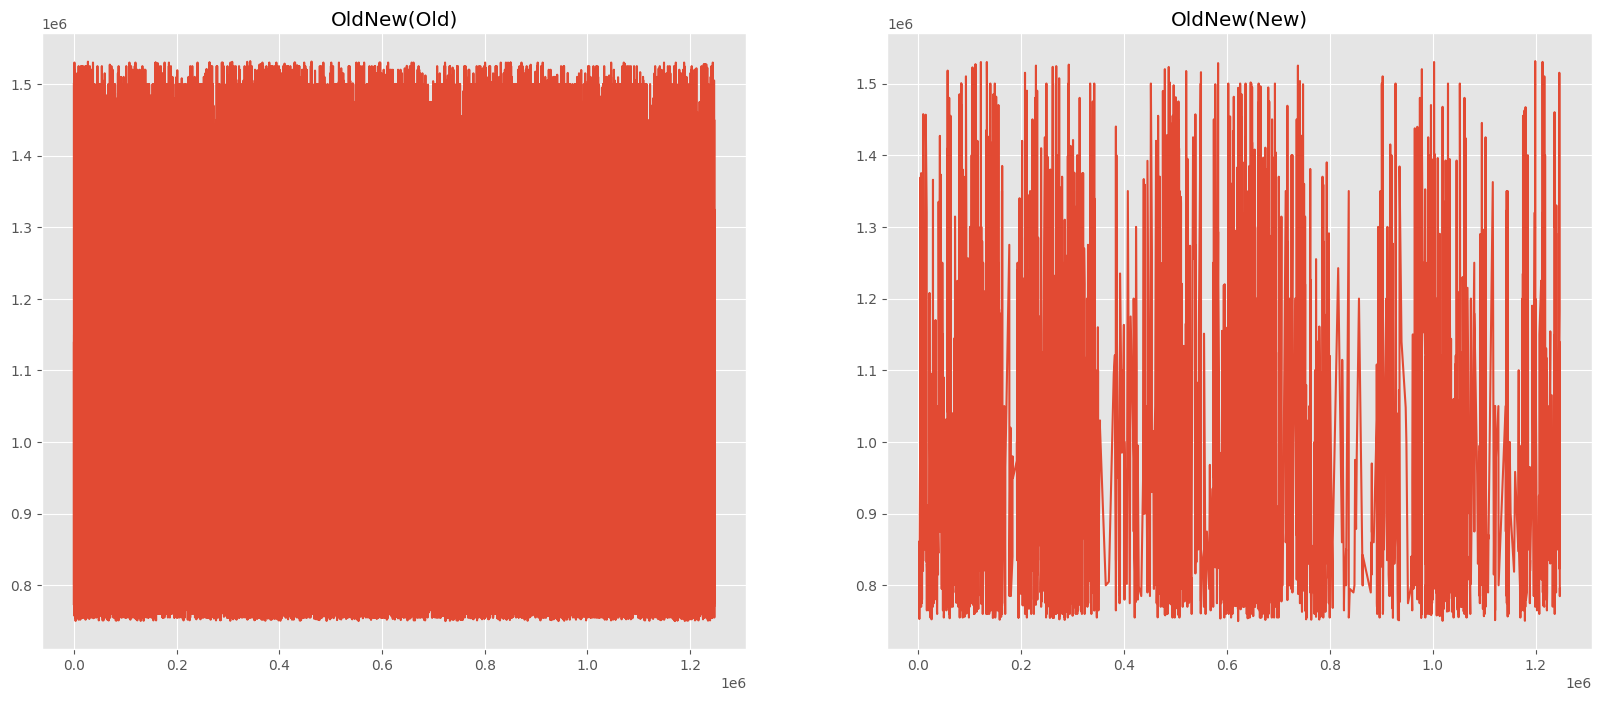

###################################################### County ######################################################


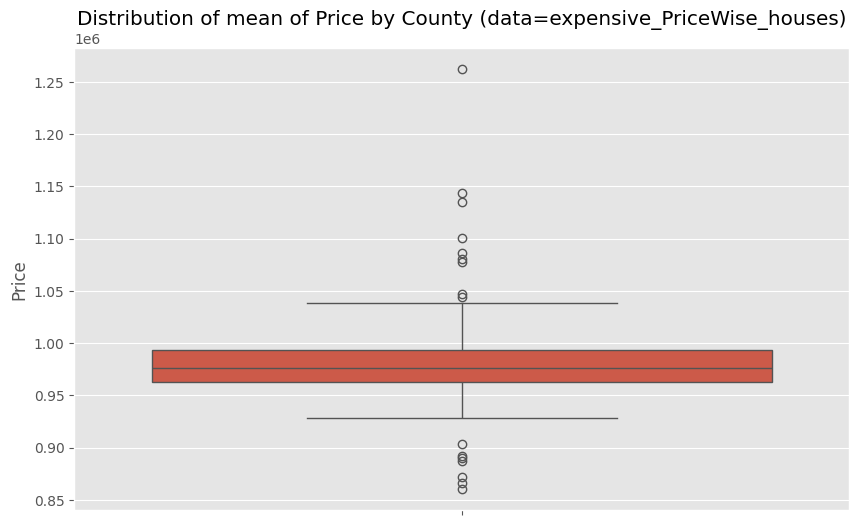

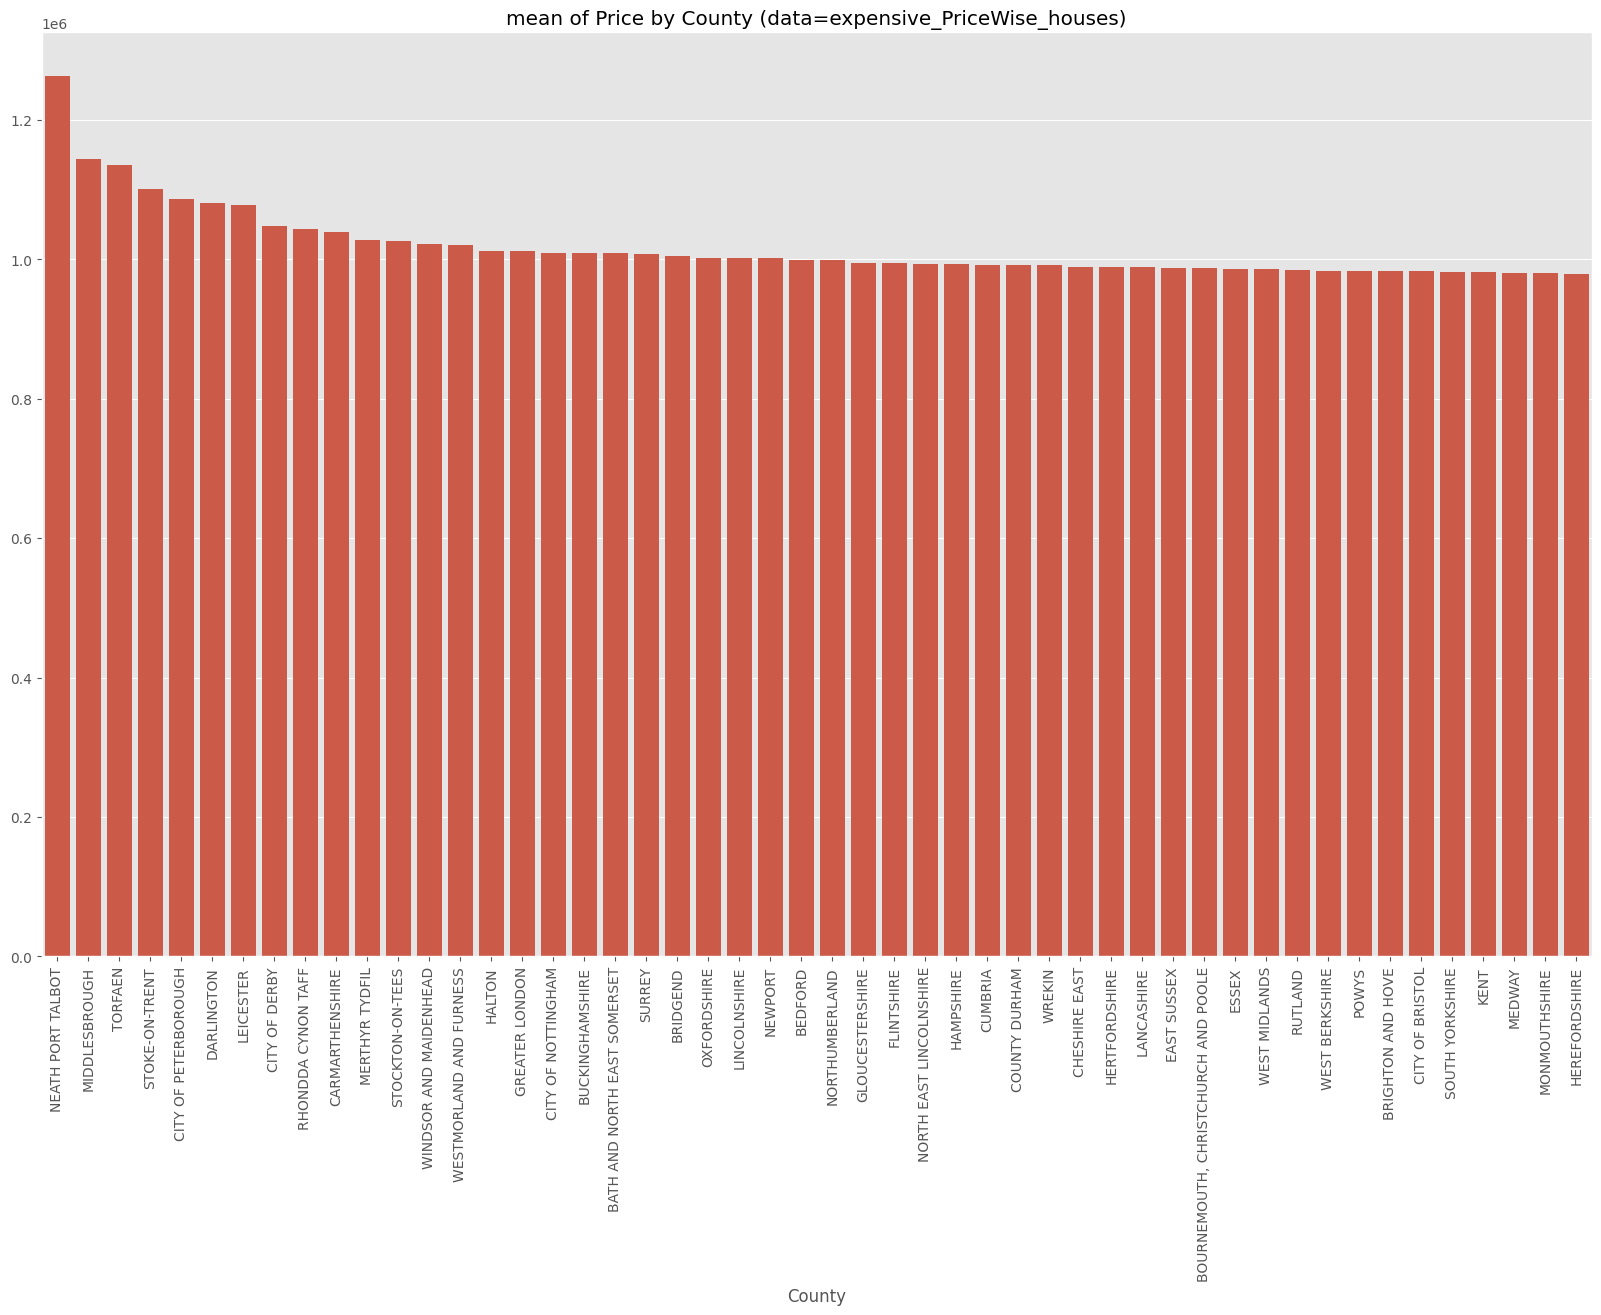

###################################################### District ######################################################


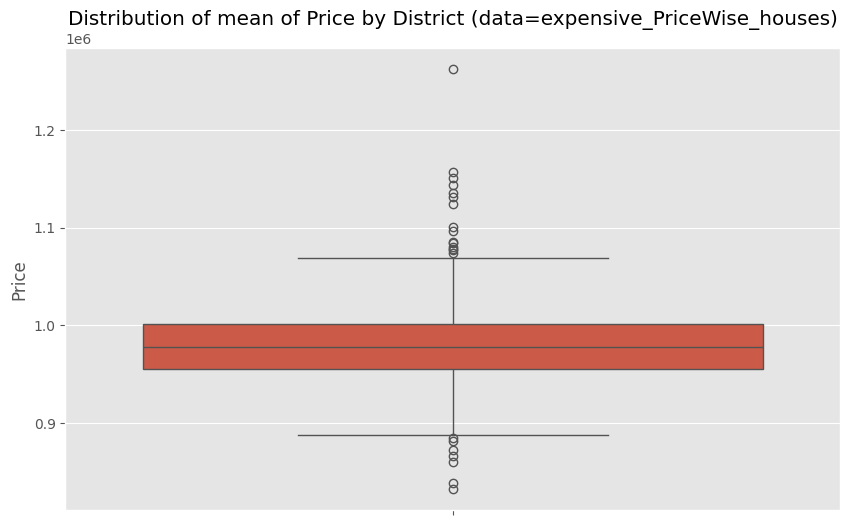

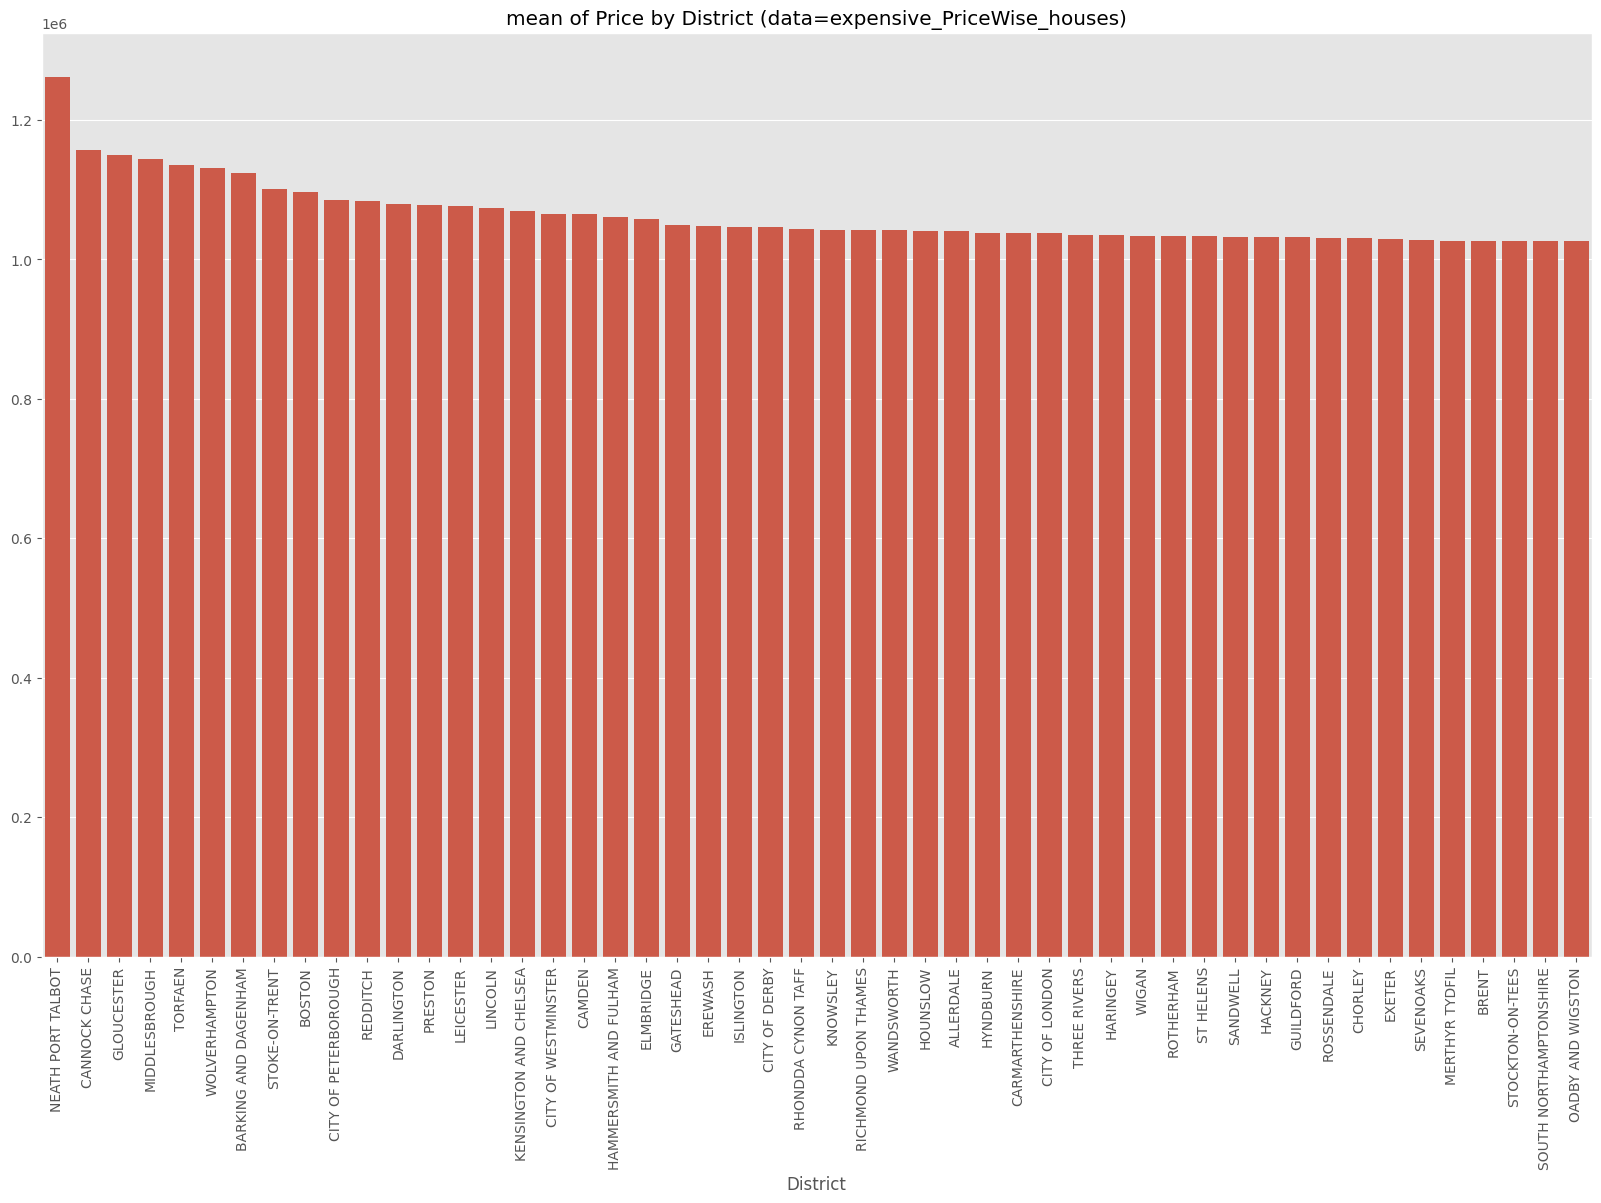

###################################################### TownCity ######################################################


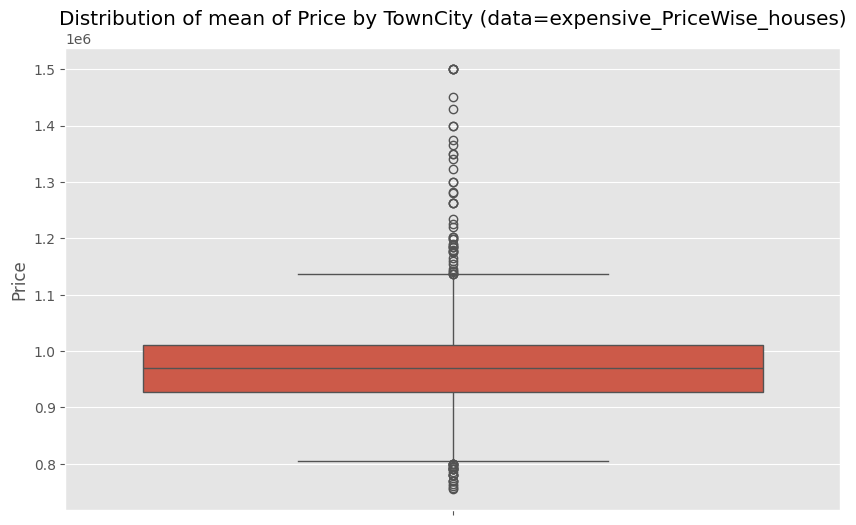

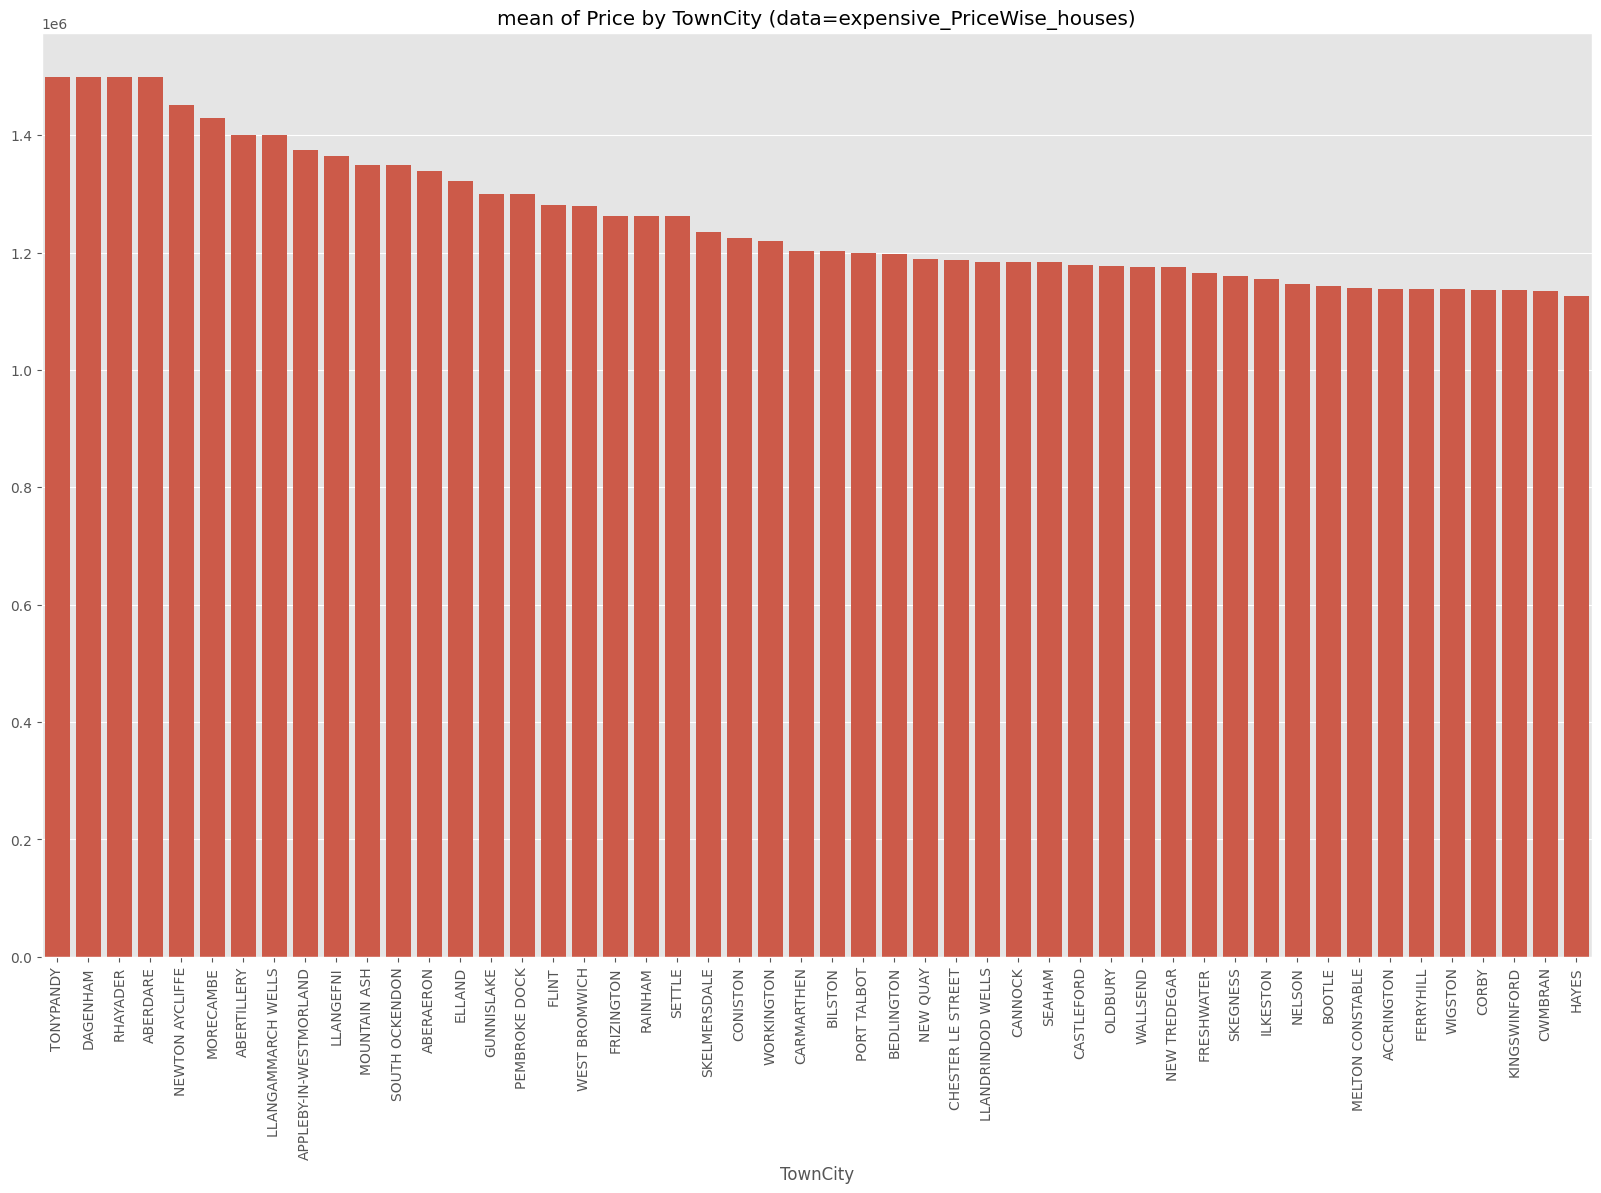

In [24]:
visualise_global(
    expensive_PriceWise_houses,
    grp_columns = ["PropertyType","Duration","OldNew"],
    geo_col = ["County","District","TownCity"],
    bins=100
)

### houses_regulated

- 'outliers_regularisation_method', 'groupbycolumns' are declared in "introduction" section

#### Regulate "expensive_PriceWise_houses" and merge it with "normal_PriceWise_houses"

In [25]:
reg_expensive_PriceWise_houses = expensive_PriceWise_houses.copy()
reg_expensive_PriceWise_houses['Price'] = regulate_outliers(
    df_data = expensive_PriceWise_houses, 
    method=outliers_regularisation_method, 
    groupby = groupbycolumns,
    bothsides=False,
    maxmin=False,
    df_reference=normal_PriceWise_houses
)

In [26]:
houses_regulated = pd.concat([normal_PriceWise_houses,reg_expensive_PriceWise_houses], axis=0)

In [27]:
houses_regulated = houses_regulated.loc[houses_regulated.Price.notna(),:]

In [28]:
houses_regulated.reset_index(drop=True,inplace=True)

In [29]:
houses_regulated['Price'] = regulate_outliers(
    df_data = houses_regulated, 
    method=outliers_regularisation_method, 
    groupby = groupbycolumns,
    bothsides=False,
    maxmin=False
)

#### Visualization

In [30]:
houses_regulated.describe()

Price  TransferMonth   TransferDay
count  1.213516e+06   1.213516e+06  1.213516e+06
mean   2.919378e+05   6.242366e+00  1.807436e+01
std    1.533832e+05   3.301344e+00  8.934263e+00
min    4.641600e+04   1.000000e+00  1.000000e+00
25%    1.719950e+05   3.000000e+00  1.100000e+01
50%    2.601975e+05   6.000000e+00  1.900000e+01
75%    3.850000e+05   9.000000e+00  2.600000e+01
max    7.500000e+05   1.200000e+01  3.100000e+01

###################################################### Price ######################################################


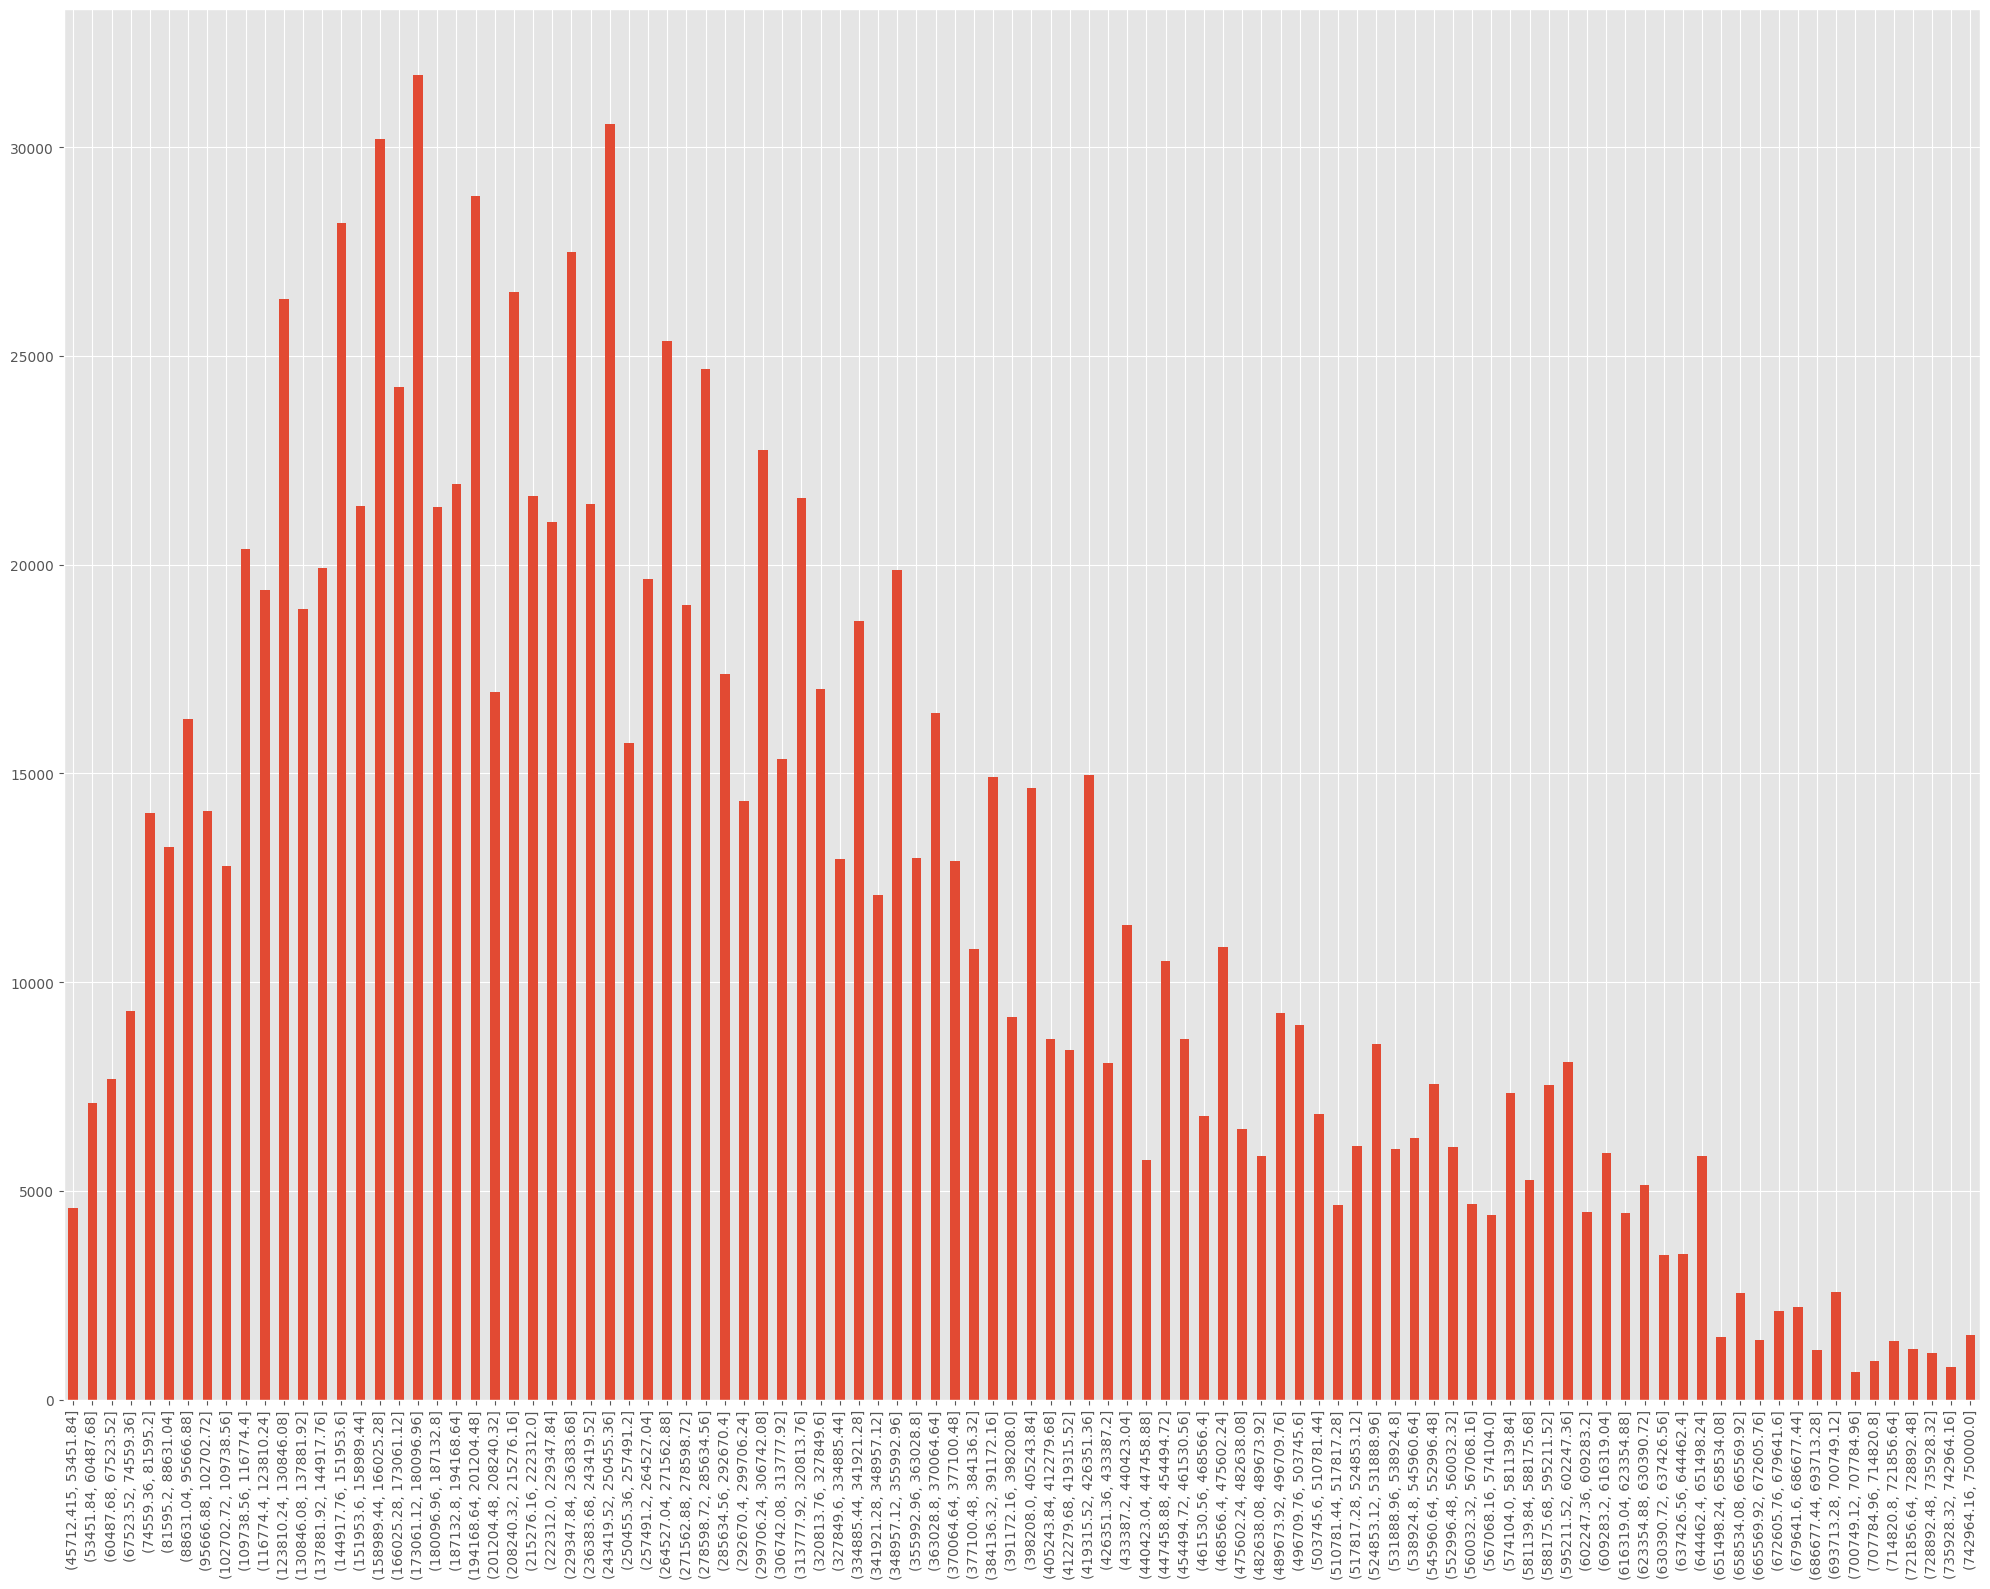

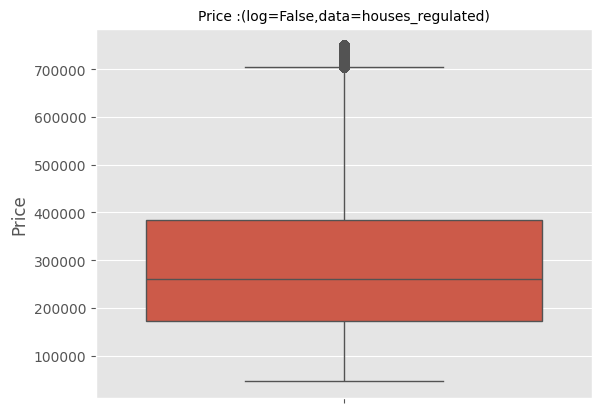

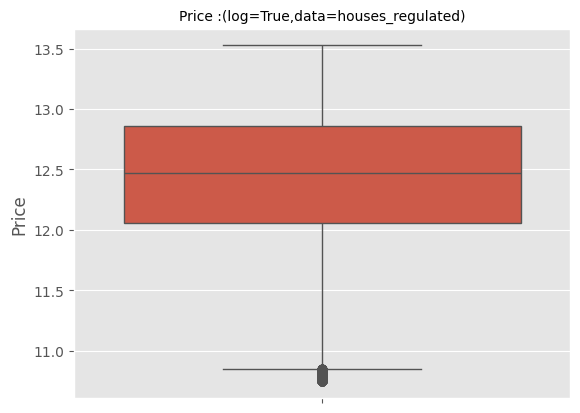

###################################################### PropertyType ######################################################


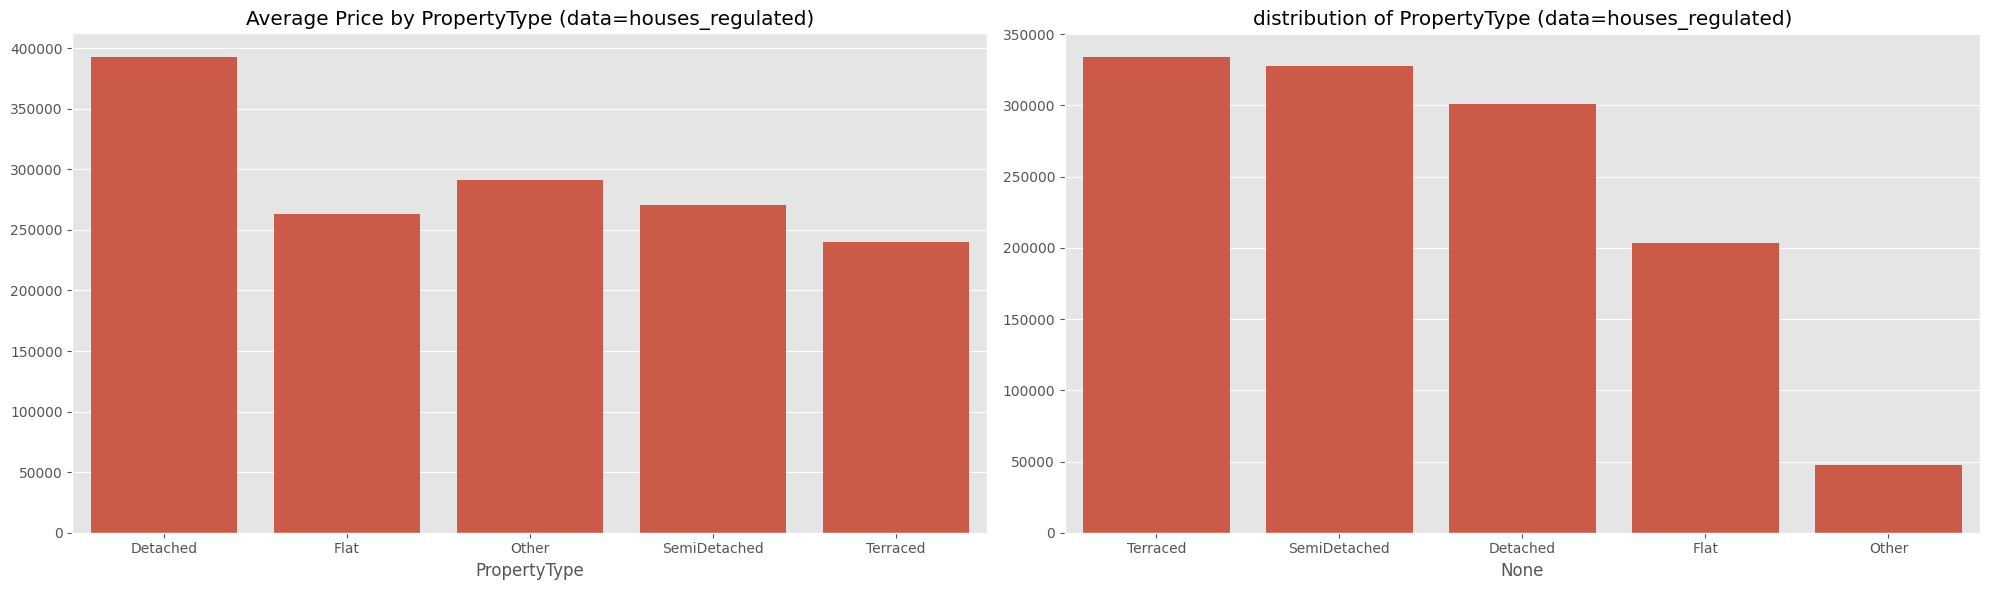

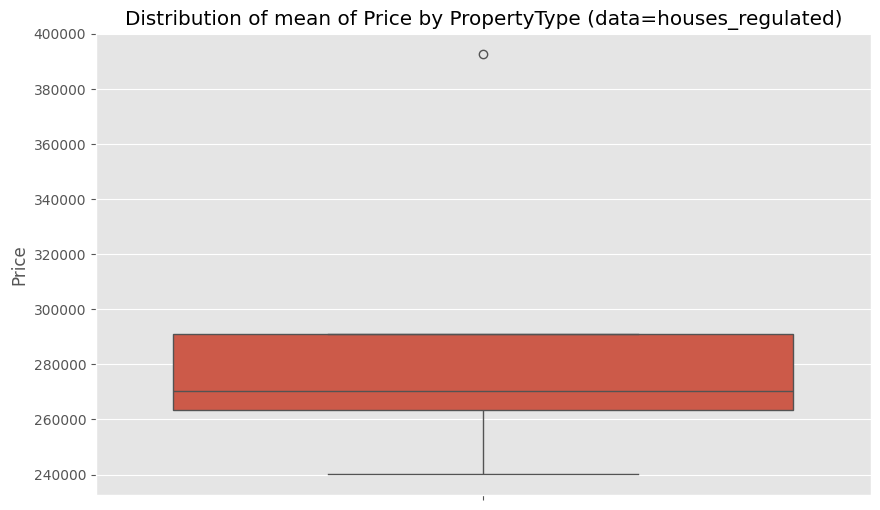

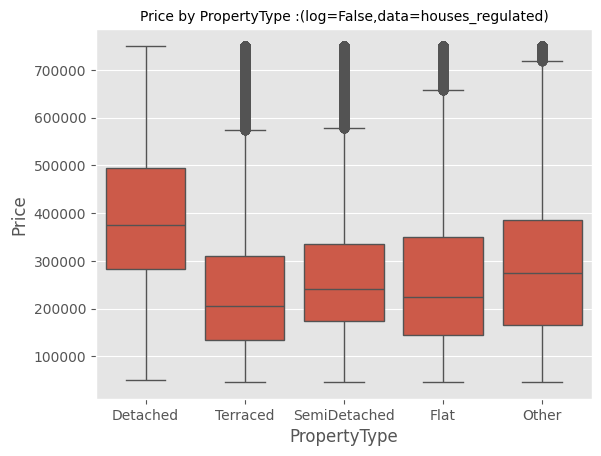

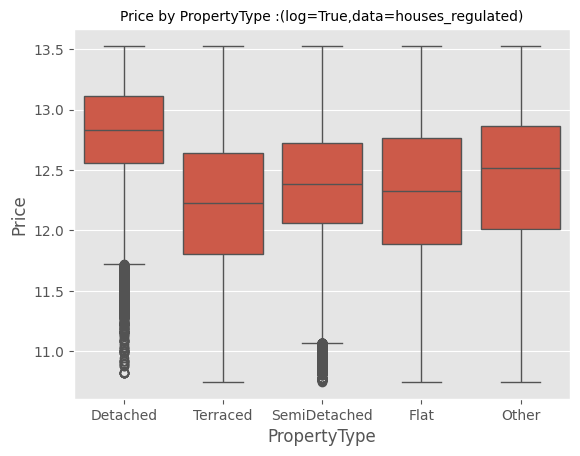

Terraced : (0,0)
SemiDetached : (0,1)
Detached : (1,0)
Flat : (1,1)
Other : (2,0)


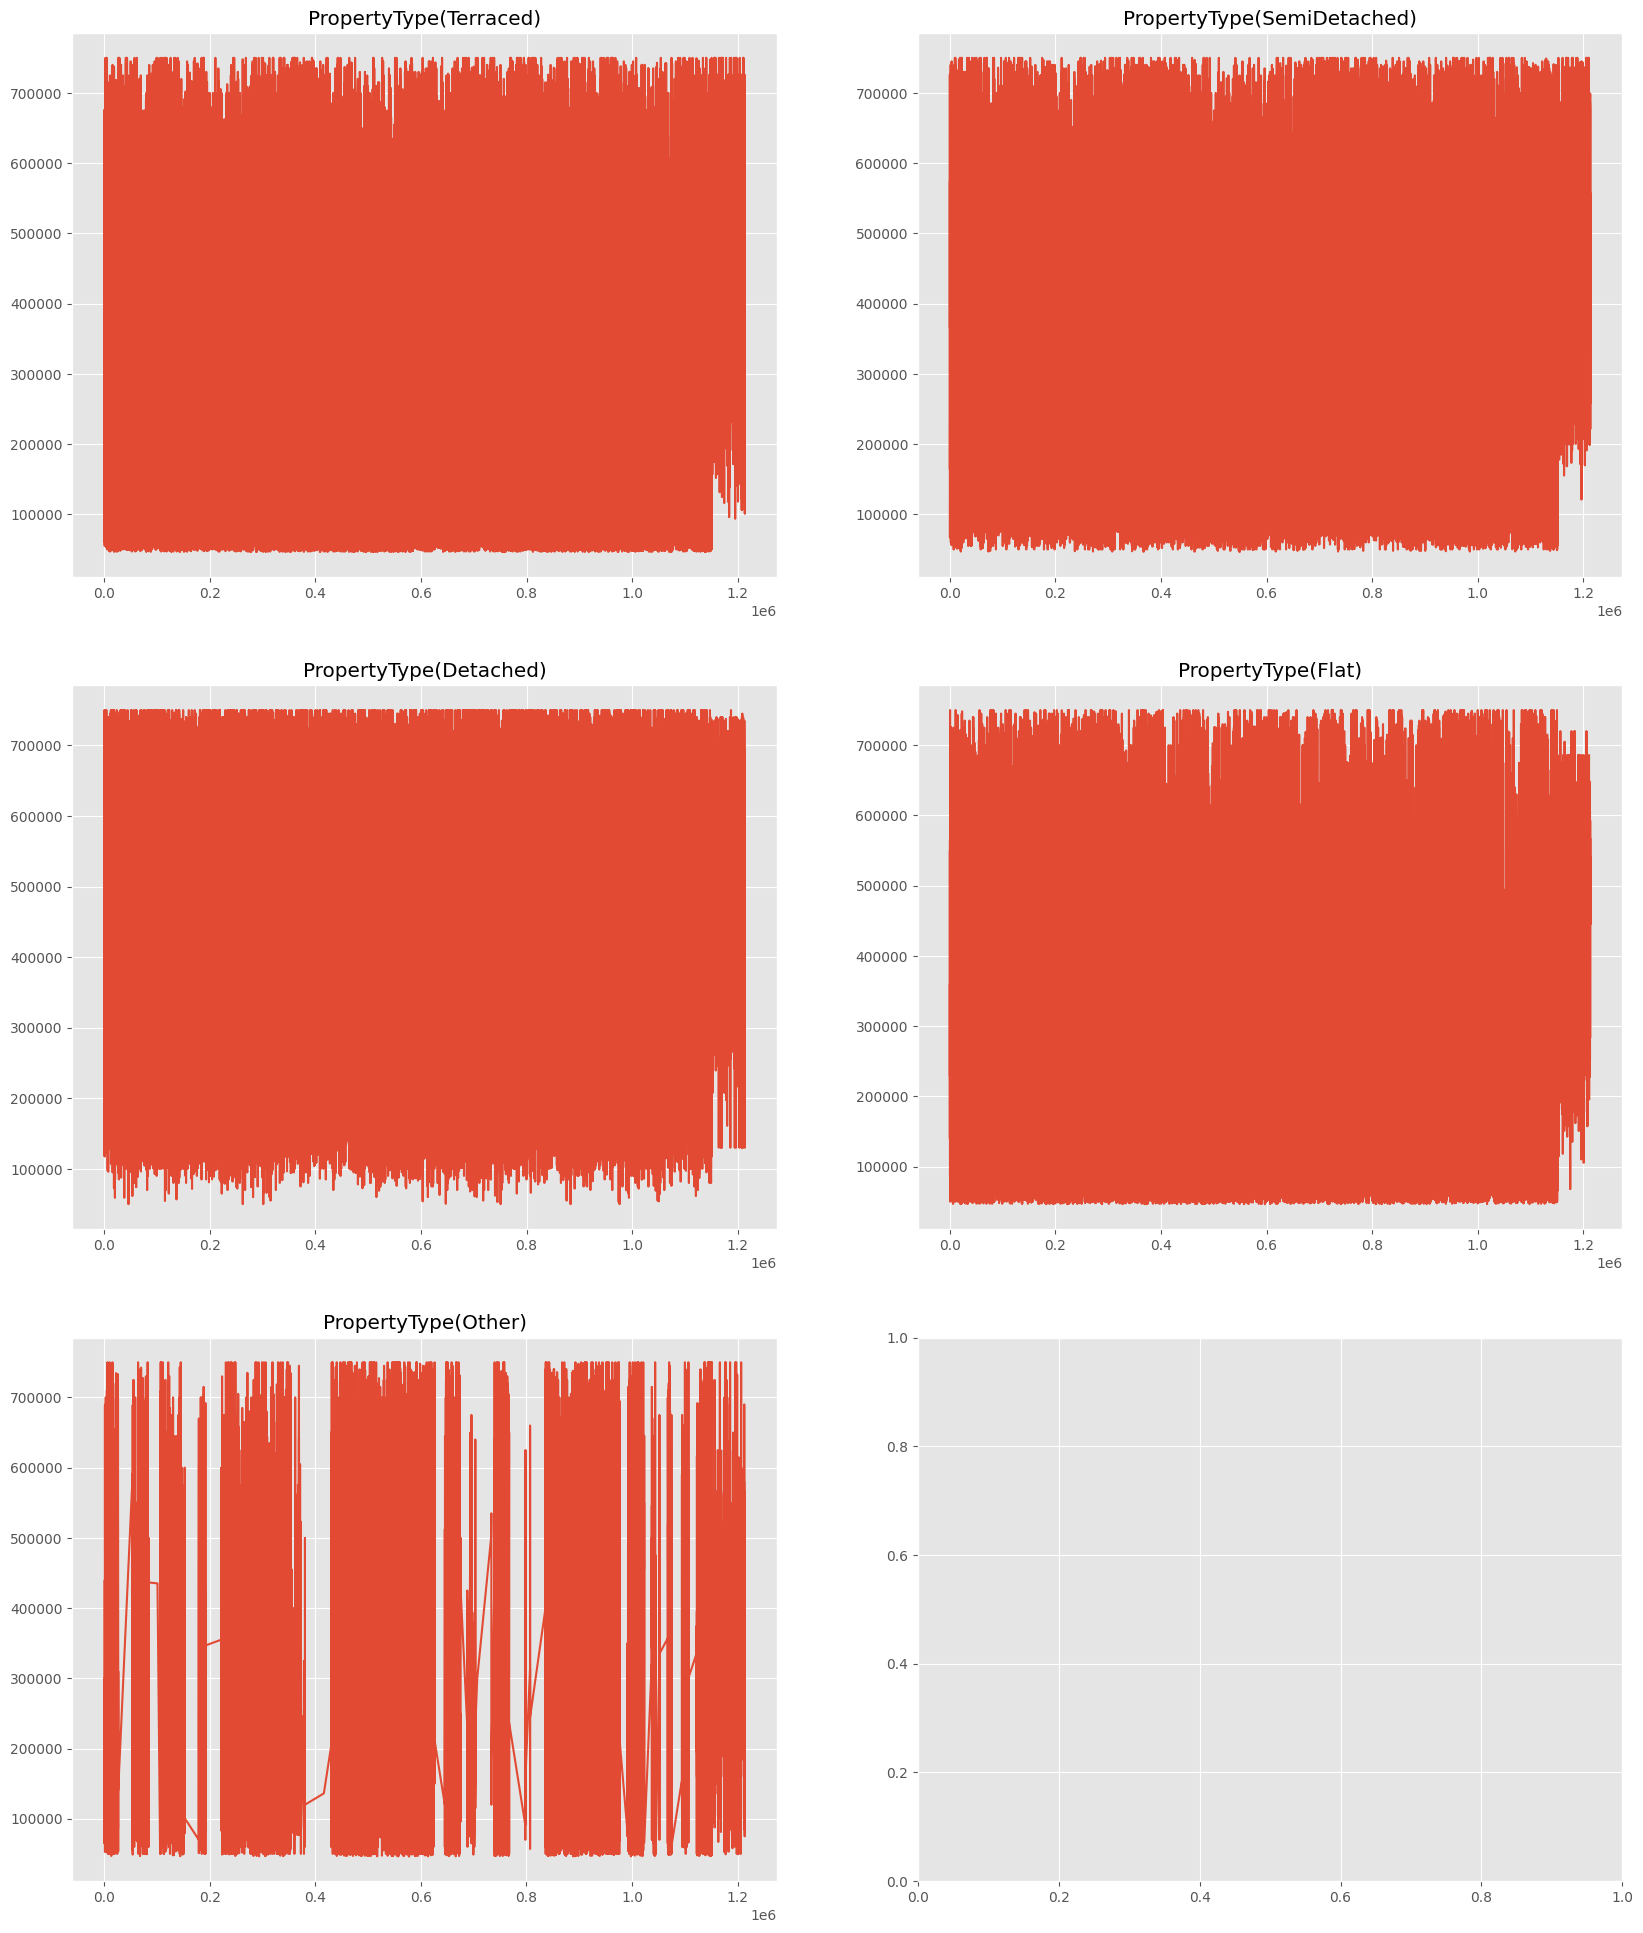

###################################################### Duration ######################################################


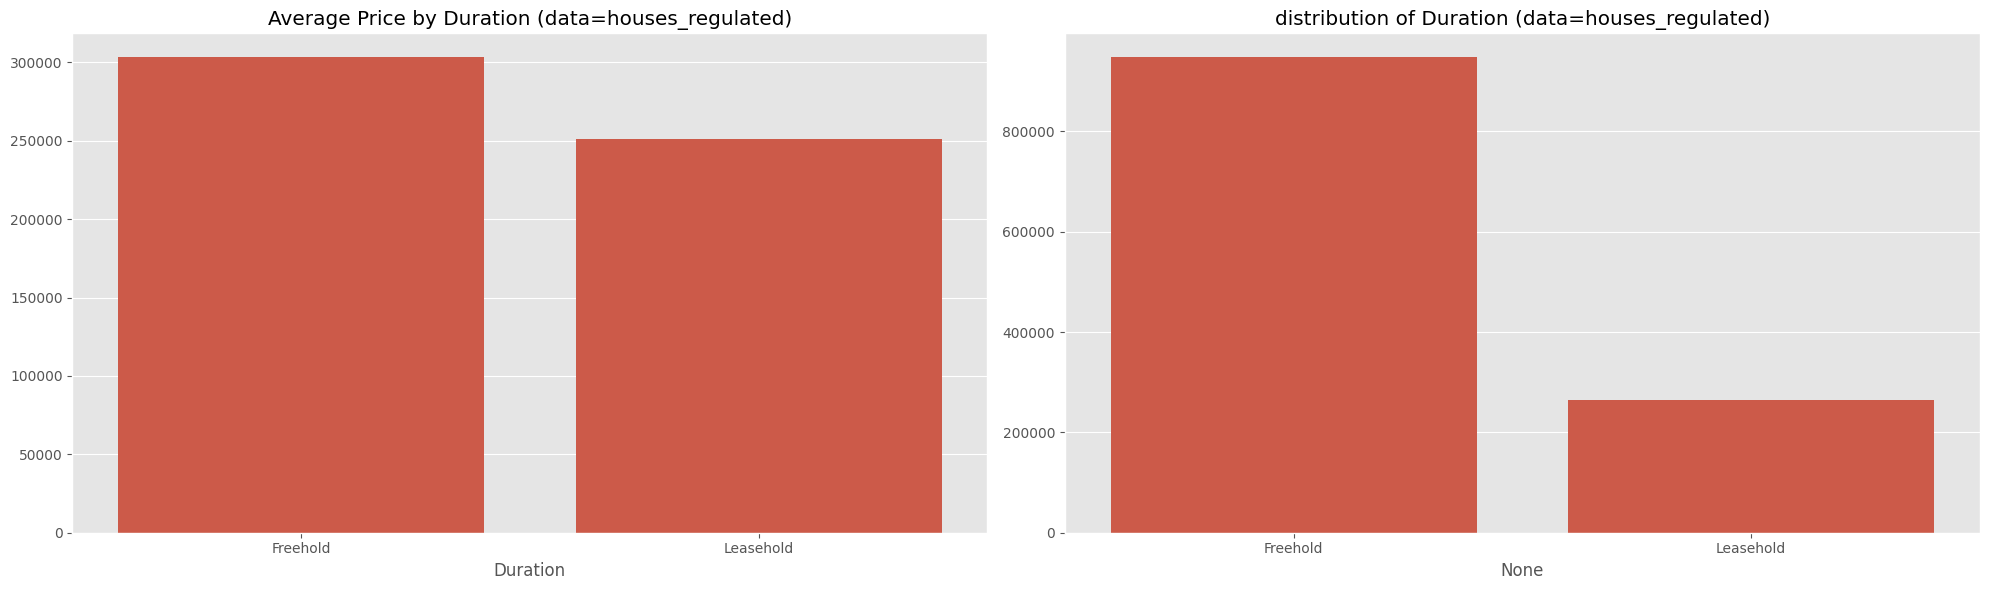

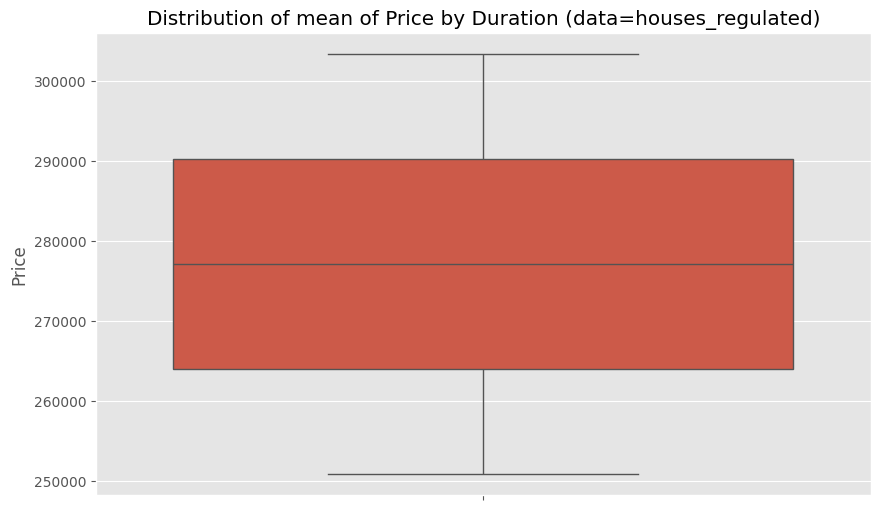

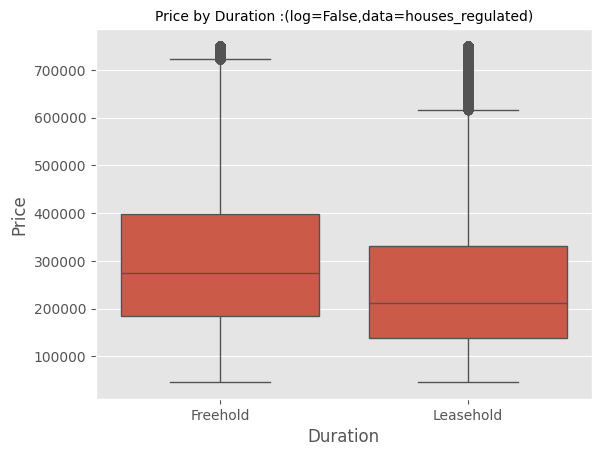

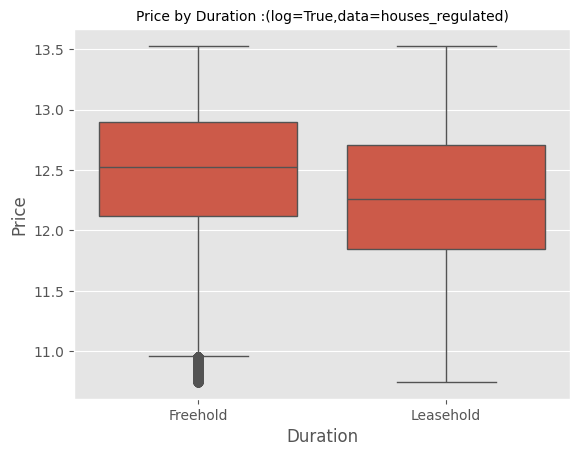

Freehold : (0,0)
Leasehold : (0,1)


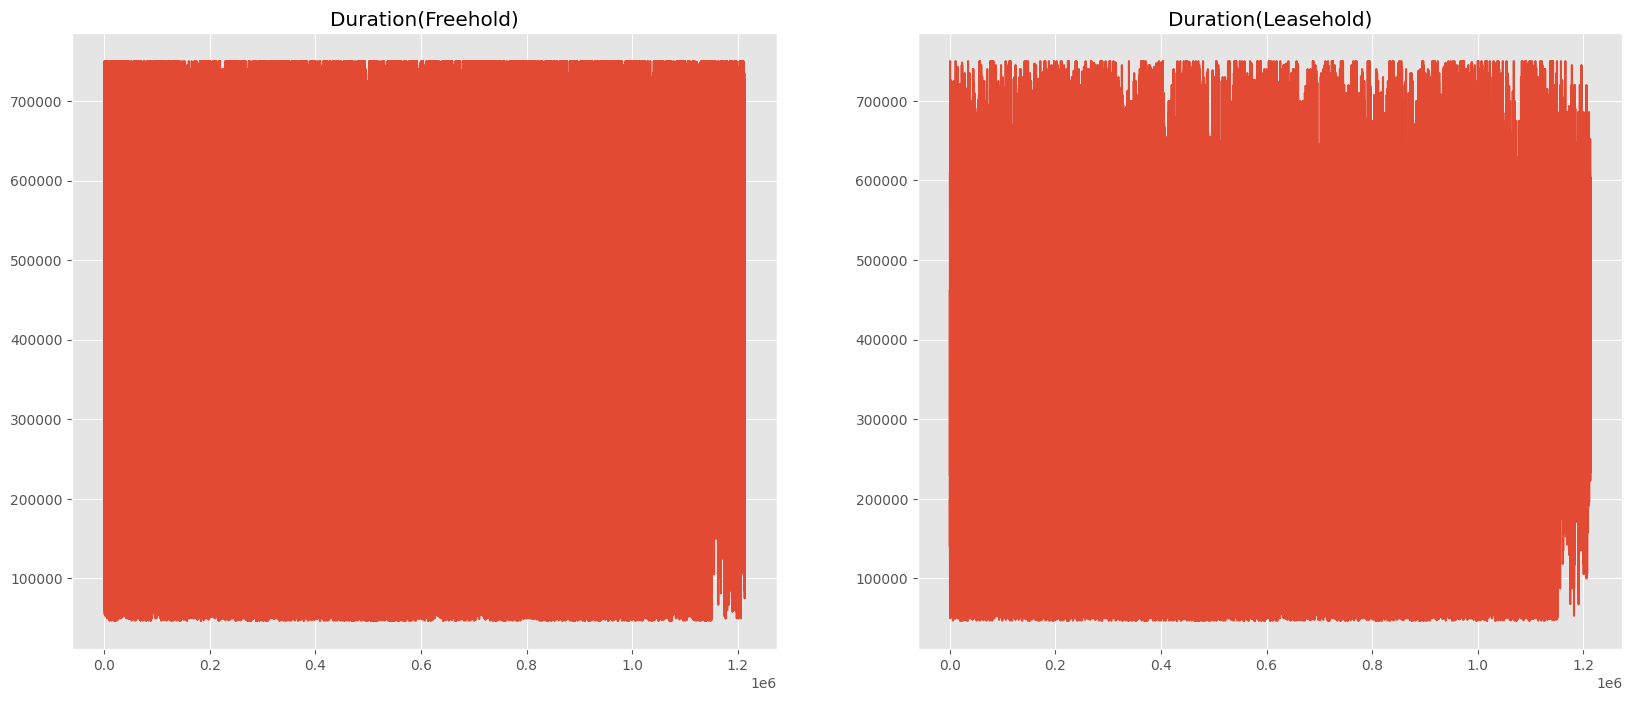

###################################################### OldNew ######################################################


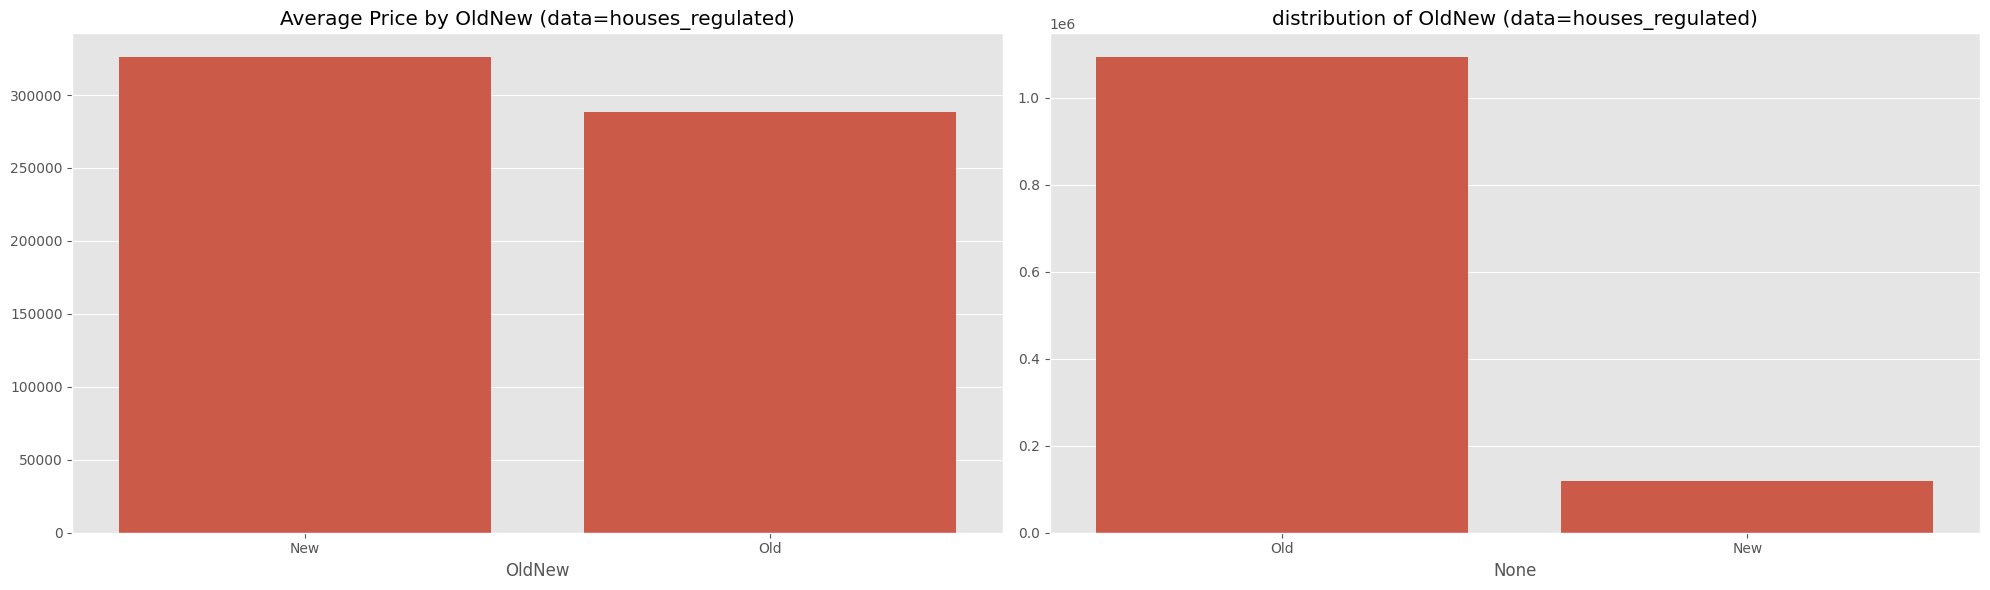

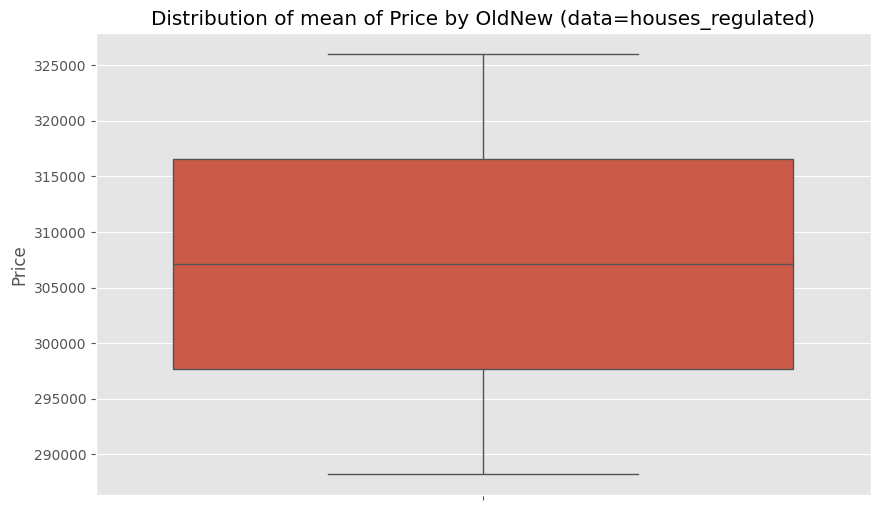

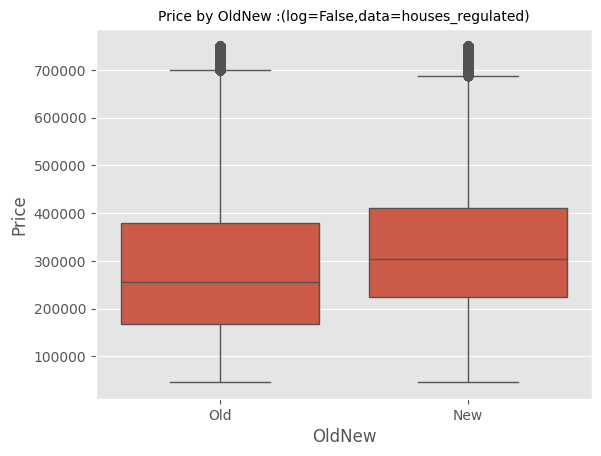

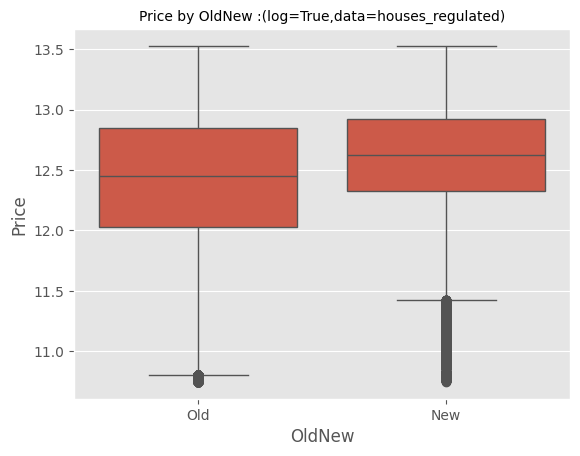

Old : (0,0)
New : (0,1)


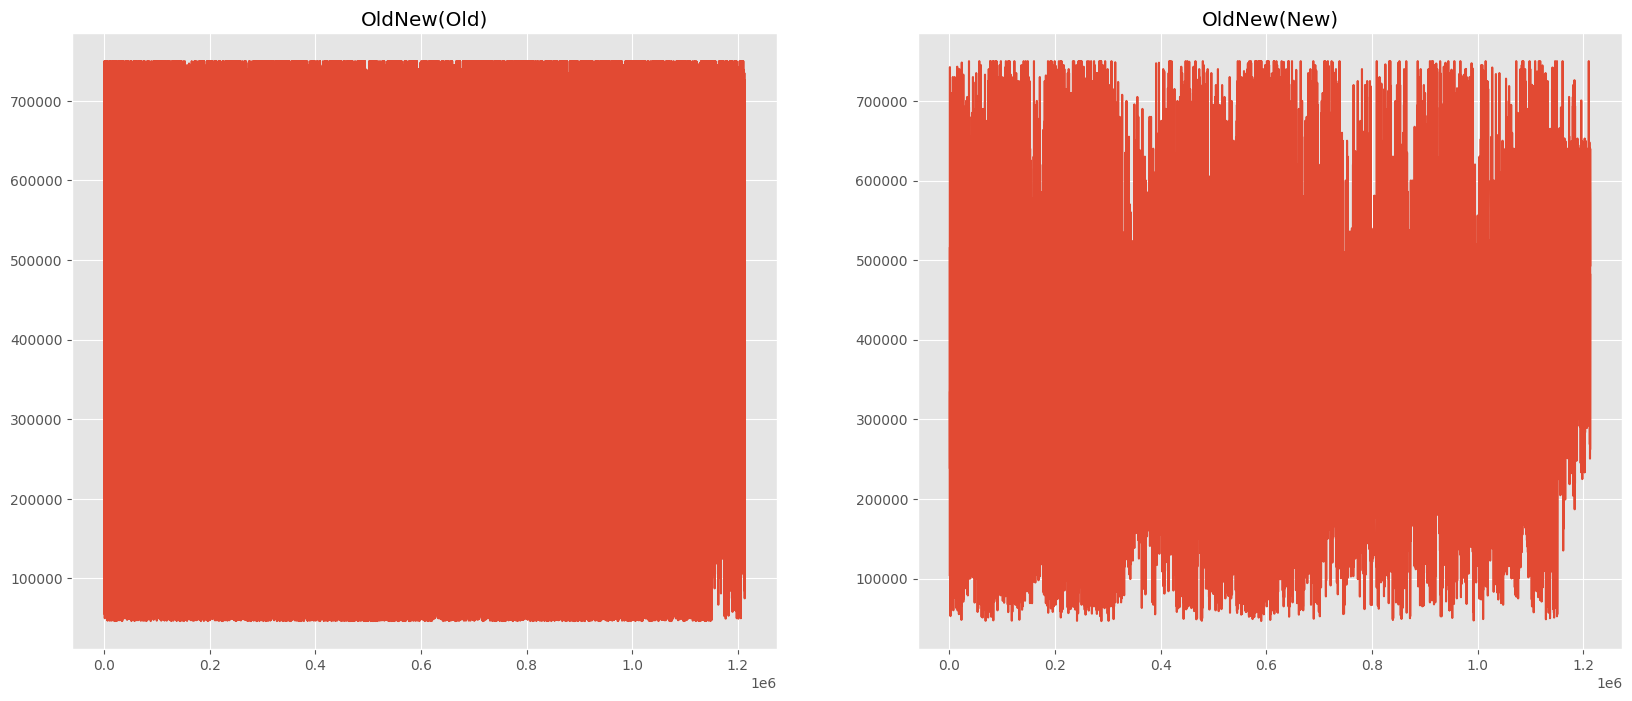

###################################################### County ######################################################


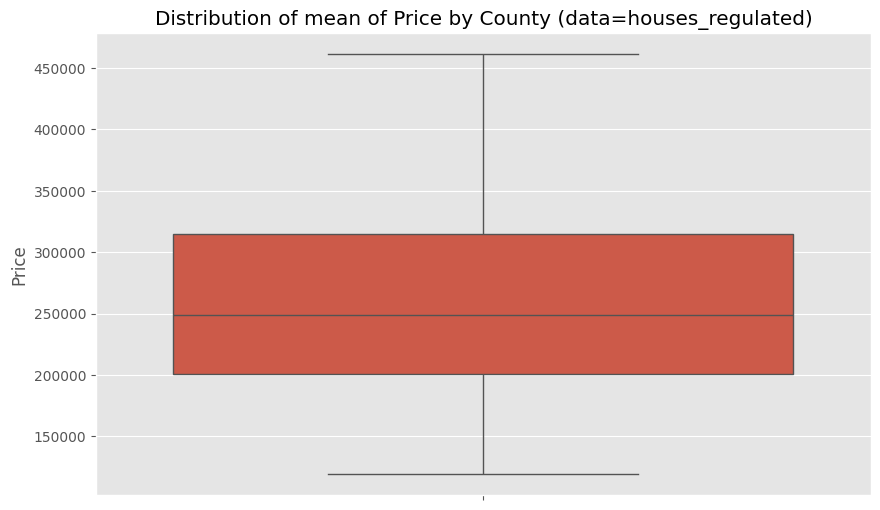

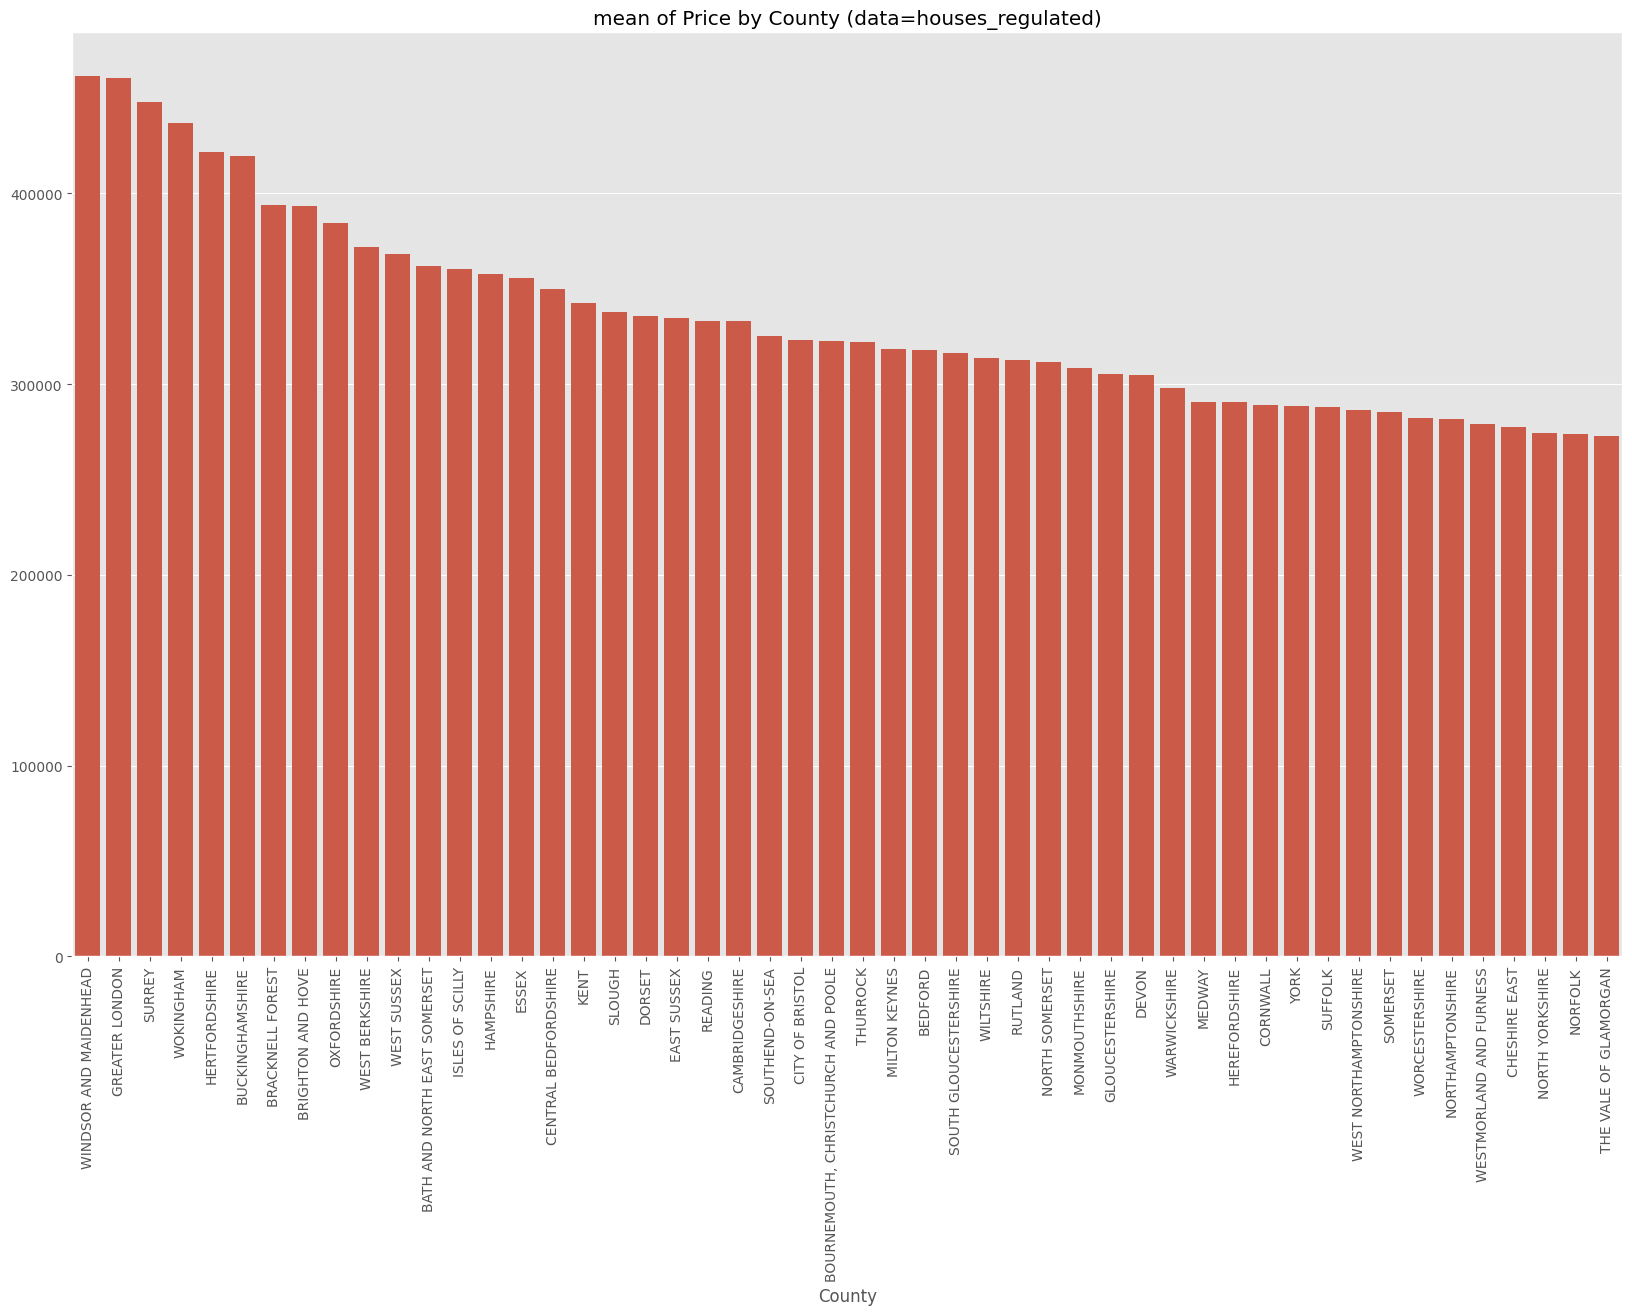

###################################################### District ######################################################


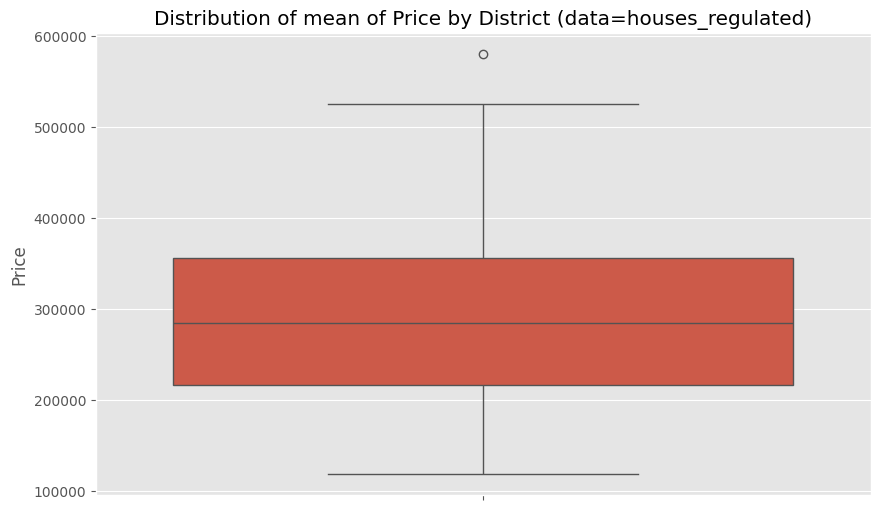

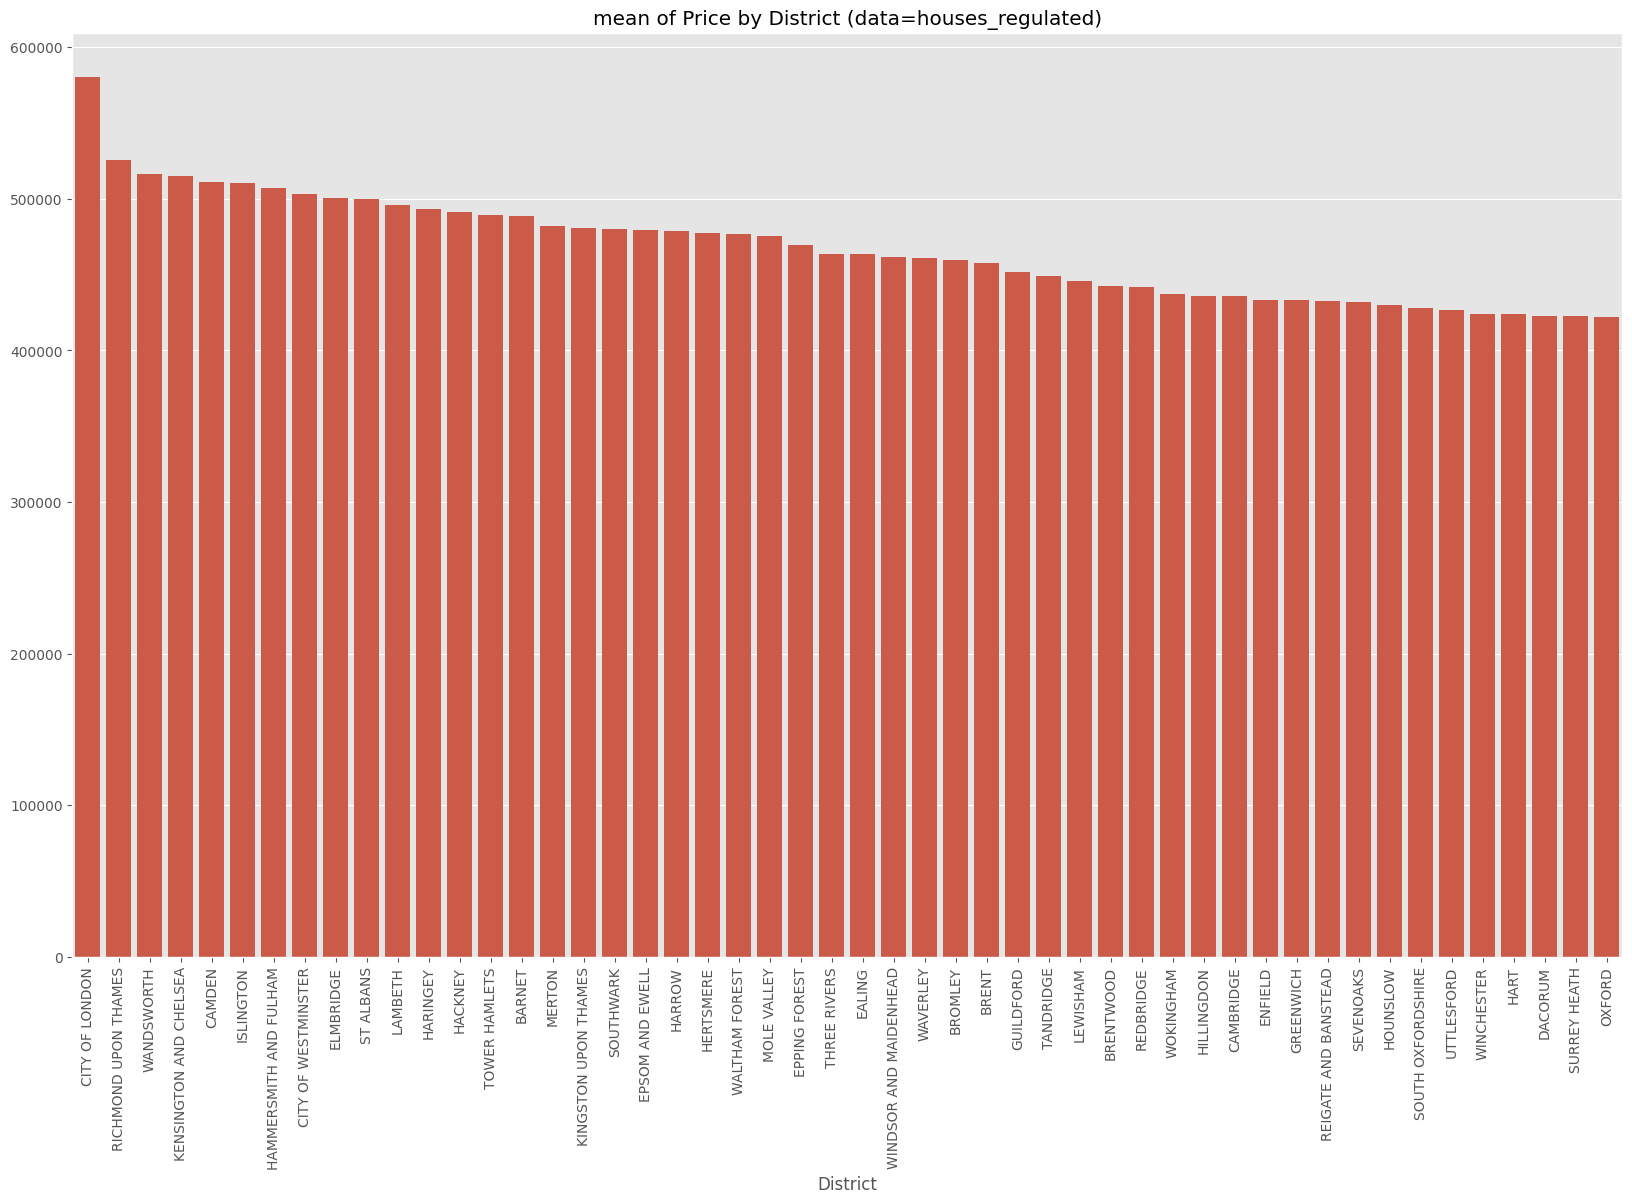

###################################################### TownCity ######################################################


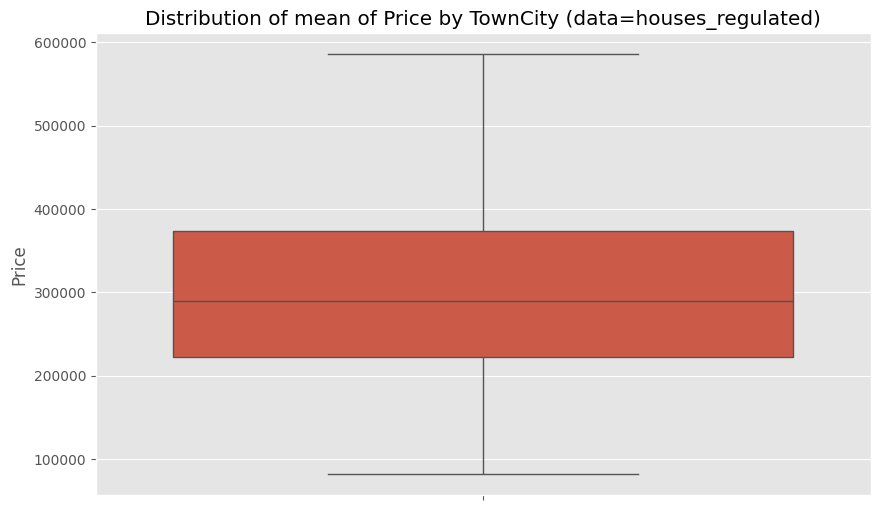

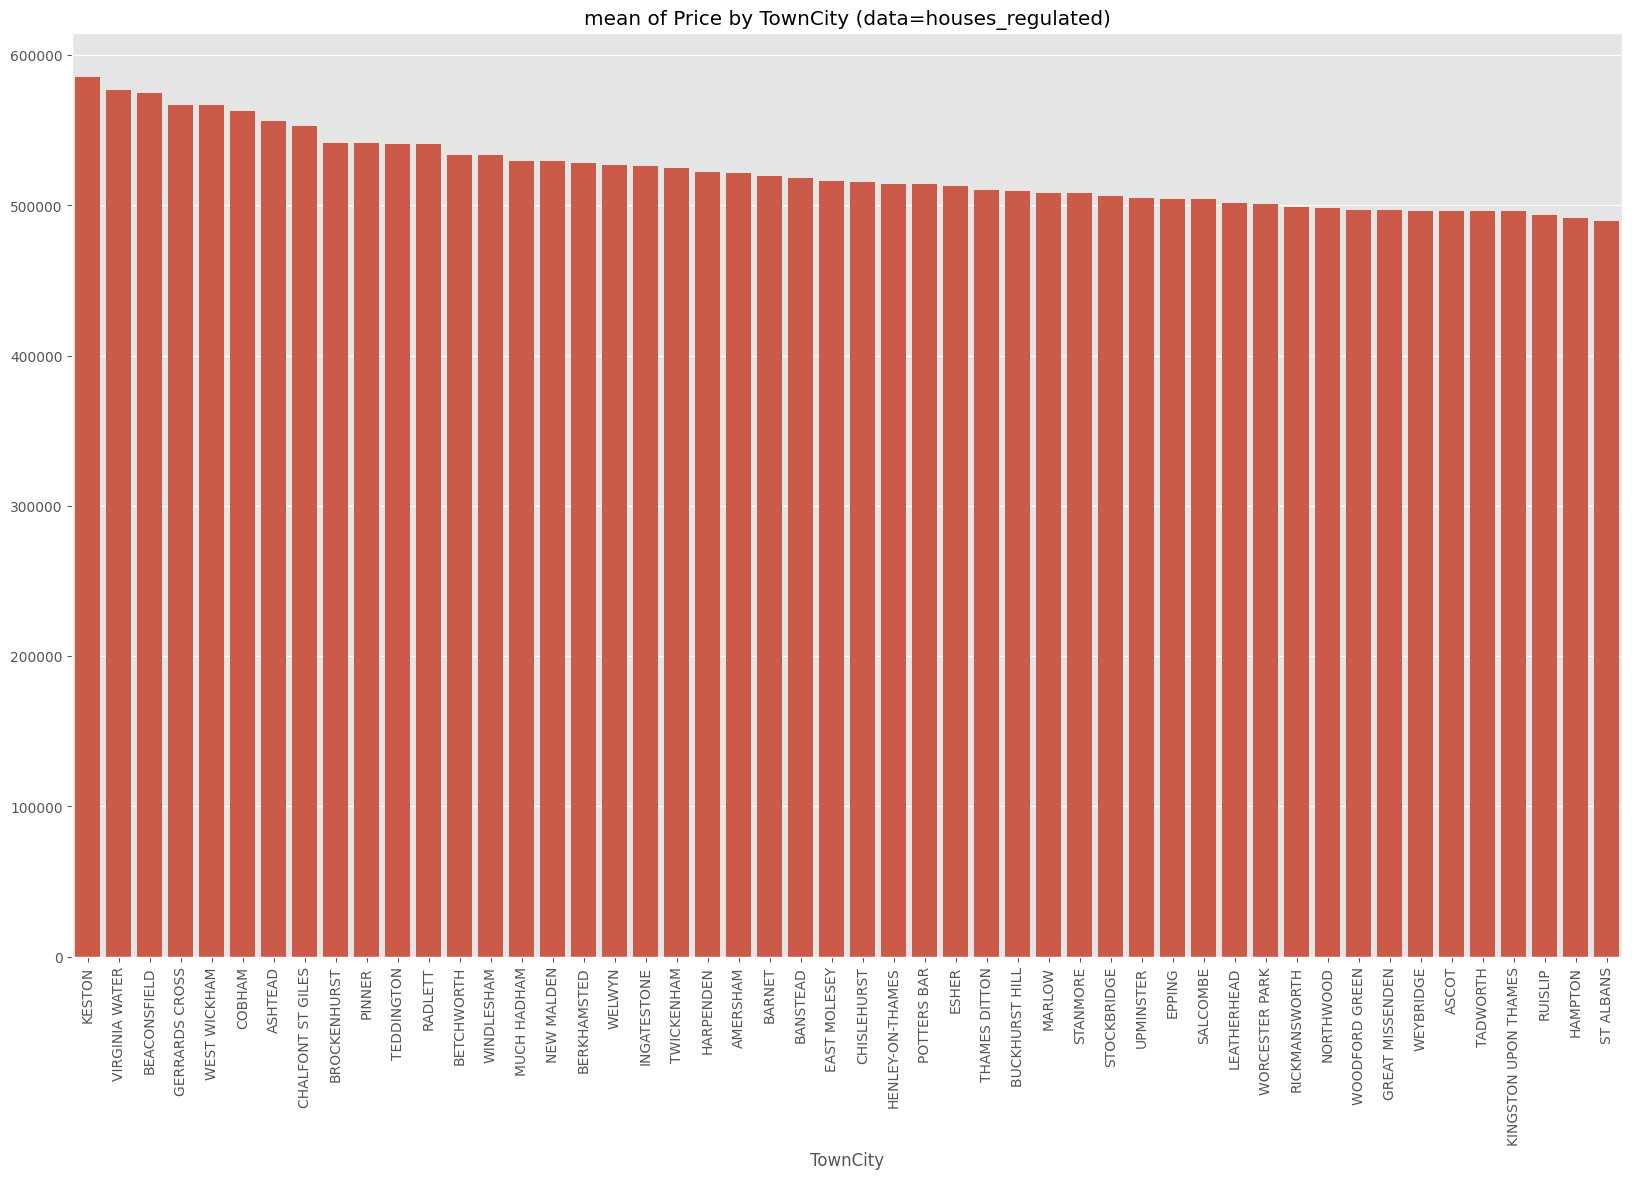

In [31]:
visualise_global(
    houses_regulated,
    grp_columns = ["PropertyType","Duration","OldNew"],
    geo_col = ["County","District","TownCity"]
)

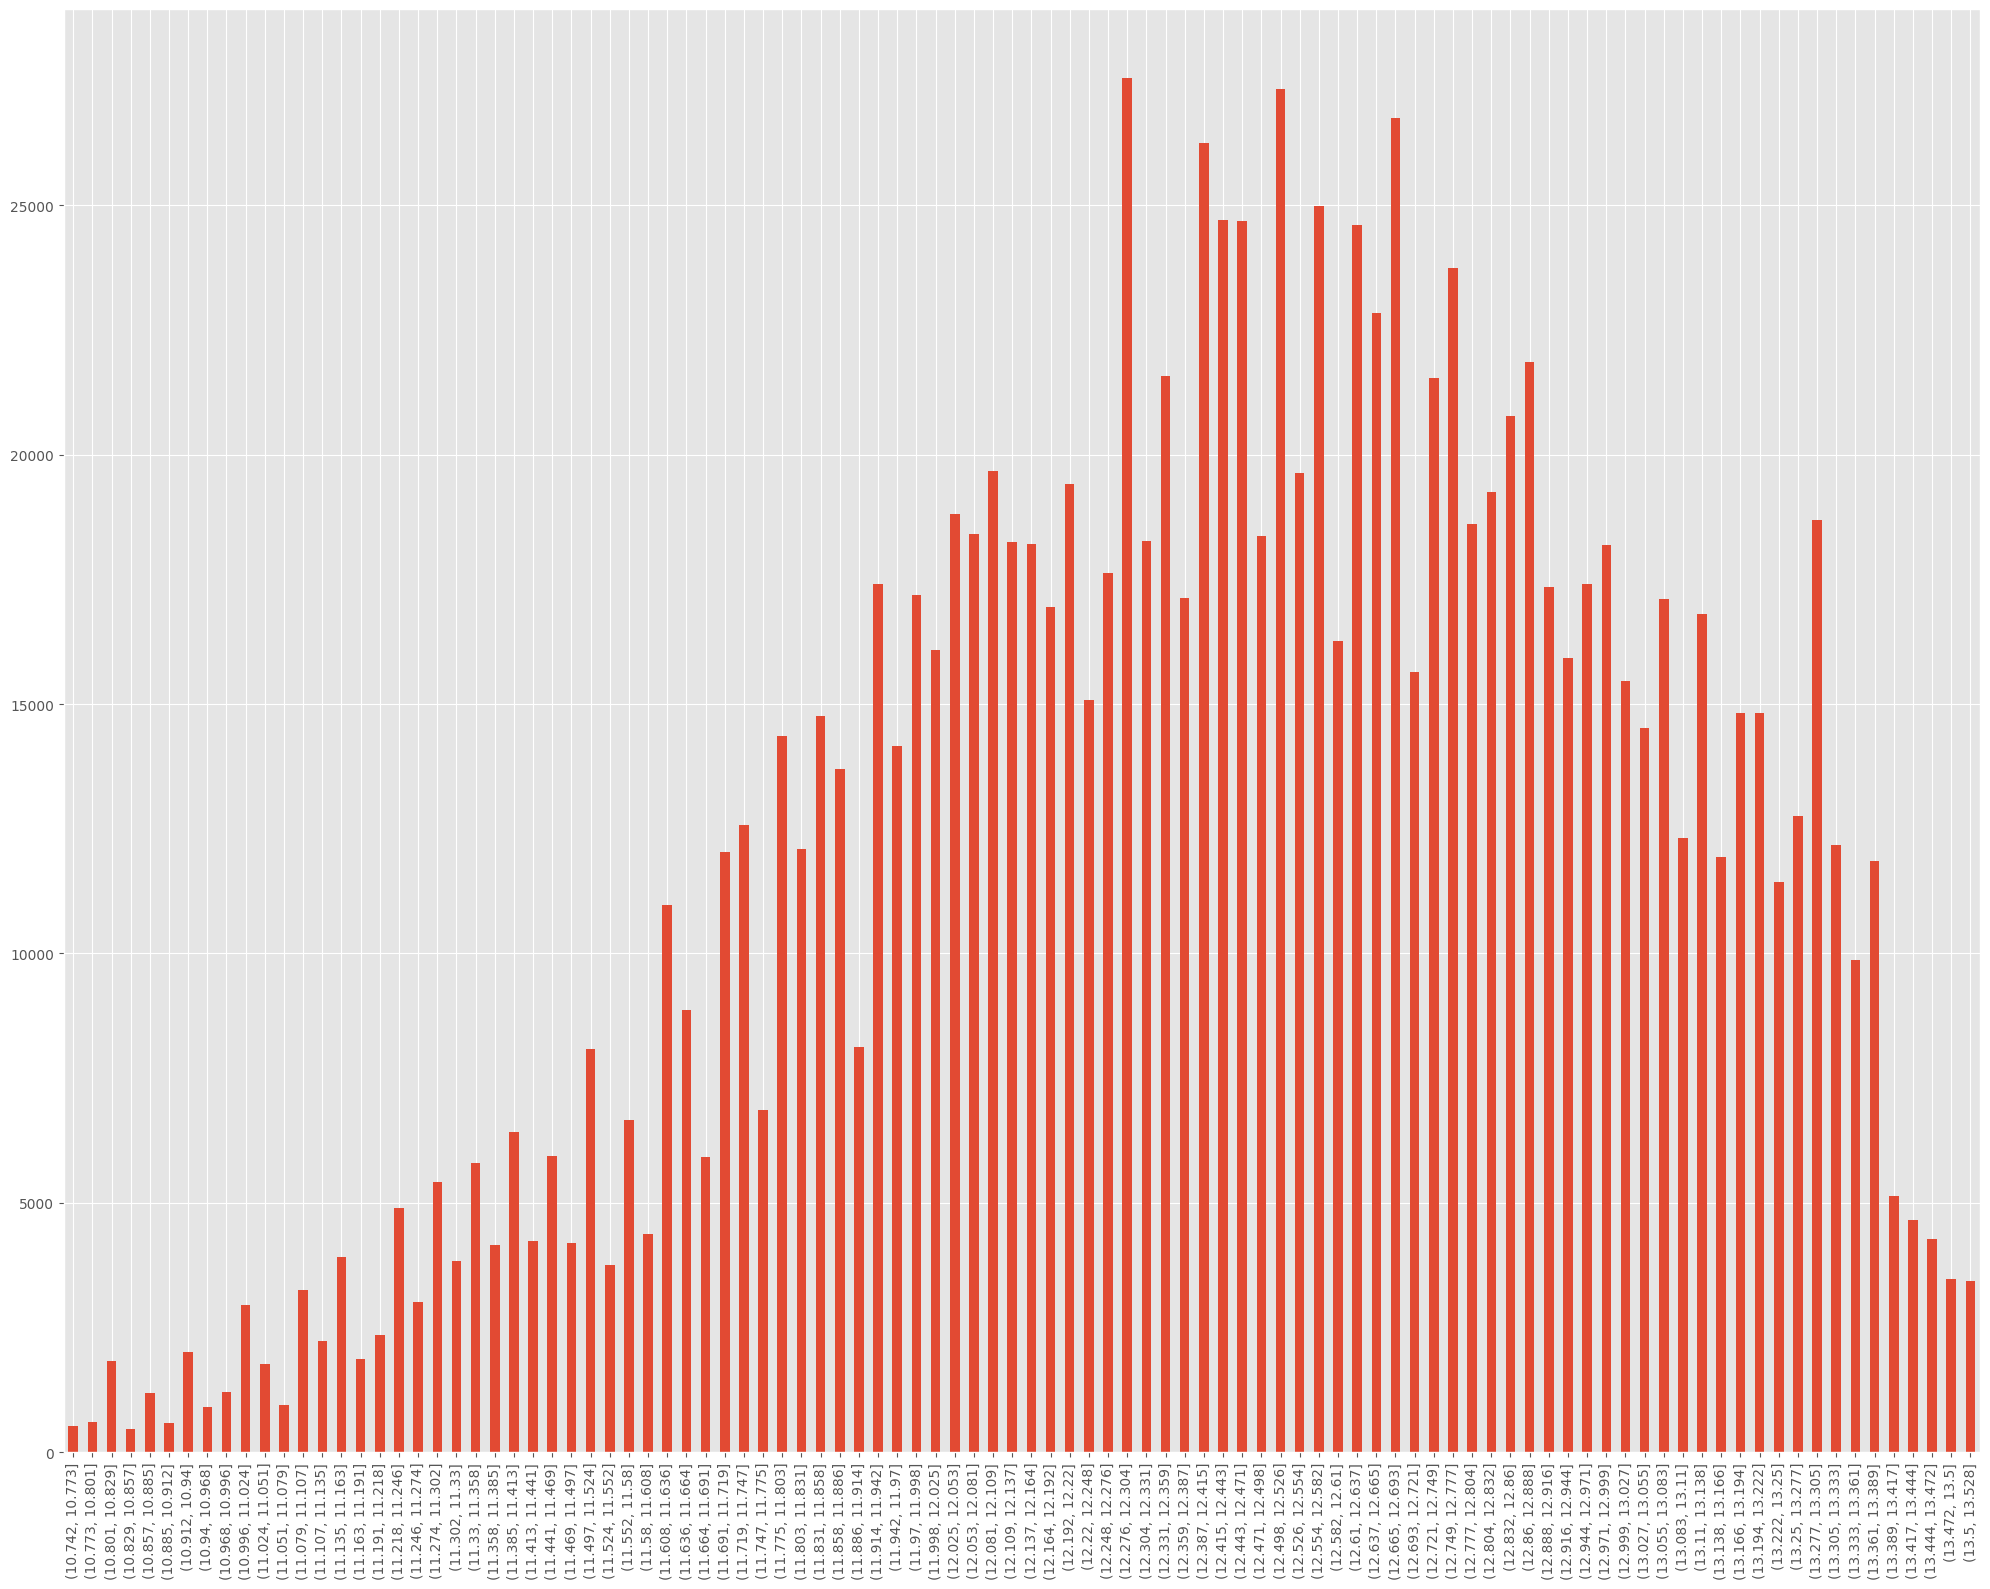

In [32]:
price_distribution(houses_regulated,bins=100,kind='bar',transform_log=1)

### Houses

In [33]:
houses = houses_regulated.copy()
houses.reset_index(drop=True,inplace=True)

In [34]:
houses.isna().sum()

Id                       0
Price                    0
TransferDate             0
Postcode              1967
PropertyType             0
OldNew                   0
Duration                 0
PAON                     0
SAON               1064824
Street               23182
Locality            739953
TownCity                 0
District                 0
County                   0
PPDCategoryType          0
RecordStatus             0
TransferMonth            0
TransferDay              0
PostcodeArea             0
dtype: int64

#### "Weights" Feature

In [35]:
weight_func = lambda x:x

##### Categorise Features weights

###### County

In [36]:
categorised_counties_data = categorise(
    col="County",
    df_data=houses,
    weight_func = weight_func
)
houses.loc[:,'CountyWeights'] = categorised_counties_data['CountyWeights']
counties_weights = categorised_counties_data['categories_weights']

In [38]:
data_counties_weights = {
    "counties_weights" : counties_weights.to_dict()
}
# write_json(data_counties_weights,isNew=True)

###### District

In [39]:
categorised_districts_data = categorise(
    col="District",
    df_data=houses,
    weight_func = weight_func
)
houses.loc[:,'DistrictWeights'] = categorised_districts_data['DistrictWeights']
districts_weights = categorised_districts_data['categories_weights']

In [40]:
data_districts_weights = {
    "districts_weights" : districts_weights.to_dict()
}
# write_json(data_districts_weights)

###### TownCity

In [41]:
categorised_cities_data = categorise(
    col="TownCity",
    df_data=houses,
    weight_func = weight_func
)
houses.loc[:,'TownCityWeights'] = categorised_cities_data['TownCityWeights']
cities_weights = categorised_cities_data['categories_weights']

In [42]:
data_cities_weights = {
    "cities_weights" : cities_weights.to_dict()
}
# write_json(data_cities_weights)

###### Postcode

In [43]:
categorised_PostcodeArea_data = categorise(
    col="PostcodeArea",
    df_data=houses,
    weight_func = weight_func
)
houses.loc[:,'PostcodeAreaWeights'] = categorised_PostcodeArea_data['PostcodeAreaWeights']
PostcodeArea_weights = categorised_PostcodeArea_data['categories_weights']

In [44]:
data_PostcodeArea_weights = {
    "PostcodeArea_weights" : PostcodeArea_weights.to_dict()
}
# write_json(data_PostcodeArea_weights)

##### Load Features weights

In [46]:
weights_data = load_json()
weights_dicts = {
    'PostcodeArea' : weights_data["PostcodeArea_weights"],
    'TownCity' : weights_data["cities_weights"],
    'District' : weights_data["districts_weights"],
    'County' : weights_data["counties_weights"]
}

for k,v in weights_dicts.items():
    houses.loc[:,k+'Weights'] = houses.apply(lambda x:v[x[k]],axis=1)

##### Visualisation

###################################################### Price ######################################################


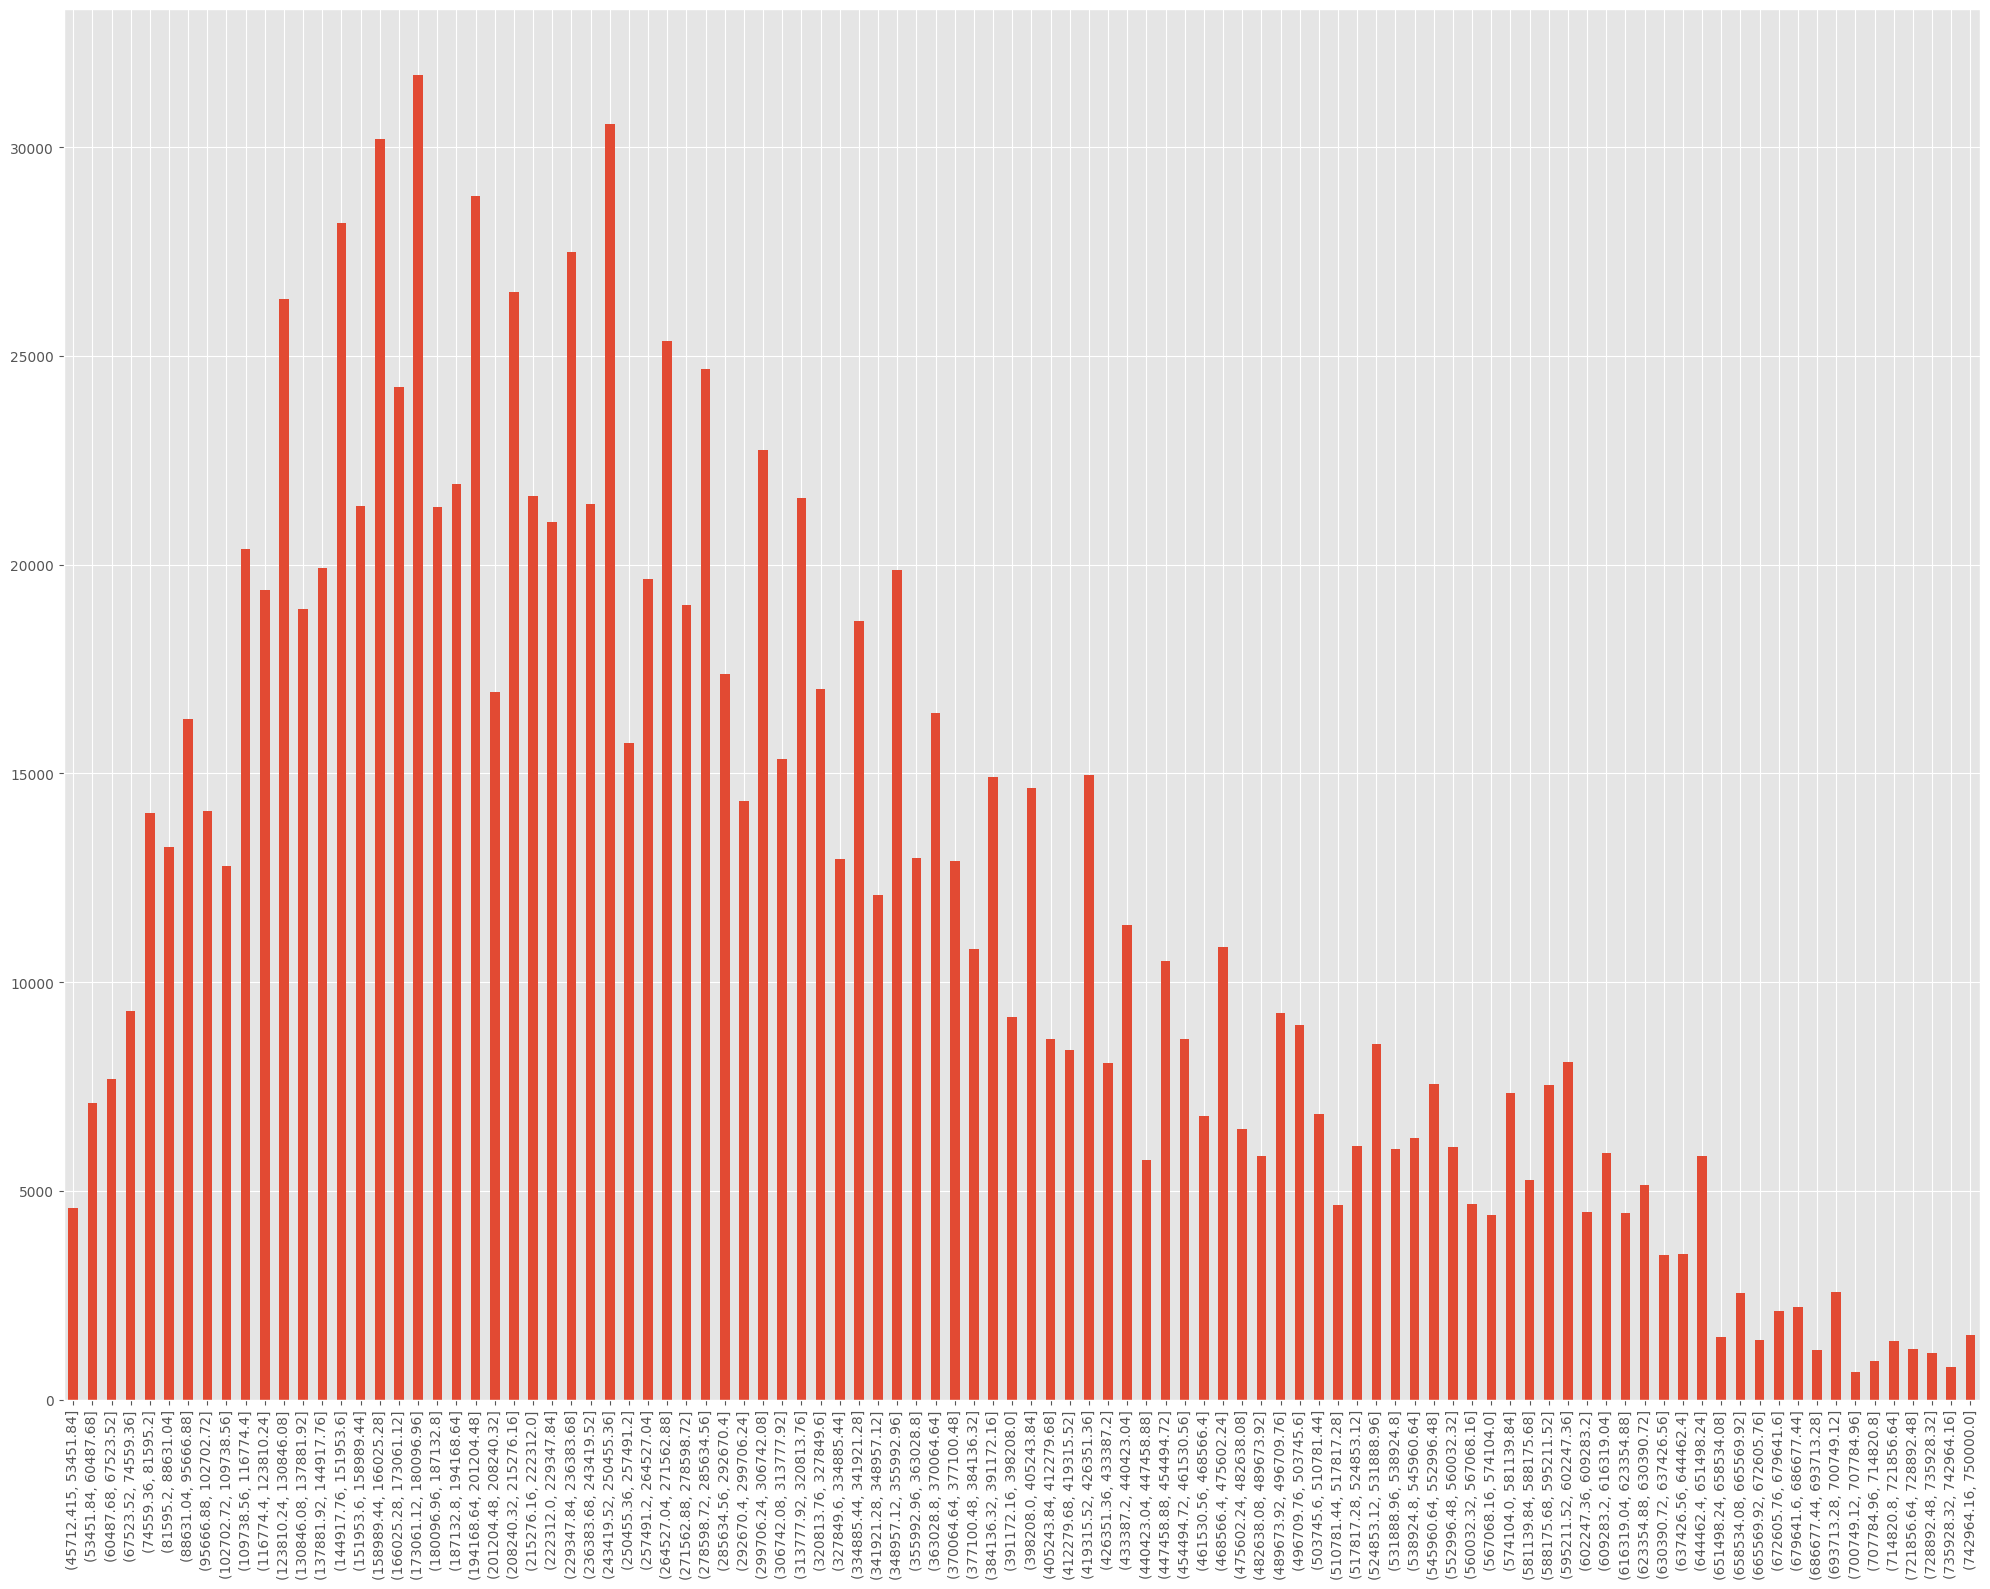

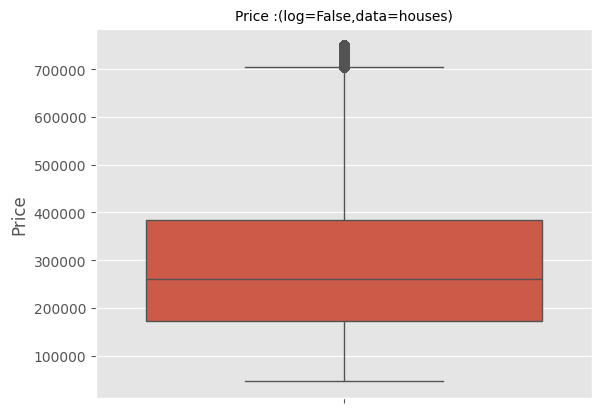

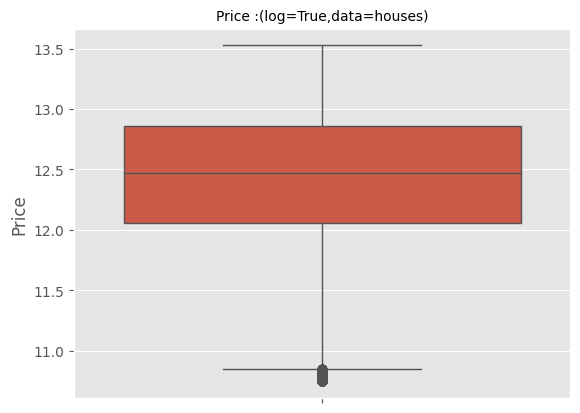

###################################################### CountyWeights ######################################################


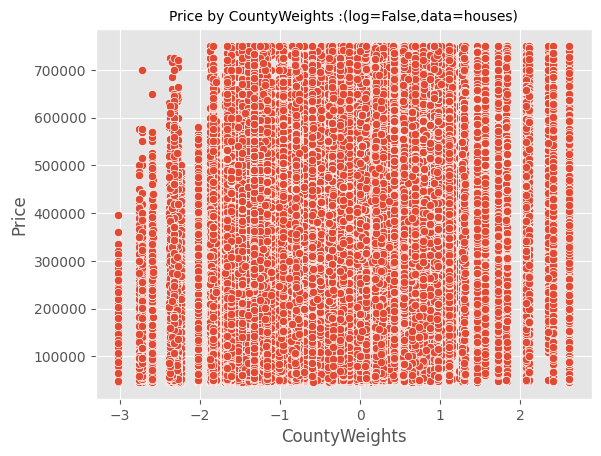

###################################################### DistrictWeights ######################################################


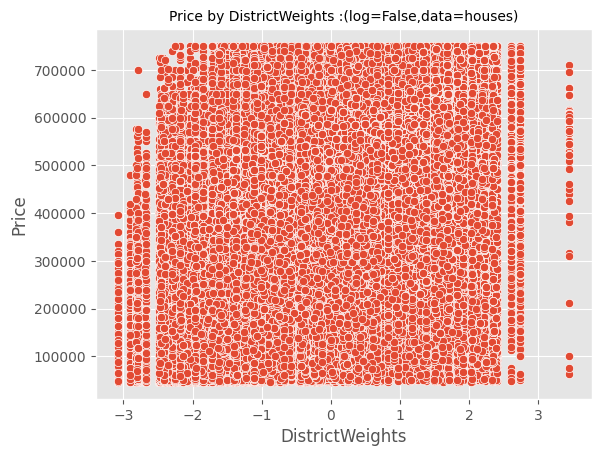

###################################################### TownCityWeights ######################################################


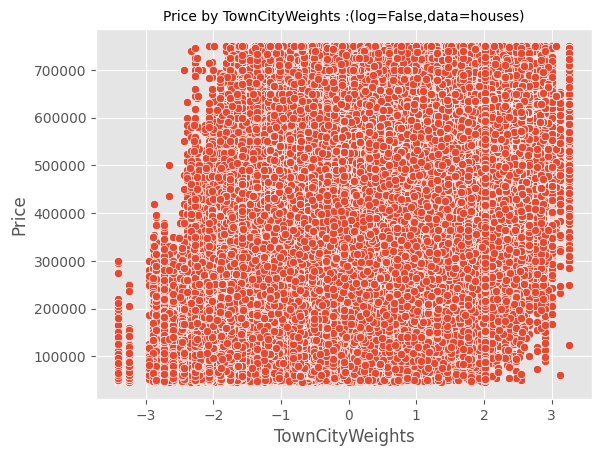

###################################################### PostcodeAreaWeights ######################################################


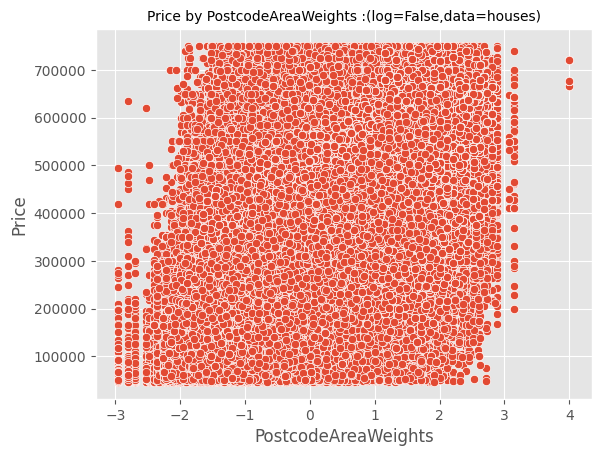

In [47]:
visualise_global(
    houses,
    bins=100,
    scatter_col=[
        "CountyWeights",
        "DistrictWeights",
        "TownCityWeights",
        "PostcodeAreaWeights"
    ]
)

#### Feature Transformation

In [48]:
houses_featured = houses.copy()
col_scatter = []

##### 'transformation_func' for each column

In [49]:
scatter_col = {
    "CountyWeights":lambda x: x**3,   #sigmoid : transformation_func = lambda x: sp.special.expit(x)
    "DistrictWeights":lambda x: x**3,
    "TownCityWeights":lambda x: x**3,
    "PostcodeAreaWeights":lambda x: x**3
}
col_scatter_list = scatter_col if type(scatter_col)==list else scatter_col.keys()
col_scatter = [col+'Transf' for col in col_scatter_list]
for k,v in scatter_col.items():
    houses_featured = transform_feat(
        df=houses_featured,
        cols=[k],
        func_transform=v
    )

##### get 'income_area' features from api based on 'postcode'

In [50]:
import requests
from bs4 import BeautifulSoup

def get_incomeByPostcode(x):
    if type(x) == str:
        postcode_payload = x.strip().replace(r"\s+","+")
        url = f"https://townnames.co.uk/search/postcode-income-results?search={postcode_payload}"
        # scrap data
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            table = soup.find("table",{"id":"myTable"})
            tbody = table.find("tbody")
            data_list = [i.find_all("td")[1].text for i in tbody.find_all("tr")]
        # get area_income
            regexp = re.compile(r"\d+")
            data = [int(re.search(regexp,income).group()) for income in data_list]
            if len(data)==0: return np.nan
            return round(sum(data) / len(data), 2) #f"{sum(data) / len(data):.2f}" #float("%.2f"%(sum(data) / len(data)))
    elif math.isnan(x): return np.nan

def postcodearea_averageincome(x,postcodes_income):
    return np.nan if not (x in postcodes_income) else postcodes_income[x]

def fix_incomearea(x,area_incomes_mean):
    if not math.isnan(x["area_income"]): return x["area_income"]
    elif not math.isnan(area_incomes_mean[x["postcode_group"]]) : return area_incomes_mean[x["postcode_group"]] 
    else: return area_incomes_mean.mean()

###### option 1 : Scrap data

In [ ]:
df_postcodes_income = pd.DataFrame(houses_featured['PostcodeArea'].value_counts().index,columns= ["postcode"])
df_postcodes_income["area_income"] = df_postcodes_income["postcode"].apply(get_incomeByPostcode)

In [ ]:
postcodes_income = df_postcodes_income.copy()

In [ ]:
postcodes_income['postcode_group'] = postcodes_income.postcode.str.extract(r'([a-z]+)',flags=re.I)

In [ ]:
area_incomes_mean = postcodes_income.groupby('postcode_group')["area_income"].mean()
postcodes_income["fixed_income"] = postcodes_income.apply(lambda x:fix_incomearea(x,area_incomes_mean=area_incomes_mean),axis=1)

In [ ]:
postcodes_income_dict = postcodes_income.set_index('postcode').to_dict()["fixed_income"]

In [ ]:
data_area_income = {
    "income_ByPostcode" : postcodes_income_dict
}
write_json(data_area_income)

###### option 2 : load data

In [51]:
postcodes_income_dict = load_json(data_name="income_ByPostcode")

###### "income_area" feature

In [52]:
houses_featured['income_area'] = houses_featured['PostcodeArea'].apply(lambda x: postcodearea_averageincome(x,postcodes_income=postcodes_income_dict))

In [53]:
houses_featured['income_area'].value_counts(dropna=False)

44514.711204    34348
38400.000000    11273
43682.504000     8108
50475.940000     2922
51226.860000     2525
                ...  
63297.220000        1
38809.356000        1
64616.220000        1
53993.700000        1
40937.128000        1
Name: income_area, Length: 2097, dtype: int64

###### "income_area" feature zscore

In [54]:
from scipy import stats
houses_featured['income_area_zscore'] = stats.zscore(houses_featured['income_area'])

##### Target : Price

In [55]:
# f-1 : np.expm1(np.log1p(houses_featured.Price))
houses_featured['Price'] = np.log1p(houses_featured.Price)

##### Visualization

In [56]:
houses_featured

Id      Price TransferDate  \
0        {CB0035E6-3546-58AE-E053-6B04A8C091AF}  13.353477   2021-04-29   
1        {CB0035E6-3547-58AE-E053-6B04A8C091AF}  13.075274   2021-05-10   
2        {CB0035E6-3548-58AE-E053-6B04A8C091AF}  12.821261   2021-05-06   
3        {CB0035E6-3549-58AE-E053-6B04A8C091AF}  13.044404   2021-04-28   
4        {CB0035E6-354A-58AE-E053-6B04A8C091AF}  12.978495   2021-08-06   
...                                         ...        ...          ...   
1213511  {D707E536-877C-0AD9-E053-6B04A8C067CC}  13.246476   2021-06-25   
1213512  {D707E536-877E-0AD9-E053-6B04A8C067CC}  12.832281   2021-07-22   
1213513  {D707E536-878A-0AD9-E053-6B04A8C067CC}  13.227437   2021-06-30   
1213514  {D707E536-878B-0AD9-E053-6B04A8C067CC}  13.290841   2021-07-23   
1213515  {D707E536-8790-0AD9-E053-6B04A8C067CC}  13.229846   2021-12-17   

         Postcode  PropertyType OldNew   Duration PAON     SAON  \
0        BN13 3AH      Detached    Old   Freehold    3      NaN   
1        BN16 2PQ      Detached    Old   Freehold   10      NaN   
2         BN2 4HZ      Terraced    Old   Freehold    6      NaN   
3         BN2 0GP      Terraced    Old   Freehold   18      NaN   
4         BN8 4LS      Detached    Old   Freehold   11      NaN   
...           ...           ...    ...        ...  ...      ...   
1213511    W8 4HH          Flat    Old  Leasehold    5  FLAT 10   
1213512   HA5 1AQ         Other    Old   Freehold   30      NaN   
1213513  NW11 7DD  SemiDetached    Old   Freehold   39      NaN   
1213514   W12 9PX      Terraced    Old   Freehold   39      NaN   
1213515   HA1 4AQ  SemiDetached    Old   Freehold  134      NaN   

                  Street  ... CountyWeights DistrictWeights TownCityWeights  \
0        HIGHLANDS CLOSE  ...      1.455878        0.350318        0.369099   
1         CHAUCER AVENUE  ...      1.455878        0.384803        0.286086   
2        DARTMOUTH CLOSE  ...      1.834150        1.135488        1.013624   
3         STANLEY STREET  ...      1.834150        1.135488        1.013624   
4            POWELL ROAD  ...      0.973492        0.939160        1.472119   
...                  ...  ...           ...             ...             ...   
1213511    VICARAGE GATE  ...      2.612081        2.393305        2.015308   
1213512    WEST END LANE  ...      2.612081        2.107934        2.666667   
1213513  ROTHERWICK ROAD  ...      2.612081        2.321524        2.015308   
1213514       PERCY ROAD  ...      2.612081        2.407555        2.015308   
1213515    WHITMORE ROAD  ...      2.612081        2.107934        1.692230   

        PostcodeAreaWeights CountyWeightsTransf DistrictWeightsTransf  \
0                  0.426866            3.085851              0.042992   
1                  0.760000            3.085851              0.056979   
2                  0.921527            6.170271              1.464022   
3                  0.921527            6.170271              1.464022   
4                  1.344262            0.922565              0.828360   
...                     ...                 ...                   ...   
1213511            1.767123           17.822141             13.708640   
1213512            2.553306           17.822141              9.366370   
1213513            1.893175           17.822141             12.511792   
1213514            1.750376           17.822141             13.954969   
1213515            1.215385           17.822141              9.366370   

         TownCityWeightsTransf  PostcodeAreaWeightsTransf income_area  \
0                     0.050284                   0.077781    43762.80   
1                     0.023415                   0.438976    40381.00   
2                     1.041431                   0.782572    38857.36   
3                     1.041431                   0.782572    38857.36   
4                     3.190279                   2.429137    49009.75   
...                        ...                        ...         ...   
12

###################################################### Price ######################################################


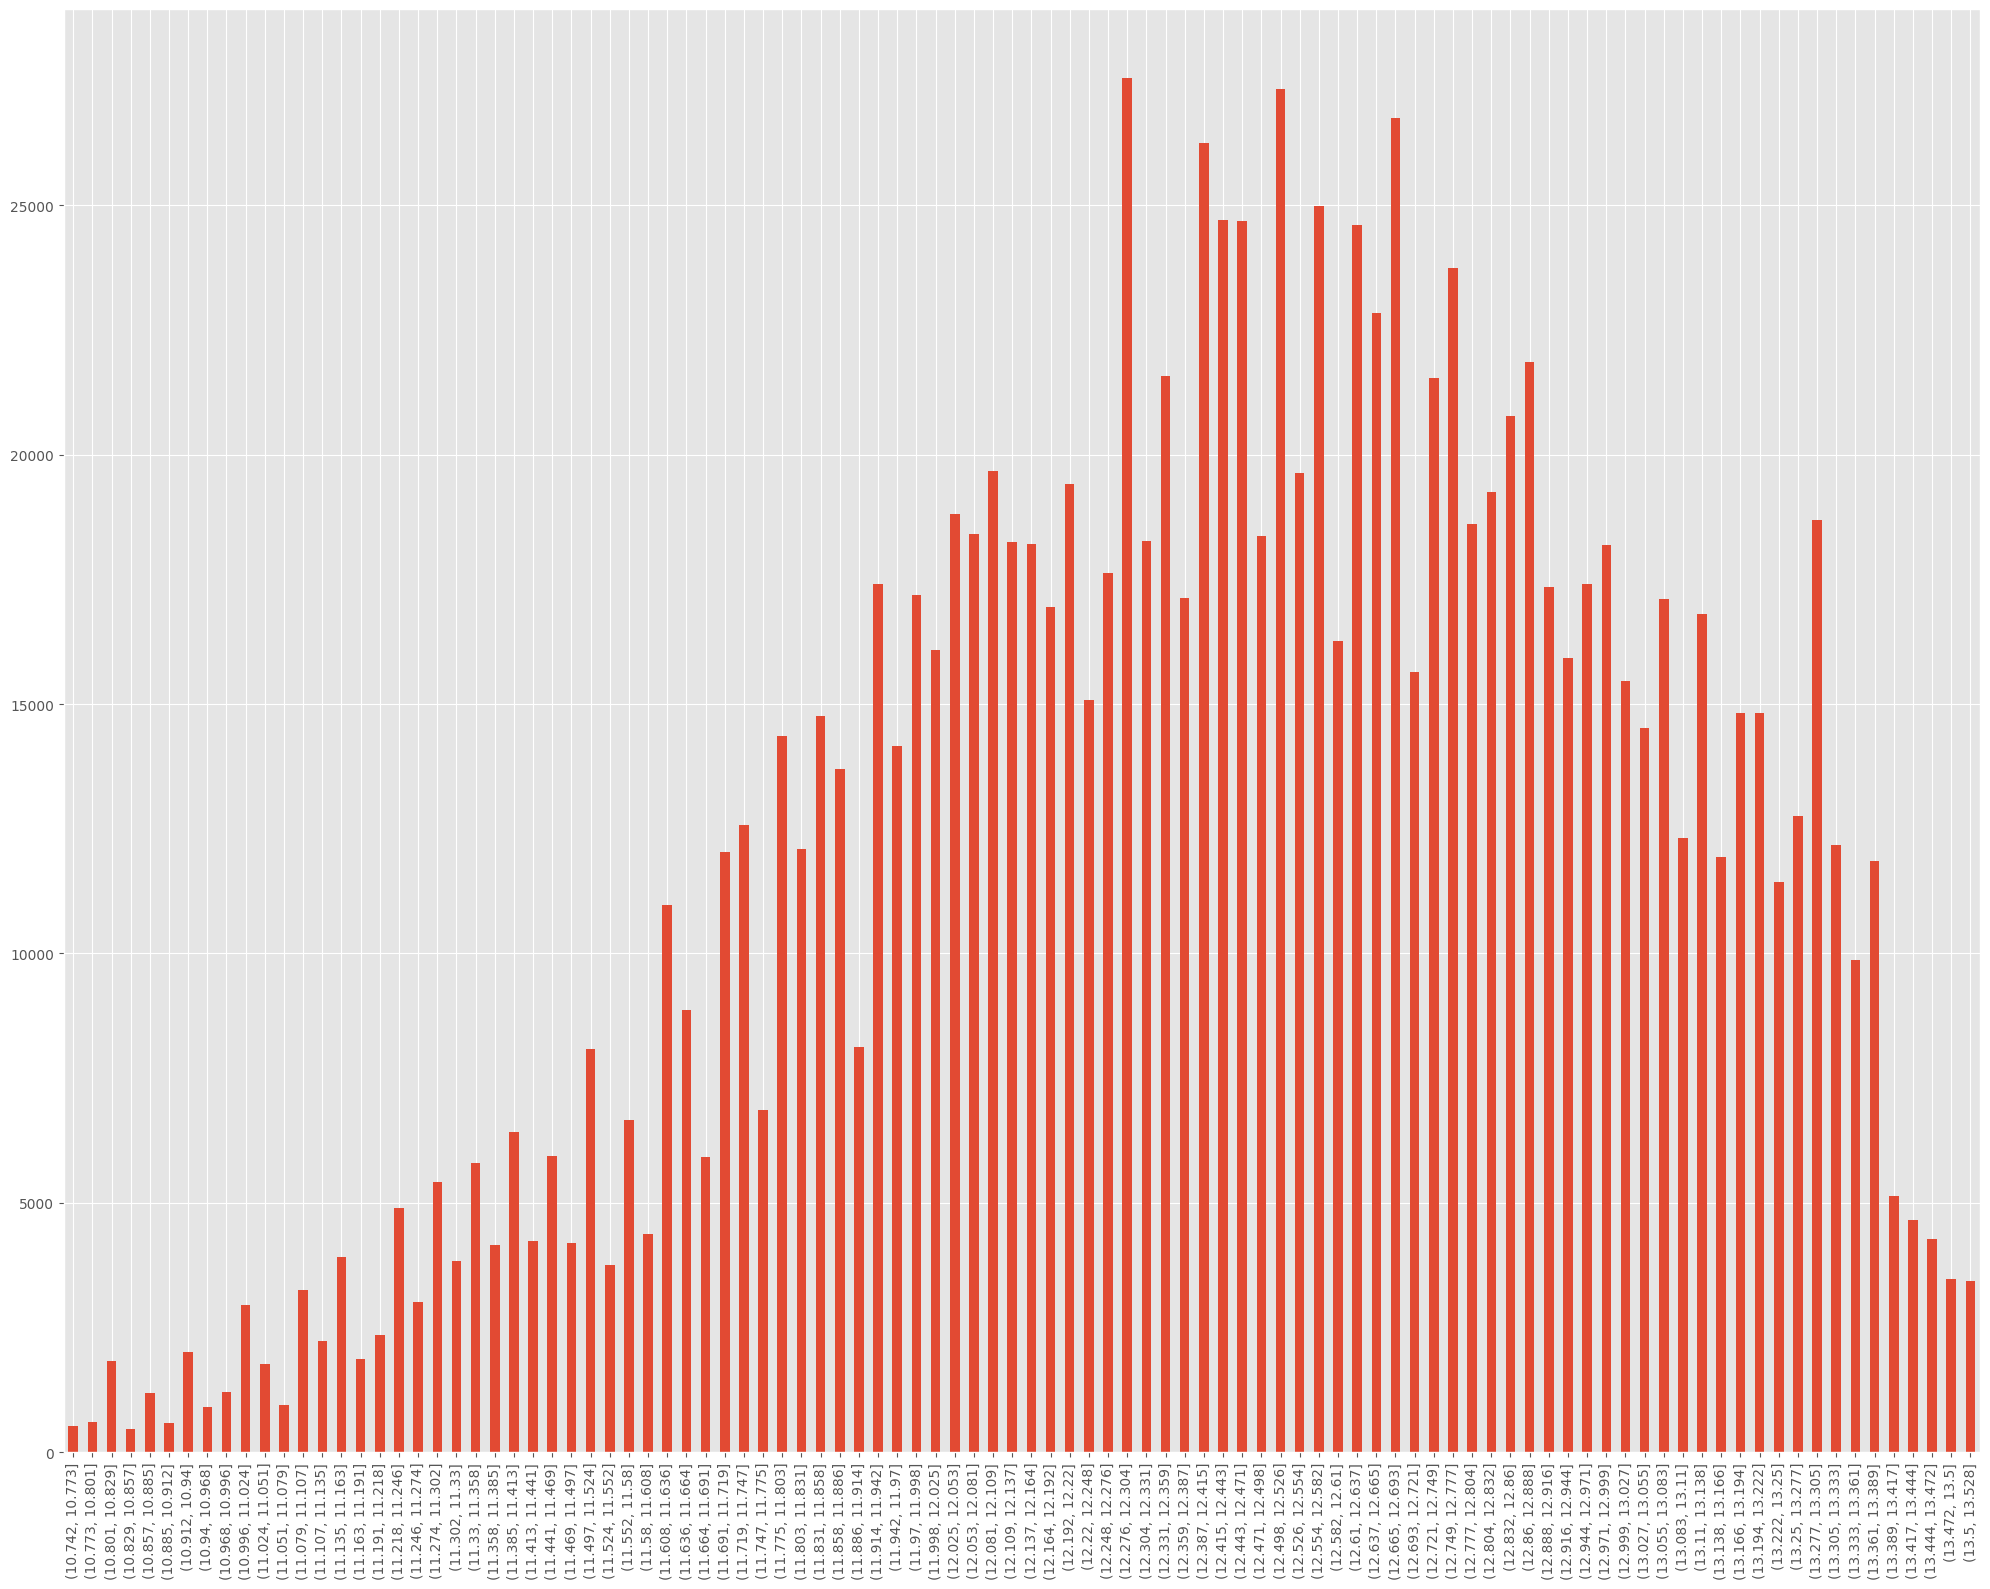

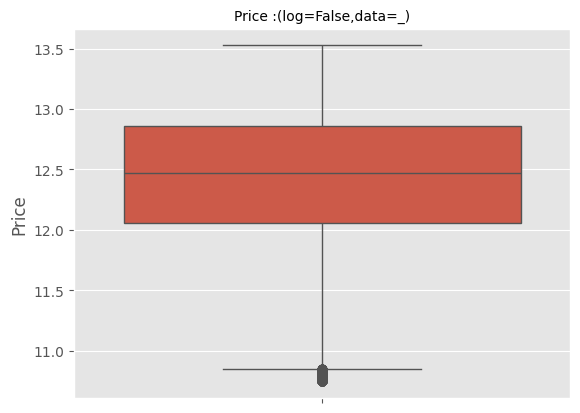

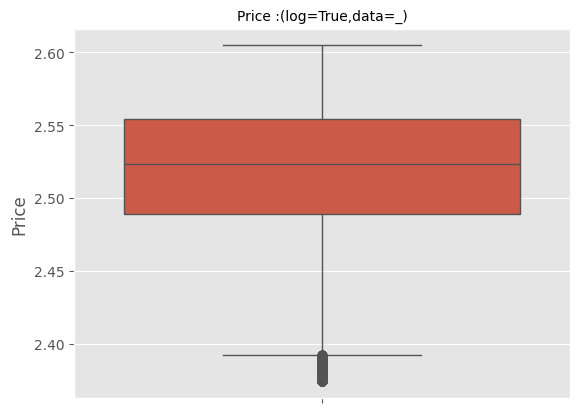

###################################################### CountyWeightsTransf ######################################################


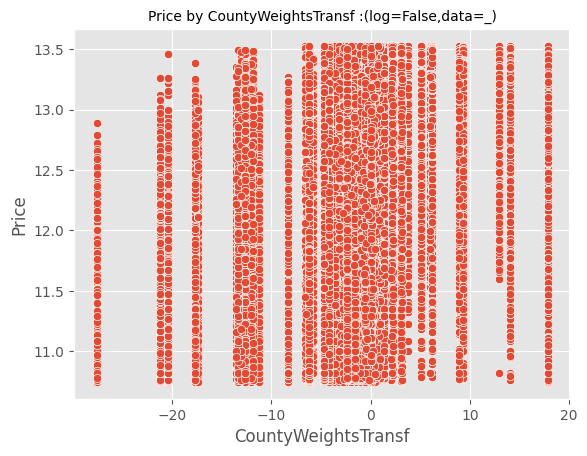

###################################################### DistrictWeightsTransf ######################################################


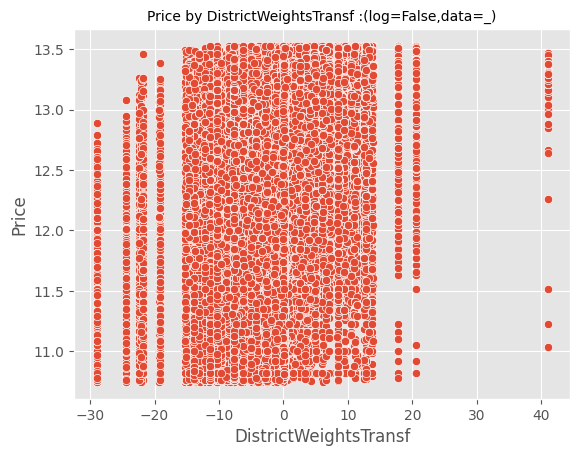

###################################################### TownCityWeightsTransf ######################################################


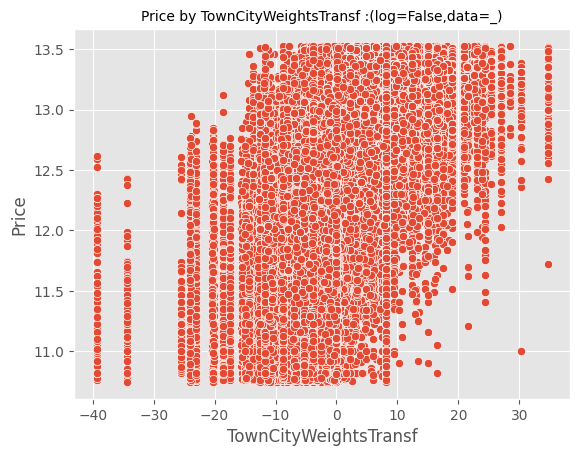

###################################################### PostcodeAreaWeightsTransf ######################################################


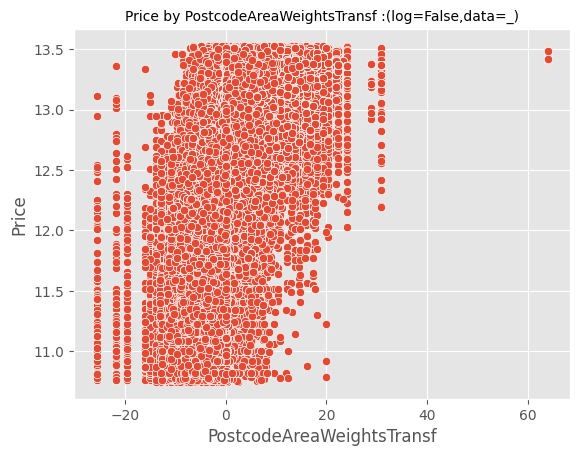

In [57]:
visualise_global(
    houses_featured,
    bins=100,
    scatter_col=col_scatter
)

## Data Encoding

### houses_selected

In [58]:
selected_features = [
    'Price',
    "PropertyType",
    "OldNew",
    "Duration",
    "PPDCategoryType",
    "TransferMonth",
    "TransferDay",
    "CountyWeights",
    "DistrictWeights",
    "TownCityWeights",
    "PostcodeAreaWeights",
    *[i for i in houses_featured.columns if 'income' in i],
    *col_scatter
]
houses_selected = houses_featured.loc[:,selected_features].copy()
houses_selected.reset_index(drop=True,inplace=True)

In [59]:
houses_selected

Price  PropertyType OldNew   Duration  PPDCategoryType  \
0        13.353477      Detached    Old   Freehold    StandardPrice   
1        13.075274      Detached    Old   Freehold    StandardPrice   
2        12.821261      Terraced    Old   Freehold    StandardPrice   
3        13.044404      Terraced    Old   Freehold    StandardPrice   
4        12.978495      Detached    Old   Freehold    StandardPrice   
...            ...           ...    ...        ...              ...   
1213511  13.246476          Flat    Old  Leasehold  AdditionalPrice   
1213512  12.832281         Other    Old   Freehold  AdditionalPrice   
1213513  13.227437  SemiDetached    Old   Freehold  AdditionalPrice   
1213514  13.290841      Terraced    Old   Freehold  AdditionalPrice   
1213515  13.229846  SemiDetached    Old   Freehold  AdditionalPrice   

         TransferMonth  TransferDay  CountyWeights  DistrictWeights  \
0                    4           29       1.455878         0.350318   
1                    5           10       1.455878         0.384803   
2                    5            6       1.834150         1.135488   
3                    4           28       1.834150         1.135488   
4                    8            6       0.973492         0.939160   
...                ...          ...            ...              ...   
1213511              6           25       2.612081         2.393305   
1213512              7           22       2.612081         2.107934   
1213513              6           30       2.612081         2.321524   
1213514              7           23       2.612081         2.407555   
1213515             12           17       2.612081         2.107934   

         TownCityWeights  PostcodeAreaWeights  income_area  \
0               0.369099             0.426866     43762.80   
1               0.286086             0.760000     40381.00   
2               1.013624             0.921527     38857.36   
3               1.013624             0.921527     38857.36   
4               1.472119             1.344262     49009.75   
...                  ...                  ...          ...   
1213511         2.015308             1.767123     54063.84   
1213512         2.666667             2.553306     63901.44   
1213513         2.015308             1.893175     59771.31   
1213514         2.015308             1.750376     53468.57   
1213515         1.692230             1.215385     57290.05   

         income_area_zscore  CountyWeightsTransf  DistrictWeightsTransf  \
0                 -0.039606             3.085851               0.042992   
1                 -0.484883             3.085851               0.056979   
2                 -0.685499             6.170271               1.464022   
3                 -0.685499             6.170271               1.464022   
4                  0.651252             0.922565               0.828360   
...                     ...                  ...                    ...   
1213511            1.316717            17.822141              13.708640   
1213512            2.612019            17.822141               9.366370   
1213513            2.068211            17.822141              12.511792   
1213514            1.238338            17.822141              13.954969   
1213515            1.741507            17.822141               9.366370   

         TownCityWeightsTransf  PostcodeAreaWeightsTransf  
0                     0.050284                   0.077781  
1                     0.023415                   0.438976  
2                     1.041431                   0.782572  
3                     1.041431                   0.782572  
4                     3.190279                   2.429137  
...                        ...                        ...  
1213511               8.185102                   5.518240  
1213512              18.962963                  16.645957  
1213513               8.185102                   6.785351  
1213514               8.185102                   5.362830  
1

### houses_encoded

In [60]:
houses_encoded = houses_selected.copy()

#### Label encoding

In [61]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
houses_encoded['PPDCategoryType'] = label_encoder.fit_transform(houses_encoded['PPDCategoryType'])
houses_encoded['OldNew'] = label_encoder.fit_transform(houses_encoded['OldNew'])
houses_encoded['Duration'] = label_encoder.fit_transform(houses_encoded['Duration'])

#### OneHotEncoding

In [62]:
from sklearn.preprocessing import OneHotEncoder
categ_features = [
    "PropertyType",
    "TransferMonth"
]

one_hot_encoder = OneHotEncoder(sparse_output=False) # feature_name_combiner=lambda x,y:str(x)+"_"+str(y)
encoded_categ_features = one_hot_encoder.fit_transform(houses_encoded[categ_features])

df_encoded_categ_features = pd.DataFrame(
    encoded_categ_features, 
    columns = one_hot_encoder.get_feature_names_out(categ_features)
)

In [63]:
houses_encoded = pd.concat([houses_encoded,df_encoded_categ_features], axis=1)

#### fixing "houses_encoded"

In [64]:
houses_encoded.drop(
    [
        "PropertyType",
        "TransferMonth",
        "TransferDay"
    ],
    axis=1,
    inplace=True
)

In [65]:
input_features_encoded = [k for k in houses_encoded.columns if not (k in ("Price",'income_area')) and not ('Weights' in k)]
houses_encoded = houses_encoded.astype(
    {
        k:int for k in input_features_encoded
    }
)

#### show "houses_encoded"

In [66]:
houses_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1213516 entries, 0 to 1213515
Data columns (total 31 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Price                      1213516 non-null  float64
 1   OldNew                     1213516 non-null  int64  
 2   Duration                   1213516 non-null  int64  
 3   PPDCategoryType            1213516 non-null  int64  
 4   CountyWeights              1213516 non-null  float64
 5   DistrictWeights            1213516 non-null  float64
 6   TownCityWeights            1213516 non-null  float64
 7   PostcodeAreaWeights        1213516 non-null  float64
 8   income_area                1213516 non-null  float64
 9   income_area_zscore         1213516 non-null  int64  
 10  CountyWeightsTransf        1213516 non-null  float64
 11  DistrictWeightsTransf      1213516 non-null  float64
 12  TownCityWeightsTransf      1213516 non-null  float64
 13  PostcodeArea

In [67]:
houses_encoded.corr()['Price'].head(50)

Price                        1.000000
OldNew                      -0.093736
Duration                    -0.162975
PPDCategoryType              0.160857
CountyWeights                0.603477
DistrictWeights              0.637373
TownCityWeights              0.648185
PostcodeAreaWeights          0.689100
income_area                  0.539935
income_area_zscore           0.460491
CountyWeightsTransf          0.534030
DistrictWeightsTransf        0.571729
TownCityWeightsTransf        0.573116
PostcodeAreaWeightsTransf    0.611644
PropertyType_Detached        0.381797
PropertyType_Flat           -0.099777
PropertyType_Other          -0.010617
PropertyType_SemiDetached   -0.045052
PropertyType_Terraced       -0.236232
TransferMonth_1              0.008675
TransferMonth_2              0.011710
TransferMonth_3              0.043789
TransferMonth_4             -0.015351
TransferMonth_5             -0.023125
TransferMonth_6              0.115461
TransferMonth_7             -0.097042
TransferMont

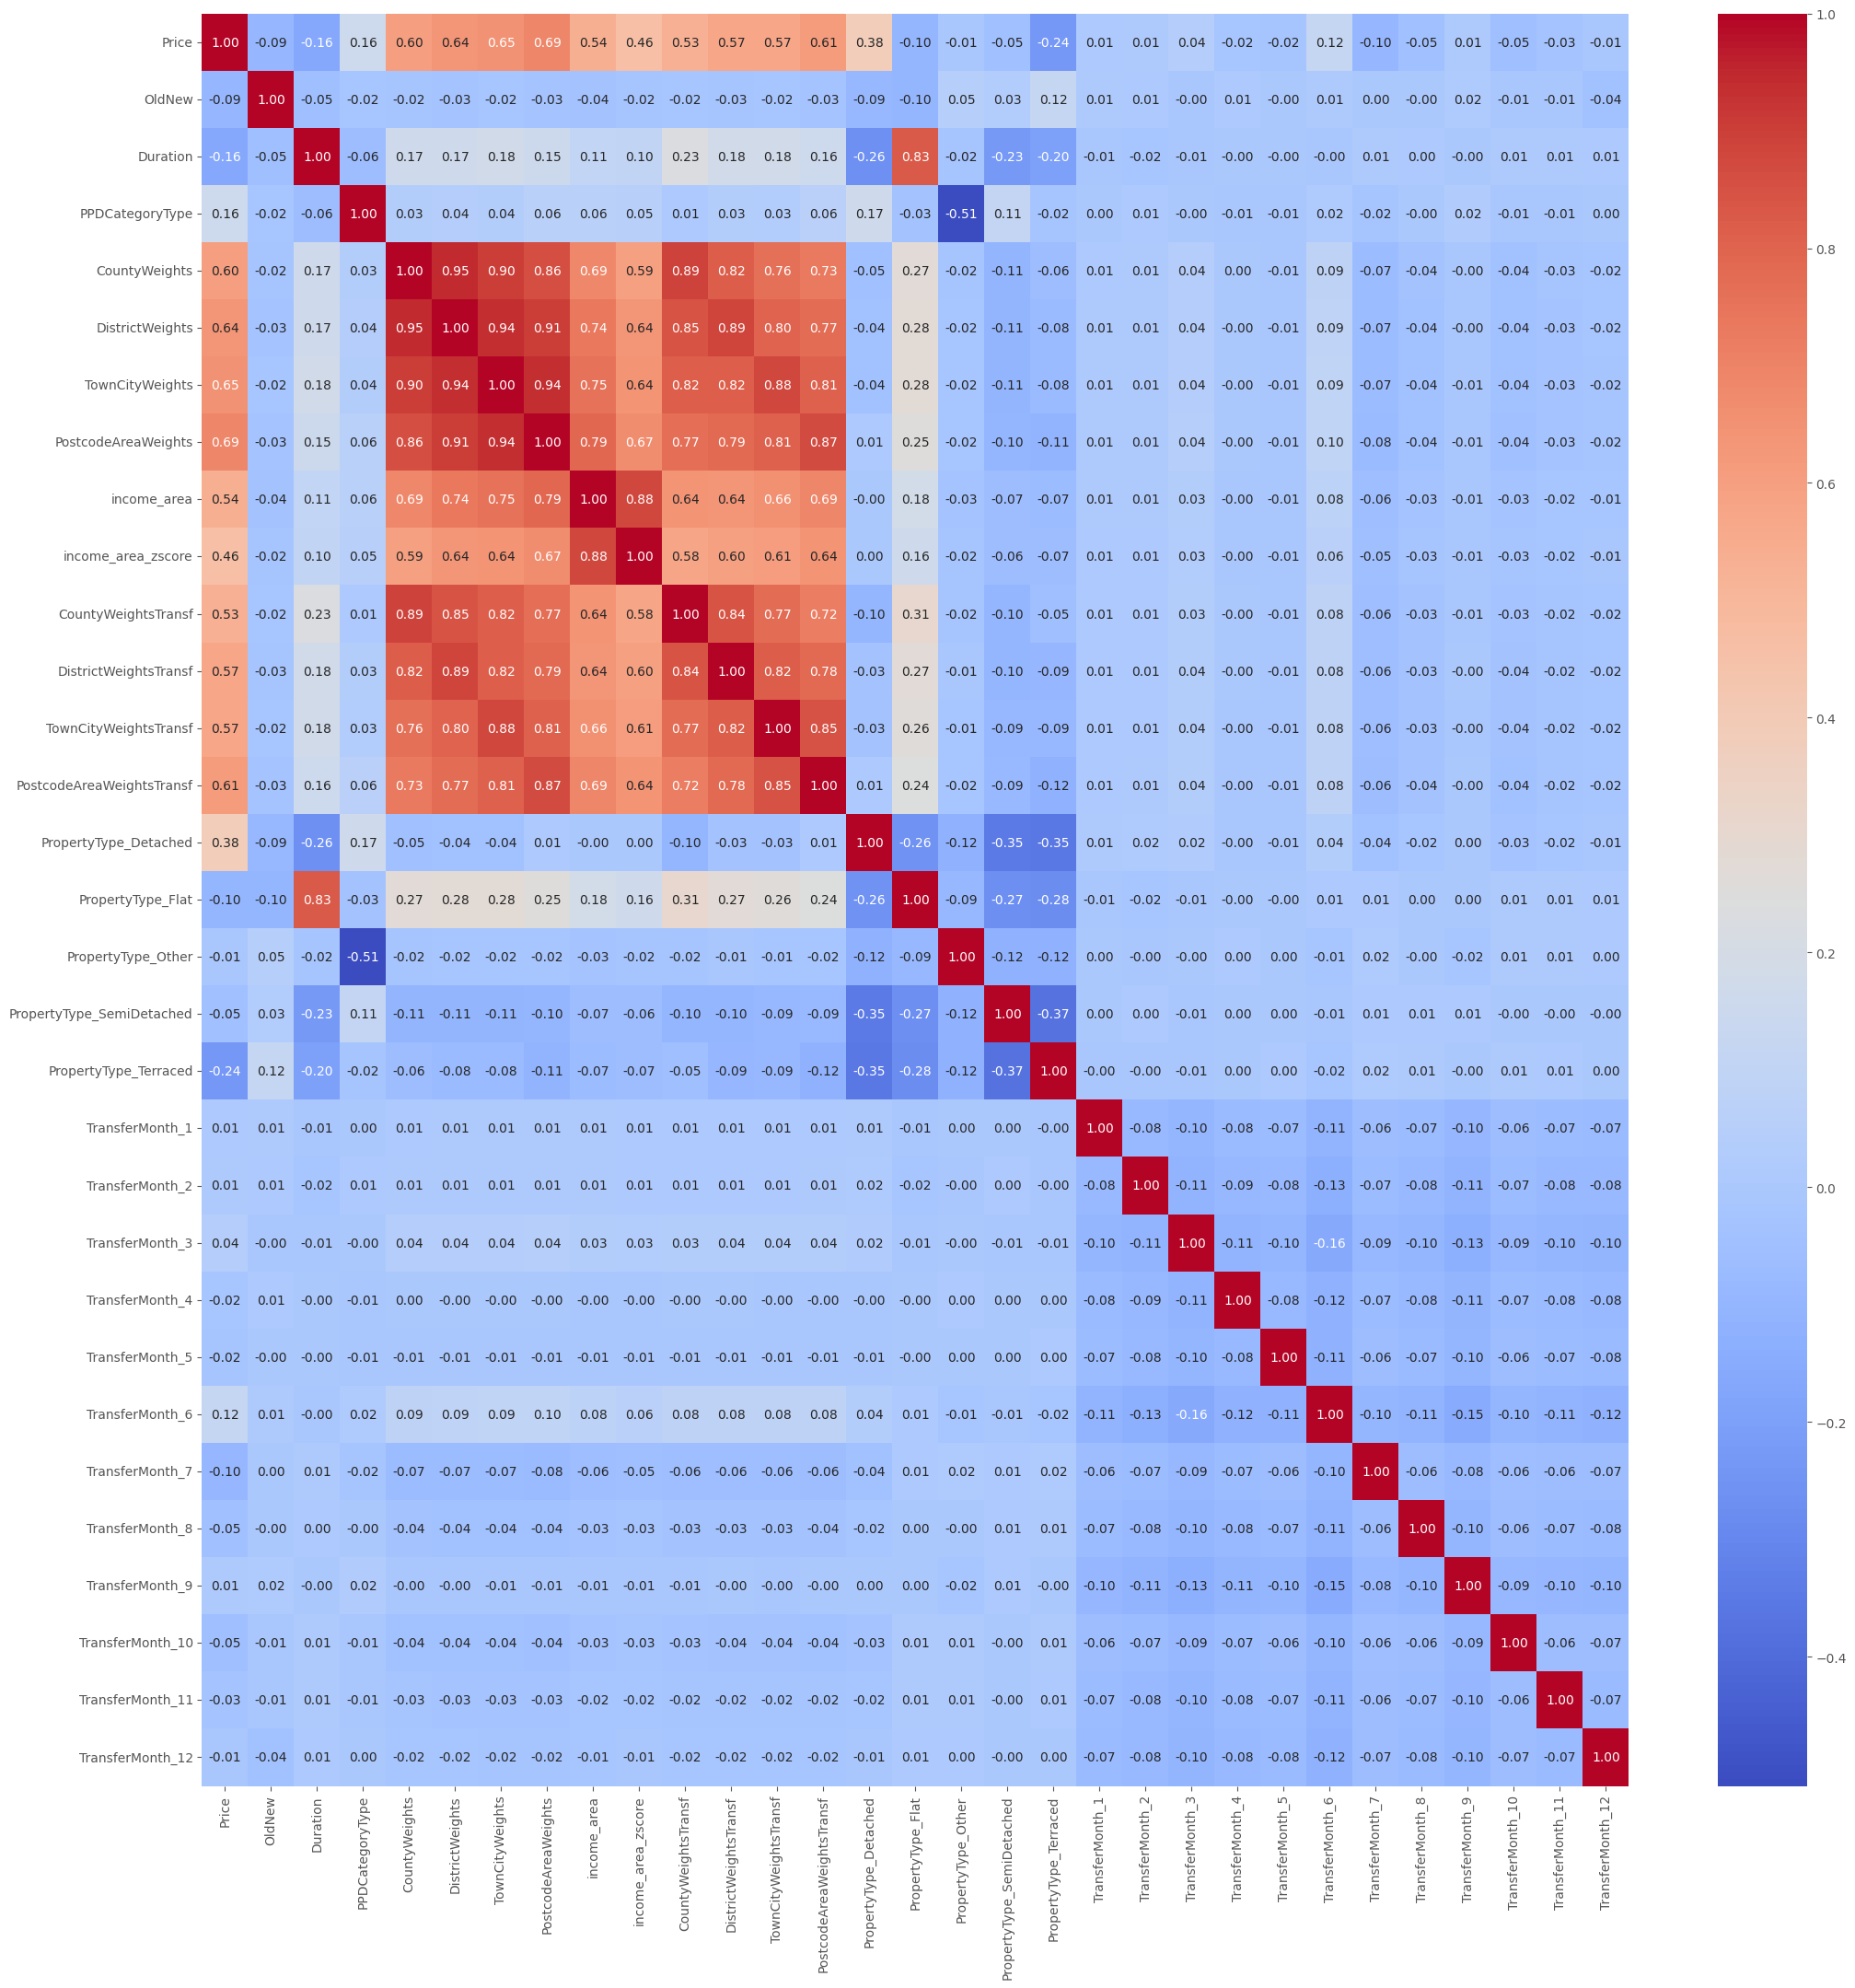

In [68]:
plt.figure(figsize = (25,25))
sns.heatmap(houses_encoded.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

# Model Selection

## Data (for Modeling) & Data_Unseen (for test)

In [69]:
data = stratified_sampling(
    df=houses_encoded,
    colname="PPDCategoryType",
    frac=0.95,
    random_state=1
)
data_unseen = houses_encoded.drop(data.index)
# drop index
data.reset_index(inplace=True, drop=True)
data_unseen.reset_index(inplace=True, drop=True)

print('Data for Modeling: ' + str(data.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (1152840, 31)
Unseen Data For Predictions: (60676, 31)


## Select Data_train

In [70]:
train_features = [k for k in data.columns if not ('Price' in k)] #or ('Month' in k))]
target = 'Price'
# inputs = [*train_features,target]
inputs = [
    'OldNew' ,  
    'Duration' , 
    'PPDCategoryType',
    # Month
    *[k for k in data.columns if ('Month' in k)],
    # Weights
    # *[k for k in data.columns if ('Weights' in k) and (not ("Transf" in k))],
    # # zscore
    *[k for k in data.columns if ('WeightsTransf' in k)],
    # PropertyType
    *[k for k in data.columns if ('PropertyType' in k)],
    # score
    *[i for i in data.columns if 'income' in i],
    # target
    target
]
data_train = data.loc[:,inputs]

In [71]:
print(data_train.columns)
print(data_train.shape)

Index(['OldNew', 'Duration', 'PPDCategoryType', 'TransferMonth_1',
       'TransferMonth_2', 'TransferMonth_3', 'TransferMonth_4',
       'TransferMonth_5', 'TransferMonth_6', 'TransferMonth_7',
       'TransferMonth_8', 'TransferMonth_9', 'TransferMonth_10',
       'TransferMonth_11', 'TransferMonth_12', 'CountyWeightsTransf',
       'DistrictWeightsTransf', 'TownCityWeightsTransf',
       'PostcodeAreaWeightsTransf', 'PropertyType_Detached',
       'PropertyType_Flat', 'PropertyType_Other', 'PropertyType_SemiDetached',
       'PropertyType_Terraced', 'income_area', 'income_area_zscore', 'Price'],
      dtype='object')
(1152840, 27)


### Modeling

- for Model directory for saving and loading is stored in "model_dir_location"

In [72]:
model_dir_location = f'./models/{outliers_regularisation_method}/'
sklearn_model_dir_location = './models/sklearn/'

#### Option 1: Sklearn

In [73]:
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [74]:
inputs = [
    'OldNew' ,  
    'Duration' , 
    'PPDCategoryType',
    # Month
    *[k for k in data.columns if ('Month' in k)],
    # Weights
    *[k for k in data.columns if ('Weights' in k) and (not ("Transf" in k))],
    # # zscore
    # *[k for k in data.columns if ('WeightsTransf' in k)],
    # PropertyType
    *[k for k in data.columns if ('PropertyType' in k)],
    # score
    'income_area',
    # 'income_area_zscore',
    # *[i for i in data.columns if 'income' in i],
    # target
    target
]
data = houses_encoded.loc[:,inputs]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(
    data.loc[:,[i for i in data.columns if i!='Price']], 
    data.Price, 
    test_size=0.1, 
    random_state=13
)

##### HistGradientBoostingRegressor

In [76]:
from sklearn.ensemble import HistGradientBoostingRegressor
model = HistGradientBoostingRegressor().fit(X_train, y_train)

In [77]:
model.score(X_train, y_train)

0.7459388699200311

In [78]:
from sklearn.metrics import r2_score
y_predictions = model.predict(X_test)
r2_score(y_test, y_predictions)

0.7465361047376409

##### xgboost

###### option 1:

In [79]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score
model = XGBRegressor(
    n_estimators=1000, 
    max_depth=7, 
    eta=0.1, 
    subsample=0.7, 
    colsample_bytree=0.8,
    device="cuda"
)
cv = RepeatedKFold(
    n_splits=10, 
    n_repeats=3, 
    random_state=1
)
scores = cross_val_score(
    model, 
    X_train, 
    y_train, 
    scoring= 'r2',  #'neg_mean_squared_error', #'r2', 
    cv=cv, 
    n_jobs=-1
)
model.fit(X_train, y_train)
model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eta=0.1, eval_metric=None,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, ...)

In [80]:
model.score(X_train, y_train)

/home/madfo/.pyenv/versions/pycaret3.0/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [18:48:41] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


0.7902217964043801

In [81]:
y_predictions = model.predict(X_test)
r2_score(y_test, y_predictions)

0.7776556197903554

In [ ]:
filename = sklearn_model_dir_location + 'model_xgboost_withIncomeArea.sav'

In [ ]:
# save the model to disk
# pickle.dump(model, open(filename, 'wb'))

In [ ]:
order_features = [
    'OldNew', 
    'Duration', 
    'PPDCategoryType', 
    'TransferMonth_1', 
    'TransferMonth_2', 
    'TransferMonth_3', 
    'TransferMonth_4', 
    'TransferMonth_5', 
    'TransferMonth_6', 
    'TransferMonth_7', 
    'TransferMonth_8', 
    'TransferMonth_9', 
    'TransferMonth_10', 
    'TransferMonth_11', 
    'TransferMonth_12', 
    'CountyWeights', 
    'DistrictWeights', 
    'TownCityWeights', 
    'PostcodeAreaWeights', 
    'PropertyType_Detached', 
    'PropertyType_Flat', 
    'PropertyType_Other', 
    'PropertyType_SemiDetached', 
    'PropertyType_Terraced',
    'income_area'
] 

In [ ]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test.loc[:,order_features], y_test)
print(result)

###### option 2:

In [82]:
from sklearn.metrics import get_scorer_names
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [83]:
from xgboost import XGBRegressor
from sklearn.model_selection import RepeatedKFold, cross_val_score, RandomizedSearchCV
model = XGBRegressor(
    n_estimators=1000, 
    max_depth=7, 
    eta=0.1, 
    subsample=0.7, 
    colsample_bytree=0.8,
    device="cuda"
)
log_params = {'penalty': ['l1', 'l2'], 'C': [1E-7, 1E-6, 1E-6, 1E-4, 1E-3]}
search = RandomizedSearchCV(
    model, 
    scoring='average_precision', 
    cv=10,
    n_iter=10, 
    param_distributions=log_params,
    refit=True, 
    n_jobs=-1
)
search.fit(X_train, y_train)
model = search.best_estimator_

/home/madfo/.pyenv/versions/pycaret3.0/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [18:45:54] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/home/madfo/.pyenv/versions/pycaret3.0/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [18:49:34] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "C", "penalty" } are not used.

  warnings.warn(smsg, UserWarning)
/home/madfo/.pyenv/versions/pycaret3.0/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:778: UserWarning: Scoring failed. The score on this train-test partition for 

In [85]:
y_predictions = model.predict(X_test)
r2_score(y_test, y_predictions)

0.7776556197903554

##### linear regression:

In [86]:
from sklearn.linear_model import LinearRegression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

LinearRegression()

In [87]:
lr_model.score(X_train, y_train)

0.687196702531809

In [88]:
y_predictions = lr_model.predict(X_test)
r2_score(y_test, y_predictions)

0.6882802617650166

##### SVM:

In [ ]:
from sklearn import svm
svm_model = svm.SVR()
svm_model.fit(X_train, y_train)

In [ ]:
svm_model.score(X_train, y_train)

In [ ]:
y_predictions = svm_model.predict(X_test)
r2_score(y_test, y_predictions)

#### Option 2: Pycaret

##### Training

In [ ]:
from pycaret.regression import *
predictor = setup(
    data = data_train, 
    target = 'Price', 
    normalize=True ,
    session_id=123,
    use_gpu=True
)

In [ ]:
models()

In [ ]:
best_model = compare_models()

In [ ]:
print(best_model)

##### plot

In [ ]:
plot_model(best_model, plot = 'residuals')

In [ ]:
plot_model(best_model, plot = 'error')

In [ ]:
plot_model(best_model, plot = 'feature')

##### Model tuning

In [ ]:
best_model_tuned = tune_model(best_model,optimize='R2')

##### predict tuned model

In [ ]:
best_model_tuned

In [ ]:
[x for x in data_unseen.columns]

In [ ]:
data_unseen_inputs = data_unseen.loc[:,[k for k in data_unseen.columns if k!='Price']]
data_unseen_output = data_unseen.loc[:,target]

In [ ]:
predictions = predict_model(best_model_tuned, data = data_unseen_inputs)

In [ ]:
predictions.head()

##### r2

In [ ]:
from sklearn.metrics import r2_score

r2_score(data_unseen_output, predictions['prediction_label'])

##### finalise model

In [ ]:
house_predictor_model = finalize_model(best_model_tuned)

In [ ]:
predictions_finalised = predict_model(house_predictor_model, data = data_unseen_inputs)

In [ ]:
from sklearn.metrics import r2_score

r2_score(data_unseen_output, predictions_finalised['prediction_label'])

##### save model

In [ ]:
model_version = 'v2' 

In [ ]:
name_model = model_dir_location + 'house_predictor_model_withIncomeArea' + '_' + model_version
# save_model(house_predictor_model, name_model)

##### load model

In [ ]:
model_version = 'v2' 

In [ ]:
name_model = model_dir_location + 'house_predictor_model' + "_" + model_version
inputs = [
    'OldNew' ,  
    'Duration' , 
    'PPDCategoryType',
    # Month
    *[k for k in data.columns if ('Month' in k)],
    # Weights
    *[k for k in data.columns if ('Weights' in k) and (not ("Transf" in k))],
    # # zscore
    *[k for k in data.columns if ('WeightsTransf' in k)],
    # PropertyType
    *[k for k in data.columns if ('PropertyType' in k)],
    # target
    target
]
data_unseen_inputs = data_unseen.loc[:,[k for k in inputs if k!='Price']]

In [ ]:
house_predictor_model = load_model(name_model)

In [ ]:
predictions_mloaded = predict_model(house_predictor_model, data = data_unseen_inputs)

In [ ]:
from sklearn.metrics import r2_score

r2_score(data_unseen_output, predictions_mloaded['prediction_label'])

## Live App
<a name='GDF'></a>
to visualise this app performance, please refer to this link: